In [ ]:
# Gerekli kütüphaneler projeye dahil ediliyor
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk  # Cyberpunk tarzı grafik çizimi için
plt.style.use("cyberpunk")  # Cyberpunk grafik stilini aktif et
import cv2  # Görüntü işleme kütüphanesi
import tensorflow as tf  # Derin öğrenme kütüphanesi
from sklearn.utils import shuffle  # Veri karıştırmak için
from sklearn.model_selection import train_test_split  # Veri setini eğitim ve test olarak bölmek için
from tensorflow.keras.models import Sequential  # Sıralı model oluşturmak için
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization  # Katmanlar
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint  # Eğitim süreci kontrolü için
from sklearn.metrics import classification_report, confusion_matrix  # Başarı değerlendirmesi için metrikler
from tqdm import tqdm  # Döngüde ilerleme çubuğu göstermek için

from warnings import filterwarnings  # Uyarıları filtrelemek için

# Kaggle ortamındaki dosyaları listelemek için kullanılan kod bloğu
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Google Drive'ı bağlama işlemi
from google.colab import drive
drive.mount('/content/drive')

# Veri setinin bulunduğu klasör yolunu kontrol etme
import os
directory_path = '/content/drive/My Drive/DataSets'
if os.path.exists(directory_path):
    print("Klasör mevcut!")
else:
    print("Klasör mevcut değil.")

# Eğitim verilerinin ve etiketlerinin tutulacağı boş listeler
X_train = []  # Görüntü verilerini saklayacağımız liste
y_train = []  # Görüntülere karşılık gelen etiketleri saklayacağımız liste

# Kullanılan tüm sınıf etiketleri (klasör isimleri)
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

# Görüntü boyutlandırması için kullanılacak hedef boyut
image_size = 150  # Her görüntü 150x150 piksele yeniden boyutlandırılacak

# Eğitim verileri için her bir sınıfın görüntülerini listeye ekleme
for i in labels:
    folderPath = os.path.join('/content/drive/My Drive/DataSets/Training', i)  # Etikete karşılık gelen klasör yolu
    for j in tqdm(os.listdir(folderPath)):  # Klasördeki her bir görüntü için
        img = cv2.imread(os.path.join(folderPath, j))  # Görüntü dosyasını oku
        img = cv2.resize(img, (image_size, image_size))  # Görüntüyü yeniden boyutlandır
        X_train.append(img)  # Görüntüyü eğitim verisine ekle
        y_train.append(i)  # Görüntünün etiketini ekle

# Test verileri için aynı işlemler yapılır
for i in labels:
    folderPath = os.path.join('/content/drive/My Drive/DataSets/Testing', i)  # Etikete karşılık gelen klasör yolu
    for j in tqdm(os.listdir(folderPath)):  # Klasördeki her bir görüntü için
        img = cv2.imread(os.path.join(folderPath, j))  # Görüntü dosyasını oku
        img = cv2.resize(img, (image_size, image_size))  # Görüntüyü yeniden boyutlandır
        X_train.append(img)  # Görüntüyü eğitim verisine ekle (burada X_train kullanılmaya devam edilmiş)
        y_train.append(i)  # Etiketi ekle

# Liste formatındaki görüntü ve etiket verilerini NumPy array’ine çeviriyoruz
X_train = np.array(X_train)
y_train = np.array(y_train)

# Her etiketin kaç kez tekrar ettiğini hesaplıyoruz (etiket dağılımı)
label_counts = {label: np.sum(y_train == label) for label in labels}

# Hem dağılım grafiğini hem de örnek görüntüleri aynı grafikte çiziyoruz
plt.figure(figsize=(8, 6))  # Grafik boyutu belirleniyor
colors = ["C0", "C1", "C2", "C3"]  # Her sınıfa bir renk atanıyor

# Üst kısımda etiketlerin histogramı çiziliyor
plt.subplot(2, 1, 1)
bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)
mplcyberpunk.add_bar_gradient(bars=bars)  # Cyberpunk stilini bara uyguluyor
plt.ylabel('Count')  # Y ekseni etiketi
plt.title('Distribution of Labels')  # Grafik başlığı

# Her sınıfa ait örnek bir görüntüyü alt kısımda çiziyoruz
k = 0
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            plt.subplot(2, 4, k + 5)
            plt.imshow(X_train[j])  # Görüntüyü çiz
            plt.axis('off')  # Eksenleri gizle
            k += 1
            break
        j += 1

plt.tight_layout()  # Grafik düzenlemesini optimize eder
plt.show()  # Grafiği göster

# Eğitim verilerini ve etiketlerini karıştırıyoruz
X_train, y_train = shuffle(X_train, y_train, random_state=101)

# Veriyi %90 eğitim, %10 test olacak şekilde bölüyoruz
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=101)

# Etiketleri metin yerine sayısal index olarak yeniden yapılandırıyoruz
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))  # Etiketi liste indexine çeviriyoruz
y_train = y_train_new

# Çoklu sınıf problemi olduğu için etiketleri one-hot vektör formatına çeviriyoruz
y_train = tf.keras.utils.to_categorical(y_train)
# Bu dönüşüm sonucunda:
# 'glioma_tumor' -> [1, 0, 0, 0]
# 'no_tumor' -> [0, 1, 0, 0]
# 'meningioma_tumor' -> [0, 0, 1, 0]
# 'pituitary_tumor' -> [0, 0, 0, 1]

# Test verisi için de aynı işlemler tekrarlanır
y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)


Mounted at /content/drive
Klasör mevcut!


 65%|██████▌   | 547/836 [00:15<00:07, 36.16it/s] 


KeyboardInterrupt: 

In [ ]:
from google.colab import auth
from google.colab import drive
import os

# Oturumu sonlandırmak için
!kill -9 -1

In [ ]:
import tensorflow as tf
import keras
print("TensorFlow Sürümü:", tf.__version__)
print("Keras Sürümü:", keras.__version__)

TensorFlow Sürümü: 2.18.0
Keras Sürümü: 3.8.0


In [ ]:
pip install mplcyberpunk

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,131,815 (15.76 MB)

 Trainable params: 82,244 (321.27 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 954ms/step - accuracy: 0.4787 - loss: 1.2953

23/23 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.4827 - loss: 1.2860 - val_accuracy: 0.7833 - val_loss: 0.5304
Epoch 2/10
20/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6910 - loss: 0.7509

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6928 - loss: 0.7465 - val_accuracy: 0.8421 - val_loss: 0.4406
Epoch 3/10
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7491 - loss: 0.6568

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7502 - loss: 0.6550 - val_accuracy: 0.8638 - val_loss: 0.3619
Epoch 4/10
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7778 - loss: 0.5551

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7768 - loss: 0.5573 - val_accuracy: 0.8854 - val_loss: 0.3735
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7843 - loss: 0.5470 - val_accuracy: 0.8669 - val_loss: 0.3566
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8047 - loss: 0.5148 - val_accuracy: 0.8731 - val_loss: 0.3183
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8018 - loss: 0.4911 - val_accuracy: 0.8762 - val_loss: 0.3231
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8198 - loss: 0.4647 - val_accuracy: 0.8854 - val_loss: 0.3166
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8311 - loss: 0.4402 - val_accuracy: 0.8793 - val_loss: 0.3252
Epoch 10/10
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8101 - loss: 0.4511

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8110 - loss: 0.4500 - val_accuracy: 0.8947 - val_loss: 0.2766


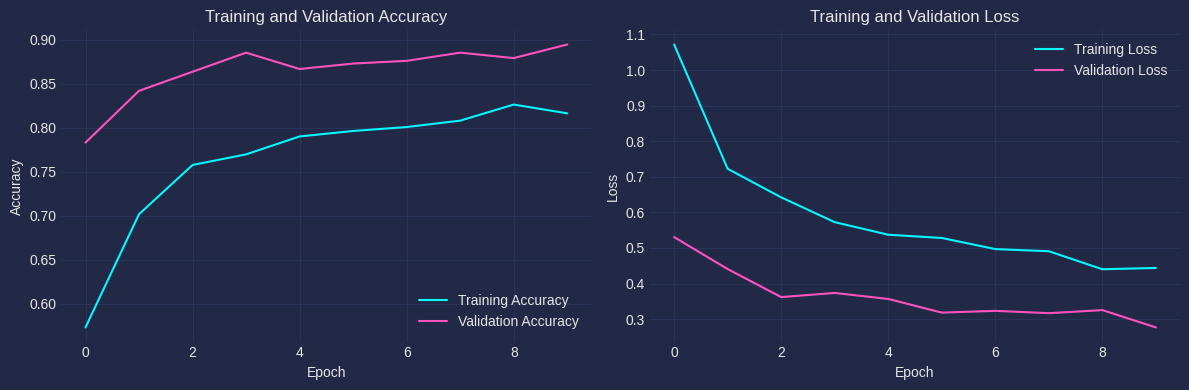

11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 653ms/step
Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.99      0.72      0.84        98
        no_tumor       0.92      0.98      0.95        48
meningioma_tumor       0.79      0.96      0.86        90
 pituitary_tumor       0.93      0.98      0.96        87

        accuracy                           0.89       323
       macro avg       0.91      0.91      0.90       323
    weighted avg       0.91      0.89      0.89       323



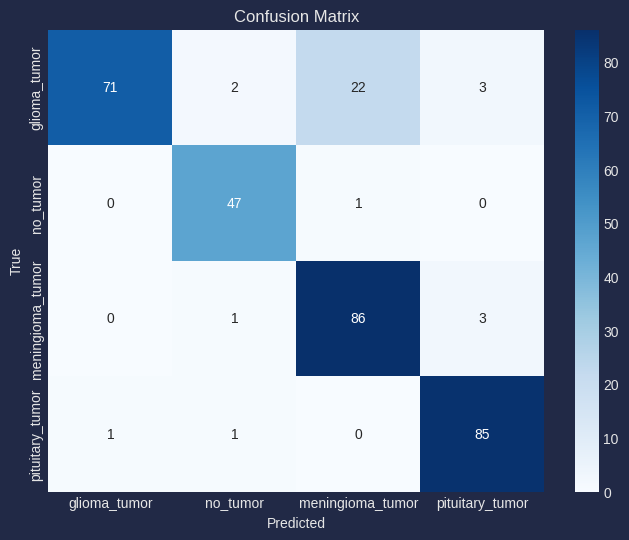

In [ ]:
# Gerekli kütüphaneler
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import tensorflow.keras.applications as applications

# EfficientNetB0 modelini tanımlama (basitleştirilmiş ve suboptimal)
def create_suboptimal_efficientnetb0_model(input_shape=(150, 150, 3), num_classes=4):
    # EfficientNetB0 modelini ImageNet ağırlıkları ile yüklüyoruz
    base_model = applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

    # Temel modeli tamamen eğitilemez yapıyoruz (fine-tuning yok)
    base_model.trainable = False

    # Daha basit ve kapasitesi düşük bir model
    model = Sequential([
        base_model,  # EfficientNetB0 temel model
        GlobalAveragePooling2D(),  # Özellikleri ortalama alarak küçült
        Dense(64, activation='relu'),  # Çok az nöronlu tek bir tam bağlantılı katman
        Dropout(0.6),  # Aşırı yüksek dropout oranı, öğrenmeyi zorlaştırır
        Dense(num_classes, activation='softmax')  # Çıkış katmanı (4 sınıf)
    ])

    return model

# Modeli oluştur
model = create_suboptimal_efficientnetb0_model()

# Model özetini yazdır
model.summary()

# Random değerler
learning_rate = 0.01
batch_size = 128
epochs = 10

# Modeli derleme
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',  # Çoklu sınıf problemi için
    metrics=['accuracy']  # Takip edilecek metrik
)

# Callbacks tanımlama (gevşetilmiş)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,  # Daha az sabır, erken durdurmayı hızlandırır
    restore_best_weights=False  # En iyi ağırlıkları geri yüklemiyoruz
)

checkpoint = ModelCheckpoint(
    'worst_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

# Modeli eğitme
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

# Eğitim sonuçlarını görselleştirme
plt.figure(figsize=(12, 4))

# Accuracy grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Test seti üzerinde tahmin yapma
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Sınıflandırma raporu
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=labels))

# Karışıklık matrisi
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Predicted label: meningioma_tumor 
Actual label: meningioma_tumor 
Confidence: 61.53%



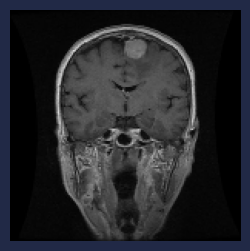

In [ ]:
# Test veri setinden rastgele bir görüntü alınıyor
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]

# Model bu görüntü için tahmin yapar (reshape işlemi modeli uygun boyuta getirmek içindir)
predictions = model.predict(random_img.reshape(1, 150, 150, 3))

# Tahmin edilen sınıf ve güven skoru
predicted_class = np.argmax(predictions)  # En yüksek olasılığa sahip sınıf
predicted_label = labels[predicted_class]
confidence = predictions[0][predicted_class]  # Güven oranı (% olarak ifade edilecek)

# Gerçek sınıf bilgisi
actual_index = y_test[random_index]  # One-hot encoded formda
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

# Sonuçlar ekrana yazdırılır
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")

# Görüntü ekrana çizilir
plt.figure(figsize=(3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted label: pituitary_tumor 
Actual label: glioma_tumor 
Confidence: 38.26%



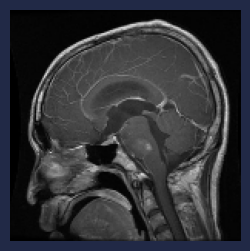

In [ ]:
# Test veri setinden rastgele bir görüntü alınıyor
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]

# Model bu görüntü için tahmin yapar (reshape işlemi modeli uygun boyuta getirmek içindir)
predictions = model.predict(random_img.reshape(1, 150, 150, 3))

# Tahmin edilen sınıf ve güven skoru
predicted_class = np.argmax(predictions)  # En yüksek olasılığa sahip sınıf
predicted_label = labels[predicted_class]
confidence = predictions[0][predicted_class]  # Güven oranı (% olarak ifade edilecek)

# Gerçek sınıf bilgisi
actual_index = y_test[random_index]  # One-hot encoded formda
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

# Sonuçlar ekrana yazdırılır
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")

# Görüntü ekrana çizilir
plt.figure(figsize=(3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()


# **Optuna ile HPO lu EfficientNetB0(Accuracy)**



[I 2025-04-23 11:33:15,544] A new study created in memory with name: efficientnetb0_accuracy
<ipython-input-19-1afe49a8aad0>:45: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-19-1afe49a8aad0>:48: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-19-1afe49a8aad0>:49: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout2_rate = trial.suggest_uniform("dropout2_rate", 0.2, 0.5)


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 48s 271ms/step - accuracy: 0.2781 - loss: 1.8676 - val_accuracy: 0.5851 - val_loss: 1.1786 - learning_rate: 3.3909e-05
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4061 - loss: 1.4688 - val_accuracy: 0.7121 - val_loss: 0.9647 - learning_rate: 3.3909e-05
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4917 - loss: 1.2365 - val_accuracy: 0.7740 - val_loss: 0.7865 - learning_rate: 3.3909e-05
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5656 - loss: 1.0704 - val_accuracy: 0.7926 - val_loss: 0.6579 - learning_rate: 3.3909e-05
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5851 - loss: 1.0090 - val_accuracy: 0.8111 - val_loss: 0.5727 - learning_rate: 3.3909e-05
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6380 - loss: 0.9003 - val_accuracy: 0.8235 - val_loss: 0.5194 - learning_rate: 3.3909e-05
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.669

[I 2025-04-23 11:34:15,551] Trial 0 finished with value: 0.8606811165809631 and parameters: {'learning_rate': 3.3908514411226114e-05, 'dense1_units': 256, 'dense2_units': 256, 'dropout1_rate': 0.43046301551956906, 'dropout2_rate': 0.41827401577027645, 'batch_size': 32}. Best is trial 0 with value: 0.8606811165809631.


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 65s 791ms/step - accuracy: 0.2637 - loss: 1.9183 - val_accuracy: 0.5480 - val_loss: 1.2097 - learning_rate: 4.6296e-05
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3820 - loss: 1.4993 - val_accuracy: 0.6471 - val_loss: 1.0474 - learning_rate: 4.6296e-05
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4898 - loss: 1.2374 - val_accuracy: 0.7059 - val_loss: 0.9150 - learning_rate: 4.6296e-05
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5440 - loss: 1.1512 - val_accuracy: 0.7616 - val_loss: 0.7992 - learning_rate: 4.6296e-05
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5832 - loss: 1.0260 - val_accuracy: 0.7926 - val_loss: 0.7086 - learning_rate: 4.6296e-05
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6348 - loss: 0.9264 - val_accuracy: 0.8173 - val_loss: 0.6320 - learning_rate: 4.6296e-05
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.644

[I 2025-04-23 11:35:31,158] Trial 1 finished with value: 0.8452012538909912 and parameters: {'learning_rate': 4.6295739152888374e-05, 'dense1_units': 320, 'dense2_units': 192, 'dropout1_rate': 0.42427661301374403, 'dropout2_rate': 0.42919879696957053, 'batch_size': 64}. Best is trial 0 with value: 0.8606811165809631.


Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 49s 125ms/step - accuracy: 0.6146 - loss: 1.2580 - val_accuracy: 0.8266 - val_loss: 0.4945 - learning_rate: 0.0025
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7853 - loss: 0.5811 - val_accuracy: 0.8731 - val_loss: 0.3271 - learning_rate: 0.0025
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8247 - loss: 0.4666 - val_accuracy: 0.8793 - val_loss: 0.3148 - learning_rate: 0.0025
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8372 - loss: 0.4609 - val_accuracy: 0.8978 - val_loss: 0.2639 - learning_rate: 0.0025
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8570 - loss: 0.3702 - val_accuracy: 0.8854 - val_loss: 0.2553 - learning_rate: 0.0025
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8818 - loss: 0.3349 - val_accuracy: 0.8607 - val_loss: 0.3073 - learning_rate: 0.0025
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8619 - loss: 0.36

[I 2025-04-23 11:36:39,037] Trial 2 finished with value: 0.9164086580276489 and parameters: {'learning_rate': 0.002539038766434611, 'dense1_units': 256, 'dense2_units': 192, 'dropout1_rate': 0.3835713769859239, 'dropout2_rate': 0.2864832185225503, 'batch_size': 16}. Best is trial 2 with value: 0.9164086580276489.


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 43s 481ms/step - accuracy: 0.3155 - loss: 1.5794 - val_accuracy: 0.7214 - val_loss: 1.0625 - learning_rate: 1.5504e-04
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6316 - loss: 0.9333 - val_accuracy: 0.7957 - val_loss: 0.8418 - learning_rate: 1.5504e-04
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7219 - loss: 0.7094 - val_accuracy: 0.8204 - val_loss: 0.6872 - learning_rate: 1.5504e-04
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7608 - loss: 0.6032 - val_accuracy: 0.8328 - val_loss: 0.5743 - learning_rate: 1.5504e-04
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7993 - loss: 0.5365 - val_accuracy: 0.8514 - val_loss: 0.4890 - learning_rate: 1.5504e-04
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8000 - loss: 0.5157 - val_accuracy: 0.8514 - val_loss: 0.4316 - learning_rate: 1.5504e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.833

[I 2025-04-23 11:37:32,219] Trial 3 finished with value: 0.8978328108787537 and parameters: {'learning_rate': 0.00015503690952646204, 'dense1_units': 128, 'dense2_units': 128, 'dropout1_rate': 0.2596204373995375, 'dropout2_rate': 0.2060372747153174, 'batch_size': 64}. Best is trial 2 with value: 0.9164086580276489.


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 50s 248ms/step - accuracy: 0.3102 - loss: 1.8085 - val_accuracy: 0.6130 - val_loss: 1.1366 - learning_rate: 2.5880e-05
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4583 - loss: 1.3055 - val_accuracy: 0.7183 - val_loss: 0.8979 - learning_rate: 2.5880e-05
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5735 - loss: 1.0433 - val_accuracy: 0.7709 - val_loss: 0.7186 - learning_rate: 2.5880e-05
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6282 - loss: 0.9207 - val_accuracy: 0.7895 - val_loss: 0.6079 - learning_rate: 2.5880e-05
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6555 - loss: 0.8586 - val_accuracy: 0.8111 - val_loss: 0.5349 - learning_rate: 2.5880e-05
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6868 - loss: 0.8019 - val_accuracy: 0.8204 - val_loss: 0.4937 - learning_rate: 2.5880e-05
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.743

[I 2025-04-23 11:38:35,228] Trial 4 finished with value: 0.8544891476631165 and parameters: {'learning_rate': 2.588040416860802e-05, 'dense1_units': 512, 'dense2_units': 192, 'dropout1_rate': 0.41847651152402465, 'dropout2_rate': 0.28472327163951494, 'batch_size': 32}. Best is trial 2 with value: 0.9164086580276489.


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 43s 250ms/step - accuracy: 0.4876 - loss: 1.3708 - val_accuracy: 0.8328 - val_loss: 0.6466 - learning_rate: 6.1338e-04
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7361 - loss: 0.7045 - val_accuracy: 0.8576 - val_loss: 0.4369 - learning_rate: 6.1338e-04
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7949 - loss: 0.5317 - val_accuracy: 0.8824 - val_loss: 0.3527 - learning_rate: 6.1338e-04
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8344 - loss: 0.4166 - val_accuracy: 0.8854 - val_loss: 0.3047 - learning_rate: 6.1338e-04
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8544 - loss: 0.3740 - val_accuracy: 0.9040 - val_loss: 0.2624 - learning_rate: 6.1338e-04
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8742 - loss: 0.3388 - val_accuracy: 0.9009 - val_loss: 0.2490 - learning_rate: 6.1338e-04
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.882

[I 2025-04-23 11:39:31,758] Trial 5 finished with value: 0.9287925958633423 and parameters: {'learning_rate': 0.0006133778237698747, 'dense1_units': 192, 'dense2_units': 128, 'dropout1_rate': 0.34744258722998855, 'dropout2_rate': 0.4645112906351949, 'batch_size': 32}. Best is trial 5 with value: 0.9287925958633423.


Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 44s 130ms/step - accuracy: 0.6169 - loss: 1.2507 - val_accuracy: 0.7957 - val_loss: 0.5644 - learning_rate: 0.0035
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7769 - loss: 0.6068 - val_accuracy: 0.7895 - val_loss: 0.5137 - learning_rate: 0.0035
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7896 - loss: 0.5579 - val_accuracy: 0.8762 - val_loss: 0.3661 - learning_rate: 0.0035
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8060 - loss: 0.5152 - val_accuracy: 0.8793 - val_loss: 0.3238 - learning_rate: 0.0035
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8472 - loss: 0.4524 - val_accuracy: 0.8978 - val_loss: 0.3025 - learning_rate: 0.0035
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8517 - loss: 0.3985 - val_accuracy: 0.8824 - val_loss: 0.2860 - learning_rate: 0.0035
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8673 - loss: 0.3

[I 2025-04-23 11:40:35,086] Trial 6 finished with value: 0.9071207642555237 and parameters: {'learning_rate': 0.0034677709898778223, 'dense1_units': 448, 'dense2_units': 64, 'dropout1_rate': 0.3314710433336324, 'dropout2_rate': 0.2796766598864052, 'batch_size': 16}. Best is trial 5 with value: 0.9287925958633423.


Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 42s 122ms/step - accuracy: 0.6014 - loss: 1.1726 - val_accuracy: 0.8266 - val_loss: 0.5279 - learning_rate: 0.0026
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7799 - loss: 0.6090 - val_accuracy: 0.8452 - val_loss: 0.4045 - learning_rate: 0.0026
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8411 - loss: 0.4297 - val_accuracy: 0.8700 - val_loss: 0.3818 - learning_rate: 0.0026
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8716 - loss: 0.3752 - val_accuracy: 0.8885 - val_loss: 0.2901 - learning_rate: 0.0026
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8718 - loss: 0.3406 - val_accuracy: 0.8978 - val_loss: 0.2437 - learning_rate: 0.0026
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8697 - loss: 0.3309 - val_accuracy: 0.9040 - val_loss: 0.2461 - learning_rate: 0.0026
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8888 - loss: 0.2

[I 2025-04-23 11:41:36,819] Trial 7 finished with value: 0.925696611404419 and parameters: {'learning_rate': 0.0026454508301339635, 'dense1_units': 128, 'dense2_units': 64, 'dropout1_rate': 0.21085460485307098, 'dropout2_rate': 0.29262351570404366, 'batch_size': 16}. Best is trial 5 with value: 0.9287925958633423.


Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 42s 121ms/step - accuracy: 0.2800 - loss: 2.0120 - val_accuracy: 0.6130 - val_loss: 1.0770 - learning_rate: 2.2696e-05
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4248 - loss: 1.5019 - val_accuracy: 0.7399 - val_loss: 0.7961 - learning_rate: 2.2696e-05
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5051 - loss: 1.2346 - val_accuracy: 0.7802 - val_loss: 0.6376 - learning_rate: 2.2696e-05
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5937 - loss: 1.0416 - val_accuracy: 0.7988 - val_loss: 0.5595 - learning_rate: 2.2696e-05
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6352 - loss: 0.9538 - val_accuracy: 0.8111 - val_loss: 0.5123 - learning_rate: 2.2696e-05
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6638 - loss: 0.8566 - val_accuracy: 0.8173 - val_loss: 0.4784 - learning_rate: 2.2696e-05
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accu

[I 2025-04-23 11:42:38,246] Trial 8 finished with value: 0.8452012538909912 and parameters: {'learning_rate': 2.2696475948548403e-05, 'dense1_units': 320, 'dense2_units': 192, 'dropout1_rate': 0.293128045979205, 'dropout2_rate': 0.4797328675583798, 'batch_size': 16}. Best is trial 5 with value: 0.9287925958633423.


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 46s 541ms/step - accuracy: 0.6152 - loss: 1.5221 - val_accuracy: 0.7957 - val_loss: 0.7359 - learning_rate: 0.0058
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7904 - loss: 0.5685 - val_accuracy: 0.8483 - val_loss: 0.4535 - learning_rate: 0.0058
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8306 - loss: 0.4564 - val_accuracy: 0.8607 - val_loss: 0.4140 - learning_rate: 0.0058
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8666 - loss: 0.3467 - val_accuracy: 0.8607 - val_loss: 0.3950 - learning_rate: 0.0058
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8894 - loss: 0.3035 - val_accuracy: 0.8762 - val_loss: 0.3059 - learning_rate: 0.0058
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8984 - loss: 0.2961 - val_accuracy: 0.8669 - val_loss: 0.3362 - learning_rate: 0.0058
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8620 - loss: 0.4056 - val_a

[I 2025-04-23 11:43:34,345] Trial 9 finished with value: 0.9102166891098022 and parameters: {'learning_rate': 0.0058045745634772725, 'dense1_units': 448, 'dense2_units': 224, 'dropout1_rate': 0.2989008795457814, 'dropout2_rate': 0.3910180276079098, 'batch_size': 64}. Best is trial 5 with value: 0.9287925958633423.


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 39s 216ms/step - accuracy: 0.4389 - loss: 1.6054 - val_accuracy: 0.8204 - val_loss: 0.6870 - learning_rate: 5.0856e-04
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6924 - loss: 0.8158 - val_accuracy: 0.8390 - val_loss: 0.4995 - learning_rate: 5.0856e-04
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7521 - loss: 0.6443 - val_accuracy: 0.8731 - val_loss: 0.4107 - learning_rate: 5.0856e-04
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7728 - loss: 0.5646 - val_accuracy: 0.8607 - val_loss: 0.3439 - learning_rate: 5.0856e-04
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7925 - loss: 0.5196 - val_accuracy: 0.8824 - val_loss: 0.3038 - learning_rate: 5.0856e-04
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8317 - loss: 0.4429 - val_accuracy: 0.8854 - val_loss: 0.2832 - learning_rate: 5.0856e-04
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.841

[I 2025-04-23 11:44:27,091] Trial 10 finished with value: 0.9071207642555237 and parameters: {'learning_rate': 0.0005085593178735283, 'dense1_units': 192, 'dense2_units': 128, 'dropout1_rate': 0.47180647566794076, 'dropout2_rate': 0.4961785537290344, 'batch_size': 32}. Best is trial 5 with value: 0.9287925958633423.


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 41s 233ms/step - accuracy: 0.5566 - loss: 1.0797 - val_accuracy: 0.8421 - val_loss: 0.6278 - learning_rate: 8.7527e-04
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8034 - loss: 0.5186 - val_accuracy: 0.8824 - val_loss: 0.4012 - learning_rate: 8.7527e-04
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8555 - loss: 0.3842 - val_accuracy: 0.8762 - val_loss: 0.3092 - learning_rate: 8.7527e-04
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8814 - loss: 0.3301 - val_accuracy: 0.9102 - val_loss: 0.2516 - learning_rate: 8.7527e-04
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8943 - loss: 0.2802 - val_accuracy: 0.9226 - val_loss: 0.2030 - learning_rate: 8.7527e-04
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8929 - loss: 0.2813 - val_accuracy: 0.9009 - val_loss: 0.2107 - learning_rate: 8.7527e-04
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.905

[I 2025-04-23 11:45:21,787] Trial 11 finished with value: 0.9226006269454956 and parameters: {'learning_rate': 0.0008752660091291678, 'dense1_units': 128, 'dense2_units': 64, 'dropout1_rate': 0.22888873149266958, 'dropout2_rate': 0.34528531358251174, 'batch_size': 32}. Best is trial 5 with value: 0.9287925958633423.


Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 43s 124ms/step - accuracy: 0.5981 - loss: 1.0764 - val_accuracy: 0.8607 - val_loss: 0.4472 - learning_rate: 0.0015
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7996 - loss: 0.5396 - val_accuracy: 0.8793 - val_loss: 0.3442 - learning_rate: 0.0015
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8331 - loss: 0.4215 - val_accuracy: 0.9040 - val_loss: 0.2642 - learning_rate: 0.0015
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8676 - loss: 0.3625 - val_accuracy: 0.8885 - val_loss: 0.2717 - learning_rate: 0.0015
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8861 - loss: 0.3226 - val_accuracy: 0.9040 - val_loss: 0.2439 - learning_rate: 0.0015
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8964 - loss: 0.3016 - val_accuracy: 0.8885 - val_loss: 0.2519 - learning_rate: 0.0015
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8886 - loss: 0.31

[I 2025-04-23 11:46:23,894] Trial 12 finished with value: 0.9133126735687256 and parameters: {'learning_rate': 0.0014668281722848477, 'dense1_units': 192, 'dense2_units': 96, 'dropout1_rate': 0.21013124701695757, 'dropout2_rate': 0.34124292883385016, 'batch_size': 16}. Best is trial 5 with value: 0.9287925958633423.


Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step - accuracy: 0.3992 - loss: 1.4622 - val_accuracy: 0.7802 - val_loss: 0.7293 - learning_rate: 2.0542e-04
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6846 - loss: 0.7963 - val_accuracy: 0.8235 - val_loss: 0.4794 - learning_rate: 2.0542e-04
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7207 - loss: 0.7023 - val_accuracy: 0.8359 - val_loss: 0.3994 - learning_rate: 2.0542e-04
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7789 - loss: 0.5798 - val_accuracy: 0.8762 - val_loss: 0.3412 - learning_rate: 2.0542e-04
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7956 - loss: 0.5347 - val_accuracy: 0.8793 - val_loss: 0.3243 - learning_rate: 2.0542e-04
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8181 - loss: 0.4640 - val_accuracy: 0.8762 - val_loss: 0.2922 - learning_rate: 2.0542e-04
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accura

[I 2025-04-23 11:47:24,539] Trial 13 finished with value: 0.9040247797966003 and parameters: {'learning_rate': 0.00020541504522087346, 'dense1_units': 128, 'dense2_units': 128, 'dropout1_rate': 0.3504671589789784, 'dropout2_rate': 0.3194006621898351, 'batch_size': 16}. Best is trial 5 with value: 0.9287925958633423.


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 42s 239ms/step - accuracy: 0.5897 - loss: 1.4189 - val_accuracy: 0.7895 - val_loss: 0.6364 - learning_rate: 0.0092
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7603 - loss: 0.6098 - val_accuracy: 0.8483 - val_loss: 0.4840 - learning_rate: 0.0092
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8115 - loss: 0.4992 - val_accuracy: 0.8452 - val_loss: 0.3999 - learning_rate: 0.0092
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8295 - loss: 0.4570 - val_accuracy: 0.8545 - val_loss: 0.3908 - learning_rate: 0.0092
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8515 - loss: 0.4196 - val_accuracy: 0.8638 - val_loss: 0.3674 - learning_rate: 0.0092
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8666 - loss: 0.3809 - val_accuracy: 0.8793 - val_loss: 0.3643 - learning_rate: 0.0092
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8429 - loss: 0.4453 - val_a

[I 2025-04-23 11:48:20,038] Trial 14 finished with value: 0.8978328108787537 and parameters: {'learning_rate': 0.009180660649835356, 'dense1_units': 192, 'dense2_units': 96, 'dropout1_rate': 0.2595048390513798, 'dropout2_rate': 0.22967217943476342, 'batch_size': 32}. Best is trial 5 with value: 0.9287925958633423.


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 42s 242ms/step - accuracy: 0.5021 - loss: 1.3460 - val_accuracy: 0.8266 - val_loss: 0.6495 - learning_rate: 4.6280e-04
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7441 - loss: 0.6390 - val_accuracy: 0.8638 - val_loss: 0.4553 - learning_rate: 4.6280e-04
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7920 - loss: 0.5216 - val_accuracy: 0.8669 - val_loss: 0.3568 - learning_rate: 4.6280e-04
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8314 - loss: 0.4227 - val_accuracy: 0.8916 - val_loss: 0.2798 - learning_rate: 4.6280e-04
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8449 - loss: 0.4027 - val_accuracy: 0.9009 - val_loss: 0.2500 - learning_rate: 4.6280e-04
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8737 - loss: 0.3131 - val_accuracy: 0.9102 - val_loss: 0.2329 - learning_rate: 4.6280e-04
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.895

[I 2025-04-23 11:49:15,489] Trial 15 finished with value: 0.9164086580276489 and parameters: {'learning_rate': 0.0004627989175739085, 'dense1_units': 256, 'dense2_units': 96, 'dropout1_rate': 0.3606094134759268, 'dropout2_rate': 0.38842248805560203, 'batch_size': 32}. Best is trial 5 with value: 0.9287925958633423.


Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 44s 130ms/step - accuracy: 0.3551 - loss: 1.8120 - val_accuracy: 0.7833 - val_loss: 0.7392 - learning_rate: 1.2129e-04
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5717 - loss: 1.0681 - val_accuracy: 0.8297 - val_loss: 0.4957 - learning_rate: 1.2129e-04
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6676 - loss: 0.8638 - val_accuracy: 0.8638 - val_loss: 0.4076 - learning_rate: 1.2129e-04
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7011 - loss: 0.7820 - val_accuracy: 0.8545 - val_loss: 0.3842 - learning_rate: 1.2129e-04
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7547 - loss: 0.6503 - val_accuracy: 0.8700 - val_loss: 0.3606 - learning_rate: 1.2129e-04
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7713 - loss: 0.5892 - val_accuracy: 0.8638 - val_loss: 0.3388 - learning_rate: 1.2129e-04
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - a

[I 2025-04-23 11:50:20,482] Trial 16 finished with value: 0.8854489326477051 and parameters: {'learning_rate': 0.00012128959126493164, 'dense1_units': 320, 'dense2_units': 160, 'dropout1_rate': 0.4938636945954634, 'dropout2_rate': 0.457334362371553, 'batch_size': 16}. Best is trial 5 with value: 0.9287925958633423.


Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 42s 121ms/step - accuracy: 0.5794 - loss: 1.1224 - val_accuracy: 0.8390 - val_loss: 0.4745 - learning_rate: 0.0014
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7753 - loss: 0.5633 - val_accuracy: 0.8793 - val_loss: 0.3214 - learning_rate: 0.0014
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8227 - loss: 0.4378 - val_accuracy: 0.8885 - val_loss: 0.2992 - learning_rate: 0.0014
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8666 - loss: 0.3462 - val_accuracy: 0.8793 - val_loss: 0.2724 - learning_rate: 0.0014
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8603 - loss: 0.3512 - val_accuracy: 0.8885 - val_loss: 0.2770 - learning_rate: 0.0014
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8859 - loss: 0.3027 - val_accuracy: 0.9040 - val_loss: 0.2279 - learning_rate: 0.0014
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8959 - loss: 0.2625

[I 2025-04-23 11:51:22,281] Trial 17 finished with value: 0.9071207642555237 and parameters: {'learning_rate': 0.0013604347120005102, 'dense1_units': 192, 'dense2_units': 64, 'dropout1_rate': 0.30079175905053696, 'dropout2_rate': 0.249991740454371, 'batch_size': 16}. Best is trial 5 with value: 0.9287925958633423.


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 43s 247ms/step - accuracy: 0.3041 - loss: 1.6020 - val_accuracy: 0.5975 - val_loss: 1.1317 - learning_rate: 7.2286e-05
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5123 - loss: 1.1711 - val_accuracy: 0.7214 - val_loss: 0.8881 - learning_rate: 7.2286e-05
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6139 - loss: 0.9371 - val_accuracy: 0.7492 - val_loss: 0.6949 - learning_rate: 7.2286e-05
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6714 - loss: 0.8033 - val_accuracy: 0.7864 - val_loss: 0.5760 - learning_rate: 7.2286e-05
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7085 - loss: 0.7427 - val_accuracy: 0.8080 - val_loss: 0.5049 - learning_rate: 7.2286e-05
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7308 - loss: 0.6946 - val_accuracy: 0.8390 - val_loss: 0.4543 - learning_rate: 7.2286e-05
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.754

[I 2025-04-23 11:52:19,956] Trial 18 finished with value: 0.8606811165809631 and parameters: {'learning_rate': 7.228581888200801e-05, 'dense1_units': 128, 'dense2_units': 160, 'dropout1_rate': 0.2459265023714425, 'dropout2_rate': 0.37602609754073324, 'batch_size': 32}. Best is trial 5 with value: 0.9287925958633423.


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 43s 497ms/step - accuracy: 0.2264 - loss: 2.1466 - val_accuracy: 0.2941 - val_loss: 1.3470 - learning_rate: 1.2219e-05
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2837 - loss: 1.8732 - val_accuracy: 0.4520 - val_loss: 1.2500 - learning_rate: 1.2219e-05
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3466 - loss: 1.6566 - val_accuracy: 0.5449 - val_loss: 1.1599 - learning_rate: 1.2219e-05
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3943 - loss: 1.4773 - val_accuracy: 0.6285 - val_loss: 1.0756 - learning_rate: 1.2219e-05
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4653 - loss: 1.3337 - val_accuracy: 0.6594 - val_loss: 0.9959 - learning_rate: 1.2219e-05
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4807 - loss: 1.2834 - val_accuracy: 0.6873 - val_loss: 0.9222 - learning_rate: 1.2219e-05
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.509

[I 2025-04-23 11:53:14,955] Trial 19 finished with value: 0.7461300492286682 and parameters: {'learning_rate': 1.221890684055508e-05, 'dense1_units': 384, 'dense2_units': 96, 'dropout1_rate': 0.37973828663008996, 'dropout2_rate': 0.31805228579749417, 'batch_size': 64}. Best is trial 5 with value: 0.9287925958633423.



=== Optimizasyon Sonuçları ===
En iyi hiperparametreler:  {'learning_rate': 0.0006133778237698747, 'dense1_units': 192, 'dense2_units': 128, 'dropout1_rate': 0.34744258722998855, 'dropout2_rate': 0.4645112906351949, 'batch_size': 32}
En iyi validation accuracy:  0.9287925958633423
En iyi trial numarası:  5
Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.5083 - loss: 1.3021

91/91 ━━━━━━━━━━━━━━━━━━━━ 41s 227ms/step - accuracy: 0.5094 - loss: 1.2992 - val_accuracy: 0.8483 - val_loss: 0.6489 - learning_rate: 6.1338e-04
Epoch 2/20
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7482 - loss: 0.6583

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7484 - loss: 0.6573 - val_accuracy: 0.8700 - val_loss: 0.4479 - learning_rate: 6.1338e-04
Epoch 3/20
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8094 - loss: 0.4929

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8093 - loss: 0.4938 - val_accuracy: 0.8731 - val_loss: 0.3487 - learning_rate: 6.1338e-04
Epoch 4/20
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8432 - loss: 0.4107

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8436 - loss: 0.4100 - val_accuracy: 0.9133 - val_loss: 0.2777 - learning_rate: 6.1338e-04
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8635 - loss: 0.3547 - val_accuracy: 0.8978 - val_loss: 0.2412 - learning_rate: 6.1338e-04
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8754 - loss: 0.3515 - val_accuracy: 0.8978 - val_loss: 0.2395 - learning_rate: 6.1338e-04
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8911 - loss: 0.2917 - val_accuracy: 0.9040 - val_loss: 0.2179 - learning_rate: 6.1338e-04
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9051 - loss: 0.2421 - val_accuracy: 0.9040 - val_loss: 0.2200 - learning_rate: 6.1338e-04
Epoch 9/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9162 - loss: 0.2102 - val_accuracy: 0.8947 - val_loss: 0.2226 - learning_rate: 6.1338e-04
Epoch 10/20
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9212 - loss: 0.2

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9207 - loss: 0.2250 - val_accuracy: 0.9226 - val_loss: 0.2003 - learning_rate: 6.1338e-04
Epoch 11/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9255 - loss: 0.2193 - val_accuracy: 0.9164 - val_loss: 0.2163 - learning_rate: 6.1338e-04
Epoch 12/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9268 - loss: 0.2133 - val_accuracy: 0.9102 - val_loss: 0.2142 - learning_rate: 6.1338e-04
Epoch 13/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9265 - loss: 0.1985 - val_accuracy: 0.9040 - val_loss: 0.2129 - learning_rate: 6.1338e-04
Epoch 14/20
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9388 - loss: 0.1703

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9389 - loss: 0.1692 - val_accuracy: 0.9288 - val_loss: 0.1955 - learning_rate: 1.2268e-04
Epoch 15/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9490 - loss: 0.1463 - val_accuracy: 0.9288 - val_loss: 0.1830 - learning_rate: 1.2268e-04
Epoch 16/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9412 - loss: 0.1441 - val_accuracy: 0.9257 - val_loss: 0.1848 - learning_rate: 1.2268e-04
Epoch 17/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9457 - loss: 0.1495 - val_accuracy: 0.9257 - val_loss: 0.1755 - learning_rate: 1.2268e-04
Epoch 18/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9477 - loss: 0.1483 - val_accuracy: 0.9257 - val_loss: 0.1783 - learning_rate: 1.2268e-04
Epoch 19/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9551 - loss: 0.1132 - val_accuracy: 0.9226 - val_loss: 0.1748 - learning_rate: 1.2268e-04
Epoch 20/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9606 - los

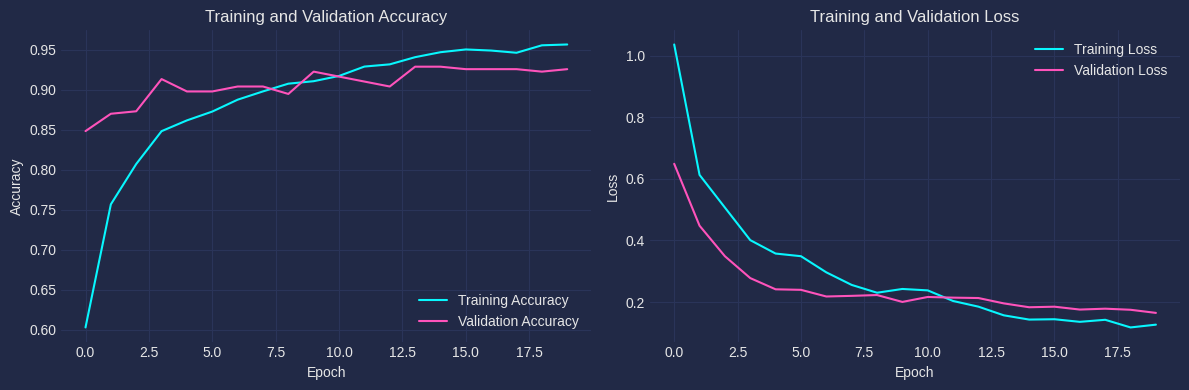

11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 604ms/step
Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.91      0.90      0.90        98
        no_tumor       0.96      1.00      0.98        48
meningioma_tumor       0.93      0.86      0.89        90
 pituitary_tumor       0.92      0.99      0.96        87

        accuracy                           0.93       323
       macro avg       0.93      0.94      0.93       323
    weighted avg       0.93      0.93      0.92       323



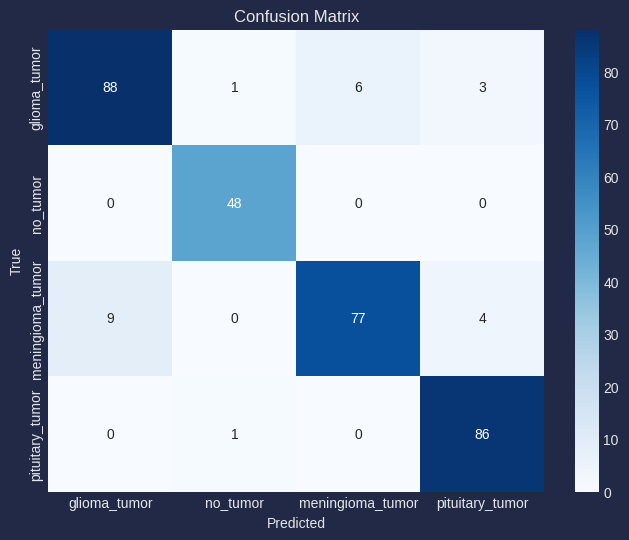

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import tensorflow.keras.applications as applications
import optuna

# EfficientNetB0 modelini tanımlama
def create_efficientnetb0_model(input_shape=(150, 150, 3), num_classes=4, dense1_units=256, dense2_units=128, dropout1_rate=0.4, dropout2_rate=0.3):
    # EfficientNetB0 modelini ImageNet ağırlıkları ile yüklüyoruz
    base_model = applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

    # İlk etapta temel modeli eğitilebilir yapmıyoruz (transfer öğrenme için)
    base_model.trainable = False

    # Modeli oluşturuyoruz
    model = Sequential([
        base_model,  # EfficientNetB0 temel model
        GlobalAveragePooling2D(),  # Özellikleri ortalama alarak küçült
        BatchNormalization(),  # Normalizasyon
        Dense(dense1_units, activation='relu'),  # İlk tam bağlantılı katman
        Dropout(dropout1_rate),  # İlk dropout
        Dense(dense2_units, activation='relu'),  # İkinci tam bağlantılı katman
        Dropout(dropout2_rate),  # İkinci dropout
        Dense(num_classes, activation='softmax')  # Çıkış katmanı (4 sınıf)
    ])

    return model

# Optuna objective fonksiyonu
def objective(trial):
    # Hiperparametre aralıklarını tanımlama
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    dense1_units = trial.suggest_int("dense1_units", 128, 512, step=64)
    dense2_units = trial.suggest_int("dense2_units", 64, 256, step=32)
    dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
    dropout2_rate = trial.suggest_uniform("dropout2_rate", 0.2, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # Modeli oluştur
    model = create_efficientnetb0_model(
        dense1_units=dense1_units,
        dense2_units=dense2_units,
        dropout1_rate=dropout1_rate,
        dropout2_rate=dropout2_rate
    )

    # Modeli derle
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6
    )

    # Modeli eğit
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=10,  # Daha kısa süre için epoch sayısı azaltıldı
        batch_size=batch_size,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # En iyi doğrulama doğruluğunu döndür
    val_accuracy = max(history.history['val_accuracy'])

    # Belleği temizle
    tf.keras.backend.clear_session()

    return val_accuracy

# Optuna optimizasyonunu çalıştır
study = optuna.create_study(direction="maximize", study_name="efficientnetb0_accuracy")
study.optimize(objective, n_trials=20)

# En iyi hiperparametreleri yazdır
print("\n=== Optimizasyon Sonuçları ===")
print("En iyi hiperparametreler: ", study.best_params)
print("En iyi validation accuracy: ", study.best_value)
print("En iyi trial numarası: ", study.best_trial.number)

# En iyi hiperparametrelerle modeli tekrar eğit
best_params = study.best_params
best_model = create_efficientnetb0_model(
    dense1_units=best_params['dense1_units'],
    dense2_units=best_params['dense2_units'],
    dropout1_rate=best_params['dropout1_rate'],
    dropout2_rate=best_params['dropout2_rate']
)

# Modeli derle
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint = ModelCheckpoint(
    'best_model_optuna.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# En iyi modelle eğitimi tekrar yap
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Eğitim sonuçlarını görselleştirme
plt.figure(figsize=(12, 4))

# Accuracy grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Test seti üzerinde tahmin yapma
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Sınıflandırma raporu
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=labels))

# Karışıklık matrisi
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
Predicted label: glioma_tumor 
Actual label: glioma_tumor 
Confidence: 100.00%



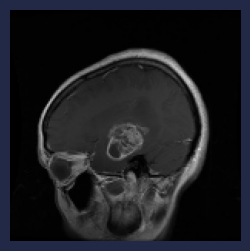

In [ ]:
# Test veri setinden rastgele bir görüntü alınıyor
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]

# Model bu görüntü için tahmin yapar (reshape işlemi modeli uygun boyuta getirmek içindir)
predictions = model.predict(random_img.reshape(1, 150, 150, 3))

# Tahmin edilen sınıf ve güven skoru
predicted_class = np.argmax(predictions)  # En yüksek olasılığa sahip sınıf
predicted_label = labels[predicted_class]
confidence = predictions[0][predicted_class]  # Güven oranı (% olarak ifade edilecek)

# Gerçek sınıf bilgisi
actual_index = y_test[random_index]  # One-hot encoded formda
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

# Sonuçlar ekrana yazdırılır
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")

# Görüntü ekrana çizilir
plt.figure(figsize=(3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted label: pituitary_tumor 
Actual label: pituitary_tumor 
Confidence: 100.00%



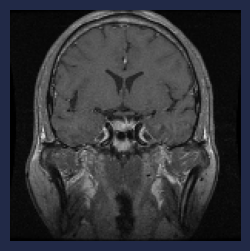

In [ ]:
# Test veri setinden rastgele bir görüntü alınıyor
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]

# Model bu görüntü için tahmin yapar (reshape işlemi modeli uygun boyuta getirmek içindir)
predictions = model.predict(random_img.reshape(1, 150, 150, 3))

# Tahmin edilen sınıf ve güven skoru
predicted_class = np.argmax(predictions)  # En yüksek olasılığa sahip sınıf
predicted_label = labels[predicted_class]
confidence = predictions[0][predicted_class]  # Güven oranı (% olarak ifade edilecek)

# Gerçek sınıf bilgisi
actual_index = y_test[random_index]  # One-hot encoded formda
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

# Sonuçlar ekrana yazdırılır
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")

# Görüntü ekrana çizilir
plt.figure(figsize=(3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted label: glioma_tumor 
Actual label: glioma_tumor 
Confidence: 100.00%



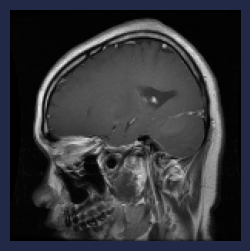

In [ ]:
# Test veri setinden rastgele bir görüntü alınıyor
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]

# Model bu görüntü için tahmin yapar (reshape işlemi modeli uygun boyuta getirmek içindir)
predictions = model.predict(random_img.reshape(1, 150, 150, 3))

# Tahmin edilen sınıf ve güven skoru
predicted_class = np.argmax(predictions)  # En yüksek olasılığa sahip sınıf
predicted_label = labels[predicted_class]
confidence = predictions[0][predicted_class]  # Güven oranı (% olarak ifade edilecek)

# Gerçek sınıf bilgisi
actual_index = y_test[random_index]  # One-hot encoded formda
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

# Sonuçlar ekrana yazdırılır
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")

# Görüntü ekrana çizilir
plt.figure(figsize=(3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()


# **Optuna ile HPO lu EfficientNetB0(F1)**

[I 2025-04-23 11:57:44,692] A new study created in memory with name: efficientnetb0_f1


GPU bulundu: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Optuna optimizasyonu başlıyor...

Trial 0 başladı:
Hiperparametreler: learning_rate=0.000579, dense1_units=512, dense2_units=64, dropout1_rate=0.20, dropout2_rate=0.38, batch_size=32


<ipython-input-31-6921fb51bcf4>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-31-6921fb51bcf4>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-31-6921fb51bcf4>:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout2_rate = trial.suggest_uniform("dropout2_rate", 0.2, 0.5)


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 42s 244ms/step - accuracy: 0.6045 - loss: 1.0679 - val_accuracy: 0.8142 - val_loss: 0.5911 - learning_rate: 5.7950e-04
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8109 - loss: 0.4955 - val_accuracy: 0.8824 - val_loss: 0.3798 - learning_rate: 5.7950e-04
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8552 - loss: 0.3826 - val_accuracy: 0.8885 - val_loss: 0.2985 - learning_rate: 5.7950e-04
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8943 - loss: 0.2963 - val_accuracy: 0.8885 - val_loss: 0.2739 - learning_rate: 5.7950e-04
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9079 - loss: 0.2472 - val_accuracy: 0.9102 - val_loss: 0.2341 - learning_rate: 5.7950e-04
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9274 - loss: 0.1995 - val_accuracy: 0.8916 - val_loss: 0.2665 - learning_rate: 5.7950e-04
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.925

[I 2025-04-23 11:58:51,823] Trial 0 finished with value: 0.9166663957949681 and parameters: {'learning_rate': 0.0005794987563282041, 'dense1_units': 512, 'dense2_units': 64, 'dropout1_rate': 0.20436360477792448, 'dropout2_rate': 0.3760395690052477, 'batch_size': 32}. Best is trial 0 with value: 0.9166663957949681.
<ipython-input-31-6921fb51bcf4>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-31-6921fb51bcf4>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-31-6921fb51bcf4>:57: FutureWarning: suggest_uniform has been depre


Trial 1 başladı:
Hiperparametreler: learning_rate=0.000386, dense1_units=448, dense2_units=64, dropout1_rate=0.24, dropout2_rate=0.36, batch_size=32
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 41s 230ms/step - accuracy: 0.5352 - loss: 1.2045 - val_accuracy: 0.8142 - val_loss: 0.6384 - learning_rate: 3.8572e-04
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7822 - loss: 0.5511 - val_accuracy: 0.8762 - val_loss: 0.4177 - learning_rate: 3.8572e-04
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8456 - loss: 0.4029 - val_accuracy: 0.8731 - val_loss: 0.3133 - learning_rate: 3.8572e-04
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8774 - loss: 0.3312 - val_accuracy: 0.8793 - val_loss: 0.2696 - learning_rate: 3.8572e-04
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8993 - loss: 0.2811 - val_accuracy: 0.9071 - val_loss: 0.2324 - learning_rate: 3.8572e-04
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8959 - l

[I 2025-04-23 11:59:59,175] Trial 1 finished with value: 0.9403982038579412 and parameters: {'learning_rate': 0.0003857241633283151, 'dense1_units': 448, 'dense2_units': 64, 'dropout1_rate': 0.2434147405811886, 'dropout2_rate': 0.3595734008226572, 'batch_size': 32}. Best is trial 1 with value: 0.9403982038579412.
<ipython-input-31-6921fb51bcf4>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-31-6921fb51bcf4>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-31-6921fb51bcf4>:57: FutureWarning: suggest_uniform has been deprec


Trial 2 başladı:
Hiperparametreler: learning_rate=0.000355, dense1_units=512, dense2_units=64, dropout1_rate=0.43, dropout2_rate=0.37, batch_size=16
Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 42s 122ms/step - accuracy: 0.5152 - loss: 1.2866 - val_accuracy: 0.8328 - val_loss: 0.5245 - learning_rate: 3.5529e-04
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7525 - loss: 0.6110 - val_accuracy: 0.8700 - val_loss: 0.3499 - learning_rate: 3.5529e-04
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7796 - loss: 0.5493 - val_accuracy: 0.9009 - val_loss: 0.3014 - learning_rate: 3.5529e-04
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8280 - loss: 0.4487 - val_accuracy: 0.9009 - val_loss: 0.2658 - learning_rate: 3.5529e-04
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8407 - loss: 0.4442 - val_accuracy: 0.9288 - val_loss: 0.2339 - learning_rate: 3.5529e-04
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8

[I 2025-04-23 12:01:13,471] Trial 2 finished with value: 0.9217287672644815 and parameters: {'learning_rate': 0.0003552890703931282, 'dense1_units': 512, 'dense2_units': 64, 'dropout1_rate': 0.4297497111080362, 'dropout2_rate': 0.36666689144080356, 'batch_size': 16}. Best is trial 1 with value: 0.9403982038579412.
<ipython-input-31-6921fb51bcf4>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-31-6921fb51bcf4>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-31-6921fb51bcf4>:57: FutureWarning: suggest_uniform has been depre


Trial 3 başladı:
Hiperparametreler: learning_rate=0.009669, dense1_units=192, dense2_units=192, dropout1_rate=0.34, dropout2_rate=0.49, batch_size=16
Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 42s 120ms/step - accuracy: 0.5659 - loss: 2.6894 - val_accuracy: 0.7647 - val_loss: 0.7025 - learning_rate: 0.0097
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7105 - loss: 0.8357 - val_accuracy: 0.8173 - val_loss: 0.5349 - learning_rate: 0.0097
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7293 - loss: 0.7906 - val_accuracy: 0.8328 - val_loss: 0.5205 - learning_rate: 0.0097
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7455 - loss: 0.7816 - val_accuracy: 0.8576 - val_loss: 0.4272 - learning_rate: 0.0097
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7078 - loss: 0.8845 - val_accuracy: 0.8142 - val_loss: 0.5853 - learning_rate: 0.0097
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6794 - loss: 0.9957 

[I 2025-04-23 12:02:28,809] Trial 3 finished with value: 0.8865240796355347 and parameters: {'learning_rate': 0.009668756368141454, 'dense1_units': 192, 'dense2_units': 192, 'dropout1_rate': 0.3418955716940366, 'dropout2_rate': 0.4869586469969331, 'batch_size': 16}. Best is trial 1 with value: 0.9403982038579412.
<ipython-input-31-6921fb51bcf4>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-31-6921fb51bcf4>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-31-6921fb51bcf4>:57: FutureWarning: suggest_uniform has been deprec


Trial 4 başladı:
Hiperparametreler: learning_rate=0.000162, dense1_units=448, dense2_units=96, dropout1_rate=0.25, dropout2_rate=0.27, batch_size=16
Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 42s 124ms/step - accuracy: 0.5045 - loss: 1.2183 - val_accuracy: 0.8328 - val_loss: 0.5684 - learning_rate: 1.6195e-04
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7764 - loss: 0.6043 - val_accuracy: 0.8483 - val_loss: 0.3843 - learning_rate: 1.6195e-04
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8246 - loss: 0.4573 - val_accuracy: 0.8576 - val_loss: 0.3265 - learning_rate: 1.6195e-04
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8528 - loss: 0.3930 - val_accuracy: 0.8669 - val_loss: 0.2868 - learning_rate: 1.6195e-04
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8559 - loss: 0.3653 - val_accuracy: 0.8793 - val_loss: 0.2649 - learning_rate: 1.6195e-04
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 

[I 2025-04-23 12:03:45,347] Trial 4 finished with value: 0.9175460472552343 and parameters: {'learning_rate': 0.00016194593556051633, 'dense1_units': 448, 'dense2_units': 96, 'dropout1_rate': 0.2494846805865683, 'dropout2_rate': 0.27289556564602907, 'batch_size': 16}. Best is trial 1 with value: 0.9403982038579412.
<ipython-input-31-6921fb51bcf4>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-31-6921fb51bcf4>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-31-6921fb51bcf4>:57: FutureWarning: suggest_uniform has been depr


Trial 5 başladı:
Hiperparametreler: learning_rate=0.002073, dense1_units=128, dense2_units=128, dropout1_rate=0.48, dropout2_rate=0.33, batch_size=64
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 39s 414ms/step - accuracy: 0.5413 - loss: 1.2306 - val_accuracy: 0.8173 - val_loss: 0.6410 - learning_rate: 0.0021
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7684 - loss: 0.6129 - val_accuracy: 0.8638 - val_loss: 0.5418 - learning_rate: 0.0021
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8120 - loss: 0.4997 - val_accuracy: 0.8824 - val_loss: 0.4243 - learning_rate: 0.0021
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8414 - loss: 0.4112 - val_accuracy: 0.8700 - val_loss: 0.3597 - learning_rate: 0.0021
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8754 - loss: 0.3364 - val_accuracy: 0.8947 - val_loss: 0.2973 - learning_rate: 0.0021
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8702 - loss: 0.3516 - val_a

[I 2025-04-23 12:04:48,798] Trial 5 finished with value: 0.9178431357876169 and parameters: {'learning_rate': 0.002072792395717761, 'dense1_units': 128, 'dense2_units': 128, 'dropout1_rate': 0.4806319335792252, 'dropout2_rate': 0.32807573503252485, 'batch_size': 64}. Best is trial 1 with value: 0.9403982038579412.
<ipython-input-31-6921fb51bcf4>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-31-6921fb51bcf4>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-31-6921fb51bcf4>:57: FutureWarning: suggest_uniform has been depre


Trial 6 başladı:
Hiperparametreler: learning_rate=0.002471, dense1_units=192, dense2_units=192, dropout1_rate=0.46, dropout2_rate=0.31, batch_size=16
Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 39s 106ms/step - accuracy: 0.5803 - loss: 1.2934 - val_accuracy: 0.8514 - val_loss: 0.5191 - learning_rate: 0.0025
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7808 - loss: 0.5668 - val_accuracy: 0.8576 - val_loss: 0.3810 - learning_rate: 0.0025
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8054 - loss: 0.5052 - val_accuracy: 0.8700 - val_loss: 0.3341 - learning_rate: 0.0025
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8461 - loss: 0.4102 - val_accuracy: 0.8731 - val_loss: 0.3143 - learning_rate: 0.0025
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8471 - loss: 0.4236 - val_accuracy: 0.8854 - val_loss: 0.3151 - learning_rate: 0.0025
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8556 - loss: 0.367

[I 2025-04-23 12:06:01,135] Trial 6 finished with value: 0.9116872922687613 and parameters: {'learning_rate': 0.002470906382334813, 'dense1_units': 192, 'dense2_units': 192, 'dropout1_rate': 0.4622362332480274, 'dropout2_rate': 0.3110694628028949, 'batch_size': 16}. Best is trial 1 with value: 0.9403982038579412.
<ipython-input-31-6921fb51bcf4>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-31-6921fb51bcf4>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-31-6921fb51bcf4>:57: FutureWarning: suggest_uniform has been deprec


Trial 7 başladı:
Hiperparametreler: learning_rate=0.003208, dense1_units=448, dense2_units=192, dropout1_rate=0.29, dropout2_rate=0.36, batch_size=16
Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 43s 125ms/step - accuracy: 0.5931 - loss: 1.4112 - val_accuracy: 0.8080 - val_loss: 0.4667 - learning_rate: 0.0032
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7465 - loss: 0.6428 - val_accuracy: 0.8576 - val_loss: 0.3551 - learning_rate: 0.0032
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8121 - loss: 0.5235 - val_accuracy: 0.8607 - val_loss: 0.3355 - learning_rate: 0.0032
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8341 - loss: 0.4644 - val_accuracy: 0.8824 - val_loss: 0.2835 - learning_rate: 0.0032
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8612 - loss: 0.4060 - val_accuracy: 0.8607 - val_loss: 0.3286 - learning_rate: 0.0032
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8506 - loss: 0.3959 

[I 2025-04-23 12:07:17,920] Trial 7 finished with value: 0.9270827099168113 and parameters: {'learning_rate': 0.0032077230520873704, 'dense1_units': 448, 'dense2_units': 192, 'dropout1_rate': 0.28772783902449545, 'dropout2_rate': 0.36200692674444274, 'batch_size': 16}. Best is trial 1 with value: 0.9403982038579412.
<ipython-input-31-6921fb51bcf4>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-31-6921fb51bcf4>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-31-6921fb51bcf4>:57: FutureWarning: suggest_uniform has been dep


Trial 8 başladı:
Hiperparametreler: learning_rate=0.000302, dense1_units=512, dense2_units=64, dropout1_rate=0.33, dropout2_rate=0.41, batch_size=16
Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step - accuracy: 0.5286 - loss: 1.2414 - val_accuracy: 0.8452 - val_loss: 0.5341 - learning_rate: 3.0217e-04
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7571 - loss: 0.6386 - val_accuracy: 0.8700 - val_loss: 0.3728 - learning_rate: 3.0217e-04
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8027 - loss: 0.5255 - val_accuracy: 0.8793 - val_loss: 0.3057 - learning_rate: 3.0217e-04
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8296 - loss: 0.4599 - val_accuracy: 0.8824 - val_loss: 0.2976 - learning_rate: 3.0217e-04
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8559 - loss: 0.3822 - val_accuracy: 0.8947 - val_loss: 0.2500 - learning_rate: 3.0217e-04
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.

[I 2025-04-23 12:08:31,225] Trial 8 finished with value: 0.9228814370855767 and parameters: {'learning_rate': 0.00030216910848537463, 'dense1_units': 512, 'dense2_units': 64, 'dropout1_rate': 0.32543472753532343, 'dropout2_rate': 0.41128946953764195, 'batch_size': 16}. Best is trial 1 with value: 0.9403982038579412.
<ipython-input-31-6921fb51bcf4>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-31-6921fb51bcf4>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-31-6921fb51bcf4>:57: FutureWarning: suggest_uniform has been dep


Trial 9 başladı:
Hiperparametreler: learning_rate=0.001291, dense1_units=128, dense2_units=192, dropout1_rate=0.40, dropout2_rate=0.41, batch_size=16
Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 41s 118ms/step - accuracy: 0.5686 - loss: 1.1251 - val_accuracy: 0.8204 - val_loss: 0.4991 - learning_rate: 0.0013
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7804 - loss: 0.6083 - val_accuracy: 0.8638 - val_loss: 0.3741 - learning_rate: 0.0013
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8125 - loss: 0.4763 - val_accuracy: 0.8854 - val_loss: 0.3105 - learning_rate: 0.0013
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8319 - loss: 0.4539 - val_accuracy: 0.9133 - val_loss: 0.2694 - learning_rate: 0.0013
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8529 - loss: 0.3644 - val_accuracy: 0.8824 - val_loss: 0.2704 - learning_rate: 0.0013
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8635 - loss: 0.3580

[I 2025-04-23 12:09:46,265] Trial 9 finished with value: 0.9316618960920596 and parameters: {'learning_rate': 0.0012909466554854386, 'dense1_units': 128, 'dense2_units': 192, 'dropout1_rate': 0.4015866217038241, 'dropout2_rate': 0.41468223357263023, 'batch_size': 16}. Best is trial 1 with value: 0.9403982038579412.
<ipython-input-31-6921fb51bcf4>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-31-6921fb51bcf4>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-31-6921fb51bcf4>:57: FutureWarning: suggest_uniform has been depr


Trial 10 başladı:
Hiperparametreler: learning_rate=0.000021, dense1_units=320, dense2_units=256, dropout1_rate=0.21, dropout2_rate=0.20, batch_size=32
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 44s 260ms/step - accuracy: 0.3037 - loss: 1.5651 - val_accuracy: 0.5666 - val_loss: 1.1628 - learning_rate: 2.0585e-05
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4837 - loss: 1.1924 - val_accuracy: 0.6749 - val_loss: 0.9492 - learning_rate: 2.0585e-05
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5938 - loss: 0.9839 - val_accuracy: 0.7430 - val_loss: 0.7771 - learning_rate: 2.0585e-05
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6425 - loss: 0.8668 - val_accuracy: 0.7678 - val_loss: 0.6547 - learning_rate: 2.0585e-05
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6636 - loss: 0.8377 - val_accuracy: 0.7771 - val_loss: 0.5754 - learning_rate: 2.0585e-05
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7207 -

[I 2025-04-23 12:10:57,089] Trial 10 finished with value: 0.8377777114190157 and parameters: {'learning_rate': 2.0585283415451874e-05, 'dense1_units': 320, 'dense2_units': 256, 'dropout1_rate': 0.21091043271206808, 'dropout2_rate': 0.20044574858269076, 'batch_size': 32}. Best is trial 1 with value: 0.9403982038579412.
<ipython-input-31-6921fb51bcf4>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-31-6921fb51bcf4>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-31-6921fb51bcf4>:57: FutureWarning: suggest_uniform has been d


Trial 11 başladı:
Hiperparametreler: learning_rate=0.000072, dense1_units=320, dense2_units=256, dropout1_rate=0.40, dropout2_rate=0.44, batch_size=32
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 40s 216ms/step - accuracy: 0.3337 - loss: 1.6771 - val_accuracy: 0.6471 - val_loss: 1.0064 - learning_rate: 7.1724e-05
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5576 - loss: 1.0819 - val_accuracy: 0.7833 - val_loss: 0.7323 - learning_rate: 7.1724e-05
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6414 - loss: 0.9125 - val_accuracy: 0.8235 - val_loss: 0.5646 - learning_rate: 7.1724e-05
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6807 - loss: 0.8091 - val_accuracy: 0.8328 - val_loss: 0.4714 - learning_rate: 7.1724e-05
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7295 - loss: 0.7038 - val_accuracy: 0.8390 - val_loss: 0.4232 - learning_rate: 7.1724e-05
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7383 -

[I 2025-04-23 12:12:03,346] Trial 11 finished with value: 0.8727861389817912 and parameters: {'learning_rate': 7.17242359902384e-05, 'dense1_units': 320, 'dense2_units': 256, 'dropout1_rate': 0.4042044715456803, 'dropout2_rate': 0.4402729790703416, 'batch_size': 32}. Best is trial 1 with value: 0.9403982038579412.
<ipython-input-31-6921fb51bcf4>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-31-6921fb51bcf4>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-31-6921fb51bcf4>:57: FutureWarning: suggest_uniform has been depre


Trial 12 başladı:
Hiperparametreler: learning_rate=0.000972, dense1_units=384, dense2_units=160, dropout1_rate=0.38, dropout2_rate=0.44, batch_size=64
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 43s 491ms/step - accuracy: 0.5499 - loss: 1.2544 - val_accuracy: 0.8142 - val_loss: 0.6425 - learning_rate: 9.7240e-04
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7966 - loss: 0.5361 - val_accuracy: 0.8762 - val_loss: 0.4918 - learning_rate: 9.7240e-04
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8327 - loss: 0.4373 - val_accuracy: 0.8824 - val_loss: 0.3867 - learning_rate: 9.7240e-04
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8674 - loss: 0.3445 - val_accuracy: 0.8947 - val_loss: 0.3228 - learning_rate: 9.7240e-04
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8968 - loss: 0.2728 - val_accuracy: 0.9040 - val_loss: 0.2646 - learning_rate: 9.7240e-04
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9017 -

[I 2025-04-23 12:13:12,534] Trial 12 finished with value: 0.9171058847571391 and parameters: {'learning_rate': 0.0009724012775825816, 'dense1_units': 384, 'dense2_units': 160, 'dropout1_rate': 0.38187459552160513, 'dropout2_rate': 0.44075906522029173, 'batch_size': 64}. Best is trial 1 with value: 0.9403982038579412.
<ipython-input-31-6921fb51bcf4>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-31-6921fb51bcf4>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-31-6921fb51bcf4>:57: FutureWarning: suggest_uniform has been de


Trial 13 başladı:
Hiperparametreler: learning_rate=0.000083, dense1_units=256, dense2_units=128, dropout1_rate=0.28, dropout2_rate=0.49, batch_size=32
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 42s 239ms/step - accuracy: 0.3167 - loss: 1.8973 - val_accuracy: 0.6966 - val_loss: 1.0317 - learning_rate: 8.2756e-05
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5611 - loss: 1.0559 - val_accuracy: 0.7926 - val_loss: 0.7727 - learning_rate: 8.2756e-05
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6376 - loss: 0.9324 - val_accuracy: 0.8235 - val_loss: 0.6067 - learning_rate: 8.2756e-05
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6970 - loss: 0.7887 - val_accuracy: 0.8359 - val_loss: 0.5002 - learning_rate: 8.2756e-05
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7185 - loss: 0.7042 - val_accuracy: 0.8483 - val_loss: 0.4375 - learning_rate: 8.2756e-05
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7560 -

[I 2025-04-23 12:14:21,427] Trial 13 finished with value: 0.8752809948998416 and parameters: {'learning_rate': 8.275629966875995e-05, 'dense1_units': 256, 'dense2_units': 128, 'dropout1_rate': 0.27642122202380537, 'dropout2_rate': 0.4937959540880956, 'batch_size': 32}. Best is trial 1 with value: 0.9403982038579412.
<ipython-input-31-6921fb51bcf4>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-31-6921fb51bcf4>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-31-6921fb51bcf4>:57: FutureWarning: suggest_uniform has been dep


Trial 14 başladı:
Hiperparametreler: learning_rate=0.001065, dense1_units=128, dense2_units=224, dropout1_rate=0.36, dropout2_rate=0.27, batch_size=32
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 42s 238ms/step - accuracy: 0.5476 - loss: 1.1080 - val_accuracy: 0.8266 - val_loss: 0.5388 - learning_rate: 0.0011
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7931 - loss: 0.5109 - val_accuracy: 0.8700 - val_loss: 0.4088 - learning_rate: 0.0011
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8380 - loss: 0.4080 - val_accuracy: 0.8731 - val_loss: 0.3380 - learning_rate: 0.0011
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8695 - loss: 0.3435 - val_accuracy: 0.8916 - val_loss: 0.2734 - learning_rate: 0.0011
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8918 - loss: 0.2782 - val_accuracy: 0.9102 - val_loss: 0.2266 - learning_rate: 0.0011
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8998 - loss: 0.2655 - val_

[I 2025-04-23 12:15:28,243] Trial 14 finished with value: 0.9154112583702553 and parameters: {'learning_rate': 0.001064977516775183, 'dense1_units': 128, 'dense2_units': 224, 'dropout1_rate': 0.3633842432699278, 'dropout2_rate': 0.26972076267997175, 'batch_size': 32}. Best is trial 1 with value: 0.9403982038579412.
<ipython-input-31-6921fb51bcf4>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-31-6921fb51bcf4>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-31-6921fb51bcf4>:57: FutureWarning: suggest_uniform has been depr


Trial 15 başladı:
Hiperparametreler: learning_rate=0.008879, dense1_units=384, dense2_units=128, dropout1_rate=0.31, dropout2_rate=0.41, batch_size=64
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 43s 492ms/step - accuracy: 0.5688 - loss: 1.5807 - val_accuracy: 0.7988 - val_loss: 0.6350 - learning_rate: 0.0089
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7446 - loss: 0.6918 - val_accuracy: 0.8328 - val_loss: 0.4584 - learning_rate: 0.0089
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7931 - loss: 0.5723 - val_accuracy: 0.8359 - val_loss: 0.4687 - learning_rate: 0.0089
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8011 - loss: 0.5421 - val_accuracy: 0.8731 - val_loss: 0.3960 - learning_rate: 0.0089
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8421 - loss: 0.4294 - val_accuracy: 0.8638 - val_loss: 0.3336 - learning_rate: 0.0089
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8490 - loss: 0.4512 - val_

[I 2025-04-23 12:16:36,859] Trial 15 finished with value: 0.900824677507578 and parameters: {'learning_rate': 0.008878936538428734, 'dense1_units': 384, 'dense2_units': 128, 'dropout1_rate': 0.3067011035986532, 'dropout2_rate': 0.4092896388623024, 'batch_size': 64}. Best is trial 1 with value: 0.9403982038579412.
<ipython-input-31-6921fb51bcf4>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-31-6921fb51bcf4>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-31-6921fb51bcf4>:57: FutureWarning: suggest_uniform has been deprec


Trial 16 başladı:
Hiperparametreler: learning_rate=0.000011, dense1_units=256, dense2_units=160, dropout1_rate=0.44, dropout2_rate=0.41, batch_size=32
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 42s 242ms/step - accuracy: 0.2954 - loss: 2.2405 - val_accuracy: 0.4489 - val_loss: 1.2644 - learning_rate: 1.1240e-05
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3385 - loss: 1.9211 - val_accuracy: 0.5201 - val_loss: 1.1509 - learning_rate: 1.1240e-05
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3776 - loss: 1.7019 - val_accuracy: 0.5728 - val_loss: 1.0383 - learning_rate: 1.1240e-05
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4224 - loss: 1.5693 - val_accuracy: 0.6223 - val_loss: 0.9414 - learning_rate: 1.1240e-05
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4313 - loss: 1.4968 - val_accuracy: 0.6718 - val_loss: 0.8590 - learning_rate: 1.1240e-05
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4706 -

[I 2025-04-23 12:17:46,210] Trial 16 finished with value: 0.7658702360590244 and parameters: {'learning_rate': 1.1239974718370873e-05, 'dense1_units': 256, 'dense2_units': 160, 'dropout1_rate': 0.441349270402611, 'dropout2_rate': 0.4066265617023158, 'batch_size': 32}. Best is trial 1 with value: 0.9403982038579412.
<ipython-input-31-6921fb51bcf4>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-31-6921fb51bcf4>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-31-6921fb51bcf4>:57: FutureWarning: suggest_uniform has been depr


Trial 17 başladı:
Hiperparametreler: learning_rate=0.000105, dense1_units=384, dense2_units=224, dropout1_rate=0.40, dropout2_rate=0.30, batch_size=32
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 43s 249ms/step - accuracy: 0.4044 - loss: 1.5935 - val_accuracy: 0.7709 - val_loss: 0.8618 - learning_rate: 1.0456e-04
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6738 - loss: 0.8510 - val_accuracy: 0.8235 - val_loss: 0.5863 - learning_rate: 1.0456e-04
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7292 - loss: 0.6815 - val_accuracy: 0.8638 - val_loss: 0.4569 - learning_rate: 1.0456e-04
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7684 - loss: 0.6143 - val_accuracy: 0.8638 - val_loss: 0.3844 - learning_rate: 1.0456e-04
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7942 - loss: 0.5478 - val_accuracy: 0.8824 - val_loss: 0.3439 - learning_rate: 1.0456e-04
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8137 -

[I 2025-04-23 12:18:56,833] Trial 17 finished with value: 0.9107905497628984 and parameters: {'learning_rate': 0.0001045645158409958, 'dense1_units': 384, 'dense2_units': 224, 'dropout1_rate': 0.3958966896020648, 'dropout2_rate': 0.30359702375896946, 'batch_size': 32}. Best is trial 1 with value: 0.9403982038579412.
<ipython-input-31-6921fb51bcf4>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-31-6921fb51bcf4>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-31-6921fb51bcf4>:57: FutureWarning: suggest_uniform has been dep


Trial 18 başladı:
Hiperparametreler: learning_rate=0.000034, dense1_units=256, dense2_units=96, dropout1_rate=0.25, dropout2_rate=0.45, batch_size=16
Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 41s 116ms/step - accuracy: 0.3490 - loss: 1.7746 - val_accuracy: 0.6409 - val_loss: 0.9812 - learning_rate: 3.3504e-05
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5191 - loss: 1.2348 - val_accuracy: 0.7554 - val_loss: 0.7317 - learning_rate: 3.3504e-05
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5853 - loss: 1.0699 - val_accuracy: 0.8142 - val_loss: 0.5963 - learning_rate: 3.3504e-05
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6092 - loss: 0.9823 - val_accuracy: 0.8390 - val_loss: 0.5284 - learning_rate: 3.3504e-05
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6526 - loss: 0.8971 - val_accuracy: 0.8328 - val_loss: 0.4867 - learning_rate: 3.3504e-05
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.

[I 2025-04-23 12:20:11,642] Trial 18 finished with value: 0.8594163105202672 and parameters: {'learning_rate': 3.3503595516509e-05, 'dense1_units': 256, 'dense2_units': 96, 'dropout1_rate': 0.2545884650406893, 'dropout2_rate': 0.45442147442964953, 'batch_size': 16}. Best is trial 1 with value: 0.9403982038579412.
<ipython-input-31-6921fb51bcf4>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-31-6921fb51bcf4>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-31-6921fb51bcf4>:57: FutureWarning: suggest_uniform has been deprec


Trial 19 başladı:
Hiperparametreler: learning_rate=0.000230, dense1_units=448, dense2_units=224, dropout1_rate=0.36, dropout2_rate=0.39, batch_size=64
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 39s 424ms/step - accuracy: 0.4084 - loss: 1.5211 - val_accuracy: 0.7771 - val_loss: 0.8039 - learning_rate: 2.2952e-04
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7149 - loss: 0.7371 - val_accuracy: 0.8173 - val_loss: 0.6266 - learning_rate: 2.2952e-04
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7807 - loss: 0.5704 - val_accuracy: 0.8359 - val_loss: 0.5040 - learning_rate: 2.2952e-04
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8016 - loss: 0.5176 - val_accuracy: 0.8762 - val_loss: 0.4258 - learning_rate: 2.2952e-04
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8374 - loss: 0.4137 - val_accuracy: 0.8824 - val_loss: 0.3549 - learning_rate: 2.2952e-04
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8582 -

[I 2025-04-23 12:21:17,857] Trial 19 finished with value: 0.9076199959307347 and parameters: {'learning_rate': 0.00022952247619521172, 'dense1_units': 448, 'dense2_units': 224, 'dropout1_rate': 0.35804393659361716, 'dropout2_rate': 0.39031764597616564, 'batch_size': 64}. Best is trial 1 with value: 0.9403982038579412.



=== Optimizasyon Sonuçları ===
En iyi hiperparametreler:  {'learning_rate': 0.0003857241633283151, 'dense1_units': 448, 'dense2_units': 64, 'dropout1_rate': 0.2434147405811886, 'dropout2_rate': 0.3595734008226572, 'batch_size': 32}
En iyi F1 skoru:  0.9403982038579412
En iyi trial numarası:  1
Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5176 - loss: 1.2269

91/91 ━━━━━━━━━━━━━━━━━━━━ 41s 226ms/step - accuracy: 0.5190 - loss: 1.2236 - val_accuracy: 0.8173 - val_loss: 0.6331 - learning_rate: 3.8572e-04
Epoch 2/20
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7920 - loss: 0.5638

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7922 - loss: 0.5630 - val_accuracy: 0.8731 - val_loss: 0.4180 - learning_rate: 3.8572e-04
Epoch 3/20
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8355 - loss: 0.4166

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8359 - loss: 0.4161 - val_accuracy: 0.8885 - val_loss: 0.3038 - learning_rate: 3.8572e-04
Epoch 4/20
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8568 - loss: 0.3647

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8572 - loss: 0.3644 - val_accuracy: 0.8947 - val_loss: 0.2598 - learning_rate: 3.8572e-04
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9010 - loss: 0.2717 - val_accuracy: 0.8916 - val_loss: 0.2409 - learning_rate: 3.8572e-04
Epoch 6/20
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8874 - loss: 0.2715

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8878 - loss: 0.2710 - val_accuracy: 0.9195 - val_loss: 0.2155 - learning_rate: 3.8572e-04
Epoch 7/20
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9197 - loss: 0.2150

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9193 - loss: 0.2157 - val_accuracy: 0.9226 - val_loss: 0.1861 - learning_rate: 3.8572e-04
Epoch 8/20
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9335 - loss: 0.1907

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9334 - loss: 0.1906 - val_accuracy: 0.9257 - val_loss: 0.1966 - learning_rate: 3.8572e-04
Epoch 9/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9340 - loss: 0.1772 - val_accuracy: 0.9257 - val_loss: 0.1819 - learning_rate: 3.8572e-04
Epoch 10/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9432 - loss: 0.1589 - val_accuracy: 0.9102 - val_loss: 0.2226 - learning_rate: 3.8572e-04
Epoch 11/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9525 - loss: 0.1409 - val_accuracy: 0.9257 - val_loss: 0.1778 - learning_rate: 3.8572e-04
Epoch 12/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9471 - loss: 0.1347 - val_accuracy: 0.9195 - val_loss: 0.1925 - learning_rate: 3.8572e-04
Epoch 13/20
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9458 - loss: 0.1386

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9460 - loss: 0.1383 - val_accuracy: 0.9288 - val_loss: 0.1995 - learning_rate: 3.8572e-04
Epoch 14/20
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9550 - loss: 0.1131

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9549 - loss: 0.1134 - val_accuracy: 0.9443 - val_loss: 0.1666 - learning_rate: 3.8572e-04
Epoch 15/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9587 - loss: 0.1038 - val_accuracy: 0.9381 - val_loss: 0.1816 - learning_rate: 3.8572e-04
Epoch 16/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9532 - loss: 0.1179 - val_accuracy: 0.9195 - val_loss: 0.1821 - learning_rate: 3.8572e-04
Epoch 17/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9560 - loss: 0.1182 - val_accuracy: 0.9071 - val_loss: 0.1932 - learning_rate: 3.8572e-04
Epoch 18/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9591 - loss: 0.1148 - val_accuracy: 0.9319 - val_loss: 0.1628 - learning_rate: 7.7145e-05
Epoch 19/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9716 - loss: 0.0800 - val_accuracy: 0.9319 - val_loss: 0.1518 - learning_rate: 7.7145e-05
Epoch 20/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9714 - los

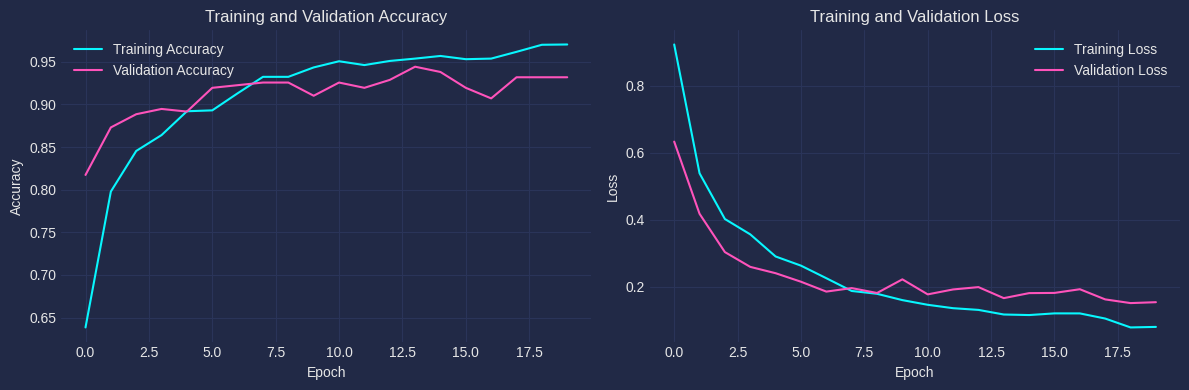

11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 594ms/step
Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.91      0.91      0.91        98
        no_tumor       0.98      0.98      0.98        48
meningioma_tumor       0.91      0.88      0.89        90
 pituitary_tumor       0.96      0.99      0.97        87

        accuracy                           0.93       323
       macro avg       0.94      0.94      0.94       323
    weighted avg       0.93      0.93      0.93       323



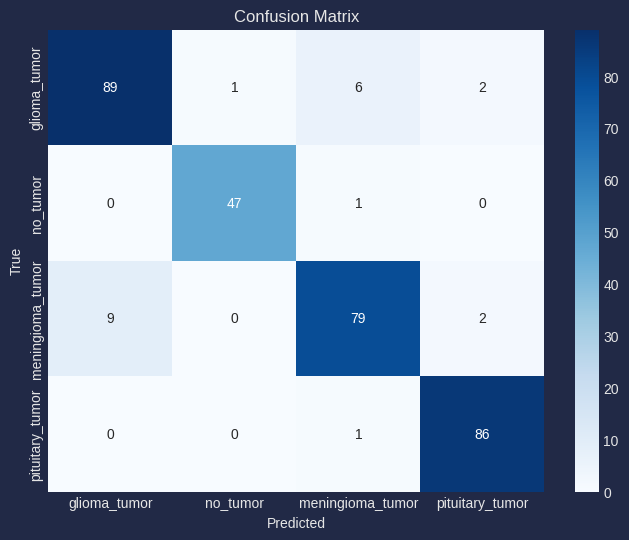

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tqdm import tqdm
import tensorflow.keras.applications as applications
import optuna

# GPU yapılandırmasını kontrol et
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print(f"GPU bulundu: {physical_devices}")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)  # Bellek büyümesini etkinleştir
else:
    print("GPU bulunamadı, CPU kullanılacak.")

# EfficientNetB0 modelini tanımlama
def create_efficientnetb0_model(input_shape=(150, 150, 3), num_classes=4, dense1_units=256, dense2_units=128, dropout1_rate=0.4, dropout2_rate=0.3):
    # EfficientNetB0 modelini ImageNet ağırlıkları ile yüklüyoruz
    base_model = applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

    # İlk etapta temel modeli eğitilebilir yapmıyoruz (transfer öğrenme için)
    base_model.trainable = False

    # Modeli oluşturuyoruz
    model = Sequential([
        base_model,  # EfficientNetB0 temel model
        GlobalAveragePooling2D(),  # Özellikleri ortalama alarak küçült
        BatchNormalization(),  # Normalizasyon
        Dense(dense1_units, activation='relu'),  # İlk tam bağlantılı katman
        Dropout(dropout1_rate),  # İlk dropout
        Dense(dense2_units, activation='relu'),  # İkinci tam bağlantılı katman
        Dropout(dropout2_rate),  # İkinci dropout
        Dense(num_classes, activation='softmax')  # Çıkış katmanı (4 sınıf)
    ])

    return model

# Optuna objective fonksiyonu
def objective(trial):
    # Hiperparametre aralıklarını tanımlama
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    dense1_units = trial.suggest_int("dense1_units", 128, 512, step=64)
    dense2_units = trial.suggest_int("dense2_units", 64, 256, step=32)
    dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
    dropout2_rate = trial.suggest_uniform("dropout2_rate", 0.2, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    print(f"\nTrial {trial.number} başladı:")
    print(f"Hiperparametreler: learning_rate={learning_rate:.6f}, dense1_units={dense1_units}, "
          f"dense2_units={dense2_units}, dropout1_rate={dropout1_rate:.2f}, dropout2_rate={dropout2_rate:.2f}, "
          f"batch_size={batch_size}")

    try:
        # Modeli oluştur
        model = create_efficientnetb0_model(
            dense1_units=dense1_units,
            dense2_units=dense2_units,
            dropout1_rate=dropout1_rate,
            dropout2_rate=dropout2_rate
        )

        # Modeli derle
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2,
            min_lr=1e-6
        )

        # Modeli eğit
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=10,  # Daha kısa süre için epoch sayısı
            batch_size=batch_size,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        # Test seti üzerinde tahmin yapma
        y_pred = model.predict(X_test, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test, axis=1)

        # F1 skorunu hesapla (macro)
        f1 = f1_score(y_true_classes, y_pred_classes, average='macro')
        print(f"F1 Skoru (macro): {f1:.4f}")

        # Belleği temizle
        tf.keras.backend.clear_session()

        return f1

    except Exception as e:
        print(f"Trial {trial.number} hata ile sonuçlandı: {e}")
        raise

# Optuna optimizasyonunu çalıştır
print("Optuna optimizasyonu başlıyor...")
study = optuna.create_study(direction="maximize", study_name="efficientnetb0_f1")
try:
    study.optimize(objective, n_trials=20)  # 20 deneme
except KeyboardInterrupt:
    print("Optimizasyon kullanıcı tarafından durduruldu.")

# En iyi hiperparametreleri yazdır
print("\n=== Optimizasyon Sonuçları ===")
print("En iyi hiperparametreler: ", study.best_params)
print("En iyi F1 skoru: ", study.best_value)
print("En iyi trial numarası: ", study.best_trial.number)

# En iyi hiperparametrelerle modeli tekrar eğit
best_params = study.best_params
best_model = create_efficientnetb0_model(
    dense1_units=best_params['dense1_units'],
    dense2_units=best_params['dense2_units'],
    dropout1_rate=best_params['dropout1_rate'],
    dropout2_rate=best_params['dropout2_rate']
)

# Modeli derle
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint = ModelCheckpoint(
    'best_model_optuna_f1.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# En iyi modelle eğitimi tekrar yap
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Eğitim sonuçlarını görselleştirme
plt.figure(figsize=(12, 4))

# Accuracy grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Test seti üzerinde tahmin yapma
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Sınıflandırma raporu
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=labels))

# Karışıklık matrisi
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
F1 Score (weighted): 0.9315
Precision (weighted): 0.9314
Recall (weighted): 0.9319
Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.91      0.91      0.91        98
        no_tumor       0.98      0.98      0.98        48
meningioma_tumor       0.91      0.88      0.89        90
 pituitary_tumor       0.96      0.99      0.97        87

        accuracy                           0.93       323
       macro avg       0.94      0.94      0.94       323
    weighted avg       0.93      0.93      0.93       323



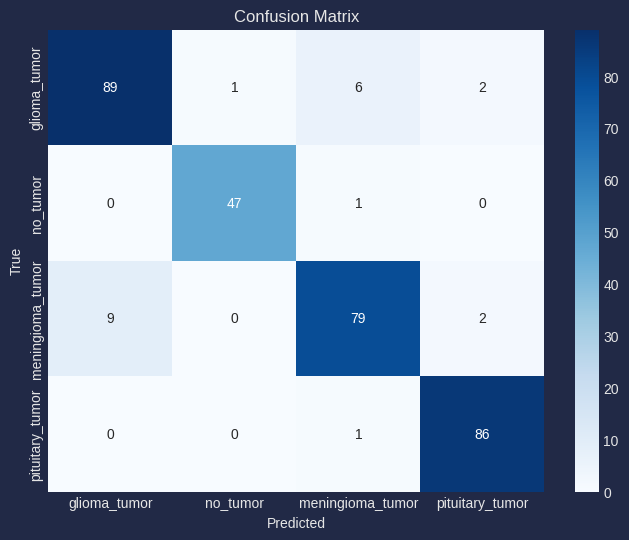

Tahmin Edilen Sınıf: pituitary_tumor
Gerçek Sınıf: pituitary_tumor
Güven Skoru: 100.00%



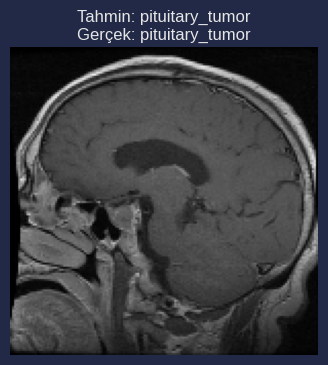

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")

# Sınıf etiketleri
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

# Test veri setinden rastgele bir görüntü al
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]

# En iyi modelle tahmin yap (best_model Optuna'dan geldi, reshape ile batch boyutu ekliyoruz)
predictions = best_model.predict(random_img.reshape(1, 150, 150, 3), verbose=0)

# Tahmin edilen sınıf ve güven skoru
predicted_class = np.argmax(predictions)
predicted_label = labels[predicted_class]
confidence = predictions[0][predicted_class] * 100  # Yüzde olarak güven skoru

# Gerçek sınıf bilgisi
actual_class = np.argmax(y_test[random_index])  # One-hot encoded'dan sınıf indeksine
actual_label = labels[actual_class]

# Sonuçları yazdır (renkli ve havalı 😎)
print(f"\033[94mTahmin Edilen Sınıf: {predicted_label}\033[0m")
print(f"\033[92mGerçek Sınıf: {actual_label}\033[0m")
print(f"\033[93mGüven Skoru: {confidence:.2f}%\033[0m\n")

# Görüntüyü görselleştir
plt.figure(figsize=(4, 4))
plt.imshow(random_img)
plt.title(f"Tahmin: {predicted_label}\nGerçek: {actual_label}", fontsize=12)
plt.axis('off')
plt.show()

Tahmin Edilen Sınıf: no_tumor
Gerçek Sınıf: no_tumor
Güven Skoru: 99.95%



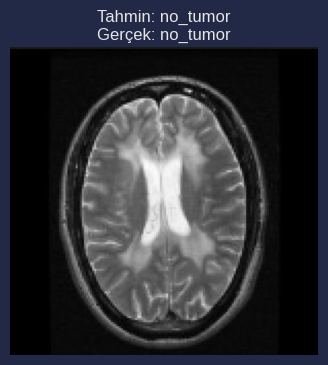

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")

# Sınıf etiketleri
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

# Test veri setinden rastgele bir görüntü al
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]

# En iyi modelle tahmin yap (best_model Optuna'dan geldi, reshape ile batch boyutu ekliyoruz)
predictions = best_model.predict(random_img.reshape(1, 150, 150, 3), verbose=0)

# Tahmin edilen sınıf ve güven skoru
predicted_class = np.argmax(predictions)
predicted_label = labels[predicted_class]
confidence = predictions[0][predicted_class] * 100  # Yüzde olarak güven skoru

# Gerçek sınıf bilgisi
actual_class = np.argmax(y_test[random_index])  # One-hot encoded'dan sınıf indeksine
actual_label = labels[actual_class]

# Sonuçları yazdır (renkli ve havalı 😎)
print(f"\033[94mTahmin Edilen Sınıf: {predicted_label}\033[0m")
print(f"\033[92mGerçek Sınıf: {actual_label}\033[0m")
print(f"\033[93mGüven Skoru: {confidence:.2f}%\033[0m\n")

# Görüntüyü görselleştir
plt.figure(figsize=(4, 4))
plt.imshow(random_img)
plt.title(f"Tahmin: {predicted_label}\nGerçek: {actual_label}", fontsize=12)
plt.axis('off')
plt.show()

Tahmin Edilen Sınıf: pituitary_tumor
Gerçek Sınıf: pituitary_tumor
Güven Skoru: 100.00%



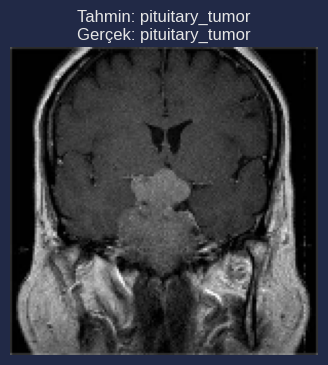

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")

# Sınıf etiketleri
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

# Test veri setinden rastgele bir görüntü al
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]

# En iyi modelle tahmin yap (best_model Optuna'dan geldi, reshape ile batch boyutu ekliyoruz)
predictions = best_model.predict(random_img.reshape(1, 150, 150, 3), verbose=0)

# Tahmin edilen sınıf ve güven skoru
predicted_class = np.argmax(predictions)
predicted_label = labels[predicted_class]
confidence = predictions[0][predicted_class] * 100  # Yüzde olarak güven skoru

# Gerçek sınıf bilgisi
actual_class = np.argmax(y_test[random_index])  # One-hot encoded'dan sınıf indeksine
actual_label = labels[actual_class]

# Sonuçları yazdır (renkli ve havalı 😎)
print(f"\033[94mTahmin Edilen Sınıf: {predicted_label}\033[0m")
print(f"\033[92mGerçek Sınıf: {actual_label}\033[0m")
print(f"\033[93mGüven Skoru: {confidence:.2f}%\033[0m\n")

# Görüntüyü görselleştir
plt.figure(figsize=(4, 4))
plt.imshow(random_img)
plt.title(f"Tahmin: {predicted_label}\nGerçek: {actual_label}", fontsize=12)
plt.axis('off')
plt.show()

# **Resnet101**

GPU bulundu: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
171317808/171317808 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)        │ (None, 5, 5, 2048)     │    42,626,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,768,100 (163.15 MB)

 Trainable params: 137,444 (536.89 KB)

 Non-trainable params: 42,630,656 (162.62 MB)

Epoch 1/5
725/725 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2867 - loss: nan

725/725 ━━━━━━━━━━━━━━━━━━━━ 45s 35ms/step - accuracy: 0.2867 - loss: nan - val_accuracy: 0.2693 - val_loss: nan
Epoch 2/5
725/725 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.2729 - loss: nan - val_accuracy: 0.2693 - val_loss: nan
Epoch 3/5
725/725 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.2843 - loss: nan - val_accuracy: 0.2693 - val_loss: nan


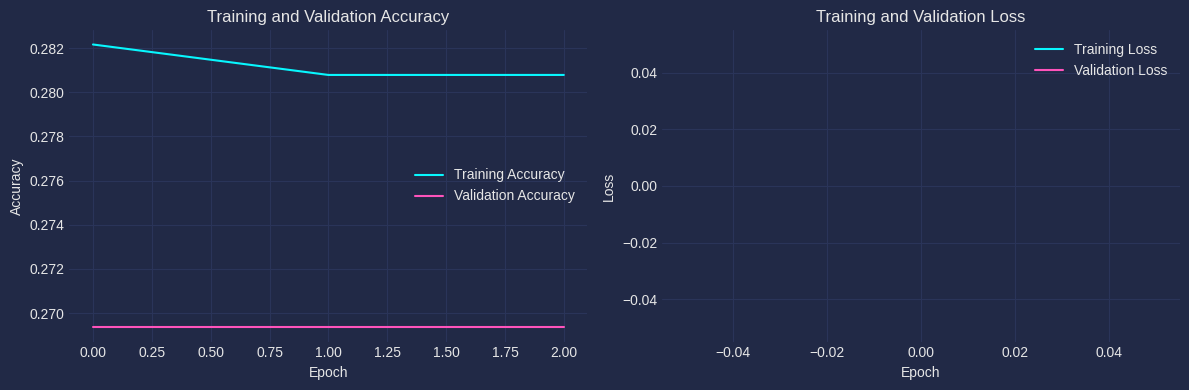

11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 640ms/step
Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.30      1.00      0.47        98
        no_tumor       0.00      0.00      0.00        48
meningioma_tumor       0.00      0.00      0.00        90
 pituitary_tumor       0.00      0.00      0.00        87

        accuracy                           0.30       323
       macro avg       0.08      0.25      0.12       323
    weighted avg       0.09      0.30      0.14       323



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


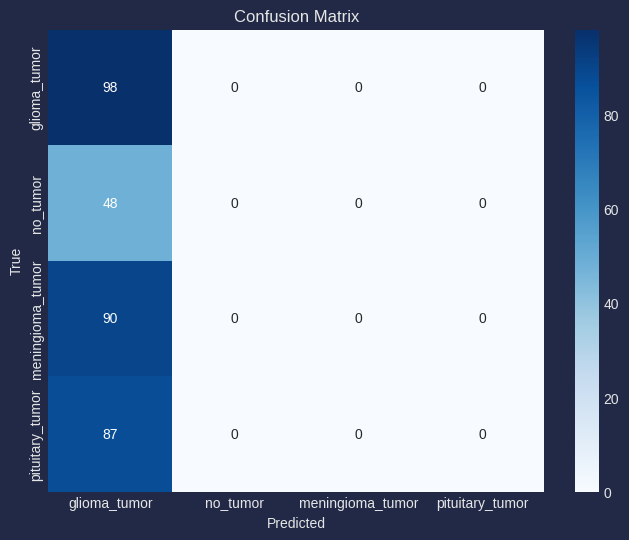

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import tensorflow.keras.applications as applications

# GPU yapılandırmasını kontrol et
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print(f"GPU bulundu: {physical_devices}")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)  # Bellek büyümesini etkinleştir
else:
    print("GPU bulunamadı, CPU kullanılacak.")

# ResNet101V2 modelini tanımlama (kötüleştirilmiş yapı)
def create_resnet101_model(input_shape=(150, 150, 3), num_classes=4):
    # ResNet101V2 modelini ImageNet ağırlıkları ile yüklüyoruz
    base_model = applications.ResNet101V2(weights='imagenet', include_top=False, input_shape=input_shape)

    # İlk etapta temel modeli eğitilebilir yapmıyoruz (transfer öğrenme için)
    base_model.trainable = False

    # Modeli oluşturuyoruz (kötüleştirilmiş katmanlar)
    model = Sequential([
        base_model,  # ResNet101V2 temel model
        GlobalAveragePooling2D(),  # Özellikleri ortalama alarak küçült
        BatchNormalization(),  # Normalizasyon
        Dense(64, activation='relu'),  # Azaltılmış nöron sayısı
        Dropout(0.7),  # Çok yüksek dropout oranı
        Dense(32, activation='relu'),  # Azaltılmış nöron sayısı
        Dropout(0.6),  # Çok yüksek dropout oranı
        Dense(num_classes, activation='softmax')  # Çıkış katmanı (4 sınıf)
    ])

    return model

# Modeli oluştur
model = create_resnet101_model()

# Model özetini yazdır
model.summary()

# Kötüleştirilmiş hiperparametreler
learning_rate = 0.1  # Çok yüksek öğrenme oranı
batch_size = 4  # Çok küçük batch boyutu
epochs = 5  # Çok az epoch sayısı

# Modeli derleme
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),  # Daha az etkili optimizasyon
    loss='categorical_crossentropy',  # Çoklu sınıf problemi için
    metrics=['accuracy']  # Takip edilecek metrik
)

# Callbacks tanımlama (kötüleştirilmiş)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,  # Çok kısa sabır süresi
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'worst_model_resnet101.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

# ReduceLROnPlateau'yu kaldırıyoruz
callbacks = [early_stopping, checkpoint]

# Modeli eğitme
history = model.fit(
    X_train, y_train,  # Varsayılan veri seti
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)

# Eğitim sonuçlarını görselleştirme
plt.figure(figsize=(12, 4))

# Accuracy grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Test seti üzerinde tahmin yapma
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Sınıflandırma raporu
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=labels))

# Karışıklık matrisi
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted label: glioma_tumor 
Actual label: no_tumor 
Confidence: nan%



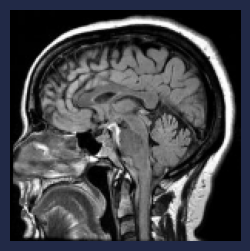

In [ ]:
# Test veri setinden rastgele bir görüntü alınıyor
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]

# Model bu görüntü için tahmin yapar (reshape işlemi modeli uygun boyuta getirmek içindir)
predictions = model.predict(random_img.reshape(1, 150, 150, 3))

# Tahmin edilen sınıf ve güven skoru
predicted_class = np.argmax(predictions)  # En yüksek olasılığa sahip sınıf
predicted_label = labels[predicted_class]
confidence = predictions[0][predicted_class]  # Güven oranı (% olarak ifade edilecek)

# Gerçek sınıf bilgisi
actual_index = y_test[random_index]  # One-hot encoded formda
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

# Sonuçlar ekrana yazdırılır
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")

# Görüntü ekrana çizilir
plt.figure(figsize=(3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()


# **Optuna Hpo Resnet101(Accuracy)**

[I 2025-04-23 13:26:55,728] A new study created in memory with name: resnet101v2_accuracy
<ipython-input-8-6128e99d1f82>:45: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-8-6128e99d1f82>:48: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-8-6128e99d1f82>:49: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout2_rate = trial.suggest_uniform("dropout2_rate", 0.2, 0.5)


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 38s 219ms/step - accuracy: 0.5558 - loss: 1.0602 - val_accuracy: 0.4644 - val_loss: 1.3375 - learning_rate: 5.0059e-04
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7422 - loss: 0.6461 - val_accuracy: 0.7121 - val_loss: 0.6271 - learning_rate: 5.0059e-04
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7942 - loss: 0.5119 - val_accuracy: 0.8111 - val_loss: 0.4137 - learning_rate: 5.0059e-04
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8545 - loss: 0.4089 - val_accuracy: 0.8359 - val_loss: 0.4149 - learning_rate: 5.0059e-04
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8408 - loss: 0.3974 - val_accuracy: 0.8576 - val_loss: 0.3619 - learning_rate: 5.0059e-04
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8813 - loss: 0.3034 - val_accuracy: 0.8669 - val_loss: 0.3454 - learning_rate: 5.0059e-04
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.900

[I 2025-04-23 13:27:52,438] Trial 0 finished with value: 0.891640841960907 and parameters: {'learning_rate': 0.0005005948505180747, 'dense1_units': 256, 'dense2_units': 160, 'dropout1_rate': 0.2220538988172257, 'dropout2_rate': 0.33616885893958515, 'batch_size': 32}. Best is trial 0 with value: 0.891640841960907.


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 38s 419ms/step - accuracy: 0.2619 - loss: 1.7405 - val_accuracy: 0.3003 - val_loss: 1.9396 - learning_rate: 3.0562e-05
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4636 - loss: 1.2818 - val_accuracy: 0.4056 - val_loss: 1.4334 - learning_rate: 3.0562e-05
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5364 - loss: 1.1762 - val_accuracy: 0.5418 - val_loss: 1.0814 - learning_rate: 3.0562e-05
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5652 - loss: 1.0919 - val_accuracy: 0.6440 - val_loss: 0.9071 - learning_rate: 3.0562e-05
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5937 - loss: 1.0446 - val_accuracy: 0.6440 - val_loss: 0.8208 - learning_rate: 3.0562e-05
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5982 - loss: 1.0146 - val_accuracy: 0.6563 - val_loss: 0.7705 - learning_rate: 3.0562e-05
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.619

[I 2025-04-23 13:28:47,146] Trial 1 finished with value: 0.693498432636261 and parameters: {'learning_rate': 3.056217476751218e-05, 'dense1_units': 384, 'dense2_units': 192, 'dropout1_rate': 0.447941916838464, 'dropout2_rate': 0.41004406751490785, 'batch_size': 64}. Best is trial 0 with value: 0.891640841960907.


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 424ms/step - accuracy: 0.3423 - loss: 1.4253 - val_accuracy: 0.1610 - val_loss: 2.9678 - learning_rate: 2.7517e-05
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5619 - loss: 1.0540 - val_accuracy: 0.3282 - val_loss: 1.5426 - learning_rate: 2.7517e-05
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6239 - loss: 0.9424 - val_accuracy: 0.5666 - val_loss: 1.0221 - learning_rate: 2.7517e-05
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6485 - loss: 0.8645 - val_accuracy: 0.6842 - val_loss: 0.8204 - learning_rate: 2.7517e-05
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6831 - loss: 0.8172 - val_accuracy: 0.7059 - val_loss: 0.7232 - learning_rate: 2.7517e-05
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7141 - loss: 0.7375 - val_accuracy: 0.7307 - val_loss: 0.6652 - learning_rate: 2.7517e-05
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.723

[I 2025-04-23 13:29:40,948] Trial 2 finished with value: 0.7647058963775635 and parameters: {'learning_rate': 2.7517224523649372e-05, 'dense1_units': 512, 'dense2_units': 256, 'dropout1_rate': 0.22617420337425395, 'dropout2_rate': 0.22782389561180186, 'batch_size': 64}. Best is trial 0 with value: 0.891640841960907.


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 38s 435ms/step - accuracy: 0.5312 - loss: 1.1587 - val_accuracy: 0.2415 - val_loss: 3.1014 - learning_rate: 3.7991e-04
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7405 - loss: 0.6749 - val_accuracy: 0.4861 - val_loss: 1.1731 - learning_rate: 3.7991e-04
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7665 - loss: 0.5881 - val_accuracy: 0.6656 - val_loss: 0.7703 - learning_rate: 3.7991e-04
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8258 - loss: 0.4560 - val_accuracy: 0.7678 - val_loss: 0.5683 - learning_rate: 3.7991e-04
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8293 - loss: 0.4398 - val_accuracy: 0.8050 - val_loss: 0.4549 - learning_rate: 3.7991e-04
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8638 - loss: 0.3538 - val_accuracy: 0.8173 - val_loss: 0.3918 - learning_rate: 3.7991e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.884

[I 2025-04-23 13:30:35,258] Trial 3 finished with value: 0.8761609792709351 and parameters: {'learning_rate': 0.000379914903000397, 'dense1_units': 448, 'dense2_units': 192, 'dropout1_rate': 0.38851449678288336, 'dropout2_rate': 0.2909951459989094, 'batch_size': 64}. Best is trial 0 with value: 0.891640841960907.


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 36s 208ms/step - accuracy: 0.5288 - loss: 1.4348 - val_accuracy: 0.3746 - val_loss: 1.7117 - learning_rate: 0.0019
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6744 - loss: 0.8594 - val_accuracy: 0.6842 - val_loss: 0.7340 - learning_rate: 0.0019
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7405 - loss: 0.6678 - val_accuracy: 0.7647 - val_loss: 0.5518 - learning_rate: 0.0019
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7511 - loss: 0.6142 - val_accuracy: 0.7895 - val_loss: 0.4768 - learning_rate: 0.0019
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7841 - loss: 0.5390 - val_accuracy: 0.8235 - val_loss: 0.4533 - learning_rate: 0.0019
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8201 - loss: 0.4668 - val_accuracy: 0.8142 - val_loss: 0.3981 - learning_rate: 0.0019
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8118 - loss: 0.4751 - val_a

[I 2025-04-23 13:31:32,318] Trial 4 finished with value: 0.8637771010398865 and parameters: {'learning_rate': 0.0019455591569904735, 'dense1_units': 192, 'dense2_units': 256, 'dropout1_rate': 0.4939857272796725, 'dropout2_rate': 0.4687404295413293, 'batch_size': 32}. Best is trial 0 with value: 0.891640841960907.


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 36s 206ms/step - accuracy: 0.5193 - loss: 1.3058 - val_accuracy: 0.3344 - val_loss: 2.1476 - learning_rate: 0.0015
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6988 - loss: 0.7733 - val_accuracy: 0.6904 - val_loss: 0.7000 - learning_rate: 0.0015
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7293 - loss: 0.6825 - val_accuracy: 0.7368 - val_loss: 0.5586 - learning_rate: 0.0015
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7532 - loss: 0.6219 - val_accuracy: 0.8266 - val_loss: 0.4432 - learning_rate: 0.0015
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7993 - loss: 0.5304 - val_accuracy: 0.8297 - val_loss: 0.4262 - learning_rate: 0.0015
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8080 - loss: 0.5107 - val_accuracy: 0.8173 - val_loss: 0.4318 - learning_rate: 0.0015
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8264 - loss: 0.4272 - val_a

[I 2025-04-23 13:32:28,964] Trial 5 finished with value: 0.8699690699577332 and parameters: {'learning_rate': 0.0014825919273327374, 'dense1_units': 384, 'dense2_units': 64, 'dropout1_rate': 0.31640362625171703, 'dropout2_rate': 0.45980887166160017, 'batch_size': 32}. Best is trial 0 with value: 0.891640841960907.


Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 41s 120ms/step - accuracy: 0.5389 - loss: 1.1158 - val_accuracy: 0.6625 - val_loss: 0.7621 - learning_rate: 1.6397e-04
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6929 - loss: 0.7635 - val_accuracy: 0.7957 - val_loss: 0.5605 - learning_rate: 1.6397e-04
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7512 - loss: 0.6524 - val_accuracy: 0.7988 - val_loss: 0.4880 - learning_rate: 1.6397e-04
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7786 - loss: 0.5650 - val_accuracy: 0.8390 - val_loss: 0.4475 - learning_rate: 1.6397e-04
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8030 - loss: 0.5203 - val_accuracy: 0.8452 - val_loss: 0.4246 - learning_rate: 1.6397e-04
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8103 - loss: 0.4887 - val_accuracy: 0.8576 - val_loss: 0.3954 - learning_rate: 1.6397e-04
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - a

[I 2025-04-23 13:33:39,082] Trial 6 finished with value: 0.8668730854988098 and parameters: {'learning_rate': 0.00016396718822996335, 'dense1_units': 512, 'dense2_units': 224, 'dropout1_rate': 0.4963346985757423, 'dropout2_rate': 0.2134992885701696, 'batch_size': 16}. Best is trial 0 with value: 0.891640841960907.


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 423ms/step - accuracy: 0.4775 - loss: 1.2151 - val_accuracy: 0.2074 - val_loss: 2.9667 - learning_rate: 2.0412e-04
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6919 - loss: 0.7653 - val_accuracy: 0.4551 - val_loss: 1.3921 - learning_rate: 2.0412e-04
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7634 - loss: 0.6291 - val_accuracy: 0.6656 - val_loss: 0.8172 - learning_rate: 2.0412e-04
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7864 - loss: 0.5579 - val_accuracy: 0.7554 - val_loss: 0.5986 - learning_rate: 2.0412e-04
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8193 - loss: 0.4880 - val_accuracy: 0.7988 - val_loss: 0.4870 - learning_rate: 2.0412e-04
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8384 - loss: 0.4305 - val_accuracy: 0.8173 - val_loss: 0.4284 - learning_rate: 2.0412e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.848

[I 2025-04-23 13:34:33,059] Trial 7 finished with value: 0.8575851321220398 and parameters: {'learning_rate': 0.00020412004474612872, 'dense1_units': 320, 'dense2_units': 96, 'dropout1_rate': 0.2943544553338926, 'dropout2_rate': 0.216267065806964, 'batch_size': 64}. Best is trial 0 with value: 0.891640841960907.


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 36s 399ms/step - accuracy: 0.5405 - loss: 1.5687 - val_accuracy: 0.1734 - val_loss: 2.3017 - learning_rate: 0.0049
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6351 - loss: 0.8454 - val_accuracy: 0.4149 - val_loss: 1.2863 - learning_rate: 0.0049
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6796 - loss: 0.7328 - val_accuracy: 0.5975 - val_loss: 0.8187 - learning_rate: 0.0049
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7585 - loss: 0.5824 - val_accuracy: 0.6502 - val_loss: 0.6798 - learning_rate: 0.0049
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7940 - loss: 0.5158 - val_accuracy: 0.7585 - val_loss: 0.5597 - learning_rate: 0.0049
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8001 - loss: 0.4884 - val_accuracy: 0.7833 - val_loss: 0.4934 - learning_rate: 0.0049
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8141 - loss: 0.4696 - val_a

[I 2025-04-23 13:35:25,402] Trial 8 finished with value: 0.8699690699577332 and parameters: {'learning_rate': 0.004913337663314191, 'dense1_units': 512, 'dense2_units': 96, 'dropout1_rate': 0.20658231302569294, 'dropout2_rate': 0.4707124655376178, 'batch_size': 64}. Best is trial 0 with value: 0.891640841960907.


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 36s 211ms/step - accuracy: 0.5850 - loss: 1.1314 - val_accuracy: 0.4180 - val_loss: 1.4417 - learning_rate: 8.3701e-04
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7329 - loss: 0.6847 - val_accuracy: 0.6780 - val_loss: 0.6959 - learning_rate: 8.3701e-04
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7950 - loss: 0.5182 - val_accuracy: 0.7864 - val_loss: 0.5252 - learning_rate: 8.3701e-04
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8396 - loss: 0.3990 - val_accuracy: 0.8328 - val_loss: 0.3924 - learning_rate: 8.3701e-04
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8613 - loss: 0.3621 - val_accuracy: 0.8452 - val_loss: 0.3485 - learning_rate: 8.3701e-04
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8799 - loss: 0.3012 - val_accuracy: 0.8545 - val_loss: 0.3356 - learning_rate: 8.3701e-04
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.888

[I 2025-04-23 13:36:23,199] Trial 9 finished with value: 0.8947368264198303 and parameters: {'learning_rate': 0.0008370111940772211, 'dense1_units': 448, 'dense2_units': 160, 'dropout1_rate': 0.2577832366956206, 'dropout2_rate': 0.36356940647055, 'batch_size': 32}. Best is trial 9 with value: 0.8947368264198303.


Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 36s 102ms/step - accuracy: 0.5221 - loss: 1.8590 - val_accuracy: 0.6811 - val_loss: 0.8073 - learning_rate: 0.0068
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6358 - loss: 0.8764 - val_accuracy: 0.7276 - val_loss: 0.6492 - learning_rate: 0.0068
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6836 - loss: 0.7823 - val_accuracy: 0.7709 - val_loss: 0.5573 - learning_rate: 0.0068
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7330 - loss: 0.6844 - val_accuracy: 0.7523 - val_loss: 0.5759 - learning_rate: 0.0068
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7313 - loss: 0.7468 - val_accuracy: 0.7554 - val_loss: 0.5451 - learning_rate: 0.0068
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7513 - loss: 0.6705 - val_accuracy: 0.7833 - val_loss: 0.6017 - learning_rate: 0.0068
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7744 - loss: 

[I 2025-04-23 13:37:28,900] Trial 10 finished with value: 0.8049535751342773 and parameters: {'learning_rate': 0.006767459123923837, 'dense1_units': 128, 'dense2_units': 128, 'dropout1_rate': 0.2817046584649786, 'dropout2_rate': 0.38835128096509586, 'batch_size': 16}. Best is trial 9 with value: 0.8947368264198303.


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 33s 177ms/step - accuracy: 0.5668 - loss: 1.0877 - val_accuracy: 0.5480 - val_loss: 1.1370 - learning_rate: 6.8476e-04
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7553 - loss: 0.6316 - val_accuracy: 0.7337 - val_loss: 0.6243 - learning_rate: 6.8476e-04
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8129 - loss: 0.4823 - val_accuracy: 0.7895 - val_loss: 0.4992 - learning_rate: 6.8476e-04
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8326 - loss: 0.4205 - val_accuracy: 0.8235 - val_loss: 0.3955 - learning_rate: 6.8476e-04
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8479 - loss: 0.3642 - val_accuracy: 0.8762 - val_loss: 0.3628 - learning_rate: 6.8476e-04
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8860 - loss: 0.3083 - val_accuracy: 0.8700 - val_loss: 0.3371 - learning_rate: 6.8476e-04
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.891

[I 2025-04-23 13:38:23,945] Trial 11 finished with value: 0.8823529481887817 and parameters: {'learning_rate': 0.0006847592614940495, 'dense1_units': 256, 'dense2_units': 160, 'dropout1_rate': 0.24570310993748876, 'dropout2_rate': 0.31234909684709206, 'batch_size': 32}. Best is trial 9 with value: 0.8947368264198303.


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 33s 176ms/step - accuracy: 0.4065 - loss: 1.3643 - val_accuracy: 0.4087 - val_loss: 1.3980 - learning_rate: 8.5875e-05
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5918 - loss: 0.9573 - val_accuracy: 0.6811 - val_loss: 0.8203 - learning_rate: 8.5875e-05
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6652 - loss: 0.8289 - val_accuracy: 0.7430 - val_loss: 0.6607 - learning_rate: 8.5875e-05
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6843 - loss: 0.7896 - val_accuracy: 0.7461 - val_loss: 0.6052 - learning_rate: 8.5875e-05
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7000 - loss: 0.7433 - val_accuracy: 0.7802 - val_loss: 0.5631 - learning_rate: 8.5875e-05
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7681 - loss: 0.6364 - val_accuracy: 0.7926 - val_loss: 0.5300 - learning_rate: 8.5875e-05
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.747

[I 2025-04-23 13:39:18,970] Trial 12 finished with value: 0.8328173160552979 and parameters: {'learning_rate': 8.587518282350602e-05, 'dense1_units': 256, 'dense2_units': 160, 'dropout1_rate': 0.3621769436774957, 'dropout2_rate': 0.3470060197358104, 'batch_size': 32}. Best is trial 9 with value: 0.8947368264198303.


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 38s 222ms/step - accuracy: 0.5774 - loss: 1.0931 - val_accuracy: 0.3591 - val_loss: 1.7667 - learning_rate: 0.0010
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7471 - loss: 0.6305 - val_accuracy: 0.7554 - val_loss: 0.5326 - learning_rate: 0.0010
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8085 - loss: 0.5052 - val_accuracy: 0.8235 - val_loss: 0.4410 - learning_rate: 0.0010
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8501 - loss: 0.3859 - val_accuracy: 0.8390 - val_loss: 0.3794 - learning_rate: 0.0010
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8565 - loss: 0.3677 - val_accuracy: 0.8452 - val_loss: 0.3876 - learning_rate: 0.0010
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8740 - loss: 0.3220 - val_accuracy: 0.8328 - val_loss: 0.3838 - learning_rate: 0.0010
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9086 - loss: 0.2565 - val_a

[I 2025-04-23 13:40:19,152] Trial 13 finished with value: 0.900928795337677 and parameters: {'learning_rate': 0.0010128985840185721, 'dense1_units': 320, 'dense2_units': 128, 'dropout1_rate': 0.2591123465441259, 'dropout2_rate': 0.2784827085604911, 'batch_size': 32}. Best is trial 13 with value: 0.900928795337677.


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 36s 208ms/step - accuracy: 0.5704 - loss: 1.1317 - val_accuracy: 0.3220 - val_loss: 1.8711 - learning_rate: 0.0015
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7449 - loss: 0.6261 - val_accuracy: 0.7152 - val_loss: 0.6087 - learning_rate: 0.0015
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8149 - loss: 0.4707 - val_accuracy: 0.8019 - val_loss: 0.5237 - learning_rate: 0.0015
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8273 - loss: 0.4587 - val_accuracy: 0.8266 - val_loss: 0.4187 - learning_rate: 0.0015
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8807 - loss: 0.3226 - val_accuracy: 0.8638 - val_loss: 0.3300 - learning_rate: 0.0015
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8934 - loss: 0.2951 - val_accuracy: 0.8638 - val_loss: 0.3398 - learning_rate: 0.0015
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8974 - loss: 0.2631 - val_a

[I 2025-04-23 13:41:17,007] Trial 14 finished with value: 0.9133126735687256 and parameters: {'learning_rate': 0.001451252206473203, 'dense1_units': 384, 'dense2_units': 128, 'dropout1_rate': 0.26636484802504357, 'dropout2_rate': 0.2705869566544534, 'batch_size': 32}. Best is trial 14 with value: 0.9133126735687256.


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 35s 195ms/step - accuracy: 0.5469 - loss: 1.3791 - val_accuracy: 0.3529 - val_loss: 1.8403 - learning_rate: 0.0028
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7098 - loss: 0.7488 - val_accuracy: 0.6316 - val_loss: 0.7726 - learning_rate: 0.0028
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7519 - loss: 0.6008 - val_accuracy: 0.8111 - val_loss: 0.4862 - learning_rate: 0.0028
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7893 - loss: 0.5334 - val_accuracy: 0.8204 - val_loss: 0.4394 - learning_rate: 0.0028
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8343 - loss: 0.4073 - val_accuracy: 0.8266 - val_loss: 0.4438 - learning_rate: 0.0028
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8505 - loss: 0.3835 - val_accuracy: 0.8266 - val_loss: 0.3631 - learning_rate: 0.0028
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8689 - loss: 0.3427 - val_a

[I 2025-04-23 13:42:13,341] Trial 15 finished with value: 0.8854489326477051 and parameters: {'learning_rate': 0.0028145240104149208, 'dense1_units': 320, 'dense2_units': 96, 'dropout1_rate': 0.33997614825622186, 'dropout2_rate': 0.2728915730792196, 'batch_size': 32}. Best is trial 14 with value: 0.9133126735687256.


Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 36s 100ms/step - accuracy: 0.5756 - loss: 1.1610 - val_accuracy: 0.6594 - val_loss: 0.7841 - learning_rate: 0.0012
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7074 - loss: 0.7026 - val_accuracy: 0.8050 - val_loss: 0.4995 - learning_rate: 0.0012
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7854 - loss: 0.5743 - val_accuracy: 0.8204 - val_loss: 0.4502 - learning_rate: 0.0012
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7985 - loss: 0.5068 - val_accuracy: 0.8390 - val_loss: 0.4036 - learning_rate: 0.0012
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8352 - loss: 0.4095 - val_accuracy: 0.8359 - val_loss: 0.3935 - learning_rate: 0.0012
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8295 - loss: 0.3993 - val_accuracy: 0.8452 - val_loss: 0.4063 - learning_rate: 0.0012
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8602 - loss: 

[I 2025-04-23 13:43:19,826] Trial 16 finished with value: 0.8637771010398865 and parameters: {'learning_rate': 0.0011711680500804873, 'dense1_units': 384, 'dense2_units': 128, 'dropout1_rate': 0.26782788817022946, 'dropout2_rate': 0.25537004975958383, 'batch_size': 16}. Best is trial 14 with value: 0.9133126735687256.


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 35s 200ms/step - accuracy: 0.5076 - loss: 1.6607 - val_accuracy: 0.4118 - val_loss: 1.9768 - learning_rate: 0.0044
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6542 - loss: 0.8761 - val_accuracy: 0.6316 - val_loss: 0.7805 - learning_rate: 0.0044
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6764 - loss: 0.7804 - val_accuracy: 0.7616 - val_loss: 0.5321 - learning_rate: 0.0044
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7405 - loss: 0.6106 - val_accuracy: 0.8173 - val_loss: 0.4745 - learning_rate: 0.0044
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7859 - loss: 0.5416 - val_accuracy: 0.8297 - val_loss: 0.4482 - learning_rate: 0.0044
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8117 - loss: 0.4676 - val_accuracy: 0.8142 - val_loss: 0.4622 - learning_rate: 0.0044
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8160 - loss: 0.4799 - val_a

[I 2025-04-23 13:44:16,508] Trial 17 finished with value: 0.8730649948120117 and parameters: {'learning_rate': 0.004394585762138083, 'dense1_units': 320, 'dense2_units': 64, 'dropout1_rate': 0.30803777127168325, 'dropout2_rate': 0.3067034598149755, 'batch_size': 32}. Best is trial 14 with value: 0.9133126735687256.


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 37s 213ms/step - accuracy: 0.4744 - loss: 2.7035 - val_accuracy: 0.2074 - val_loss: 1.4165 - learning_rate: 0.0099
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6045 - loss: 0.9689 - val_accuracy: 0.5232 - val_loss: 1.0299 - learning_rate: 0.0099
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6600 - loss: 0.8240 - val_accuracy: 0.7028 - val_loss: 0.7565 - learning_rate: 0.0099
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6766 - loss: 0.7780 - val_accuracy: 0.7368 - val_loss: 0.6815 - learning_rate: 0.0099
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7196 - loss: 0.7411 - val_accuracy: 0.7307 - val_loss: 0.5874 - learning_rate: 0.0099
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7260 - loss: 0.7462 - val_accuracy: 0.7276 - val_loss: 0.7633 - learning_rate: 0.0099
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7305 - loss: 0.7074 - val_a

[I 2025-04-23 13:45:15,160] Trial 18 finished with value: 0.8111454844474792 and parameters: {'learning_rate': 0.009893328774851341, 'dense1_units': 448, 'dense2_units': 128, 'dropout1_rate': 0.39194007415359944, 'dropout2_rate': 0.24876510016072784, 'batch_size': 32}. Best is trial 14 with value: 0.9133126735687256.


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 37s 213ms/step - accuracy: 0.3672 - loss: 1.3735 - val_accuracy: 0.3498 - val_loss: 1.4388 - learning_rate: 8.8226e-05
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6122 - loss: 0.9663 - val_accuracy: 0.6533 - val_loss: 0.8459 - learning_rate: 8.8226e-05
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6643 - loss: 0.8524 - val_accuracy: 0.7430 - val_loss: 0.6901 - learning_rate: 8.8226e-05
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6998 - loss: 0.7398 - val_accuracy: 0.7678 - val_loss: 0.6125 - learning_rate: 8.8226e-05
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7240 - loss: 0.7027 - val_accuracy: 0.7647 - val_loss: 0.5783 - learning_rate: 8.8226e-05
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7328 - loss: 0.6618 - val_accuracy: 0.7895 - val_loss: 0.5211 - learning_rate: 8.8226e-05
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.766

[I 2025-04-23 13:46:14,698] Trial 19 finished with value: 0.8204334378242493 and parameters: {'learning_rate': 8.822591464108278e-05, 'dense1_units': 192, 'dense2_units': 192, 'dropout1_rate': 0.33812834170586215, 'dropout2_rate': 0.27822838345998957, 'batch_size': 32}. Best is trial 14 with value: 0.9133126735687256.



=== Optimizasyon Sonuçları ===
En iyi hiperparametreler:  {'learning_rate': 0.001451252206473203, 'dense1_units': 384, 'dense2_units': 128, 'dropout1_rate': 0.26636484802504357, 'dropout2_rate': 0.2705869566544534, 'batch_size': 32}
En iyi validation accuracy:  0.9133126735687256
En iyi trial numarası:  14
Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5917 - loss: 1.1654

91/91 ━━━━━━━━━━━━━━━━━━━━ 34s 182ms/step - accuracy: 0.5924 - loss: 1.1633 - val_accuracy: 0.3189 - val_loss: 1.8911 - learning_rate: 0.0015
Epoch 2/20
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7366 - loss: 0.6544

91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7372 - loss: 0.6533 - val_accuracy: 0.7214 - val_loss: 0.6301 - learning_rate: 0.0015
Epoch 3/20
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8124 - loss: 0.4901

91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8123 - loss: 0.4904 - val_accuracy: 0.8266 - val_loss: 0.4015 - learning_rate: 0.0015
Epoch 4/20
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8259 - loss: 0.4173

91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8261 - loss: 0.4174 - val_accuracy: 0.8669 - val_loss: 0.3662 - learning_rate: 0.0015
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8563 - loss: 0.3481 - val_accuracy: 0.8452 - val_loss: 0.3482 - learning_rate: 0.0015
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8726 - loss: 0.3214 - val_accuracy: 0.8359 - val_loss: 0.3927 - learning_rate: 0.0015
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8961 - loss: 0.2653 - val_accuracy: 0.8638 - val_loss: 0.3400 - learning_rate: 0.0015
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8945 - loss: 0.2503 - val_accuracy: 0.8607 - val_loss: 0.3464 - learning_rate: 0.0015
Epoch 9/20
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9186 - loss: 0.2233

91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9188 - loss: 0.2226 - val_accuracy: 0.8947 - val_loss: 0.2834 - learning_rate: 0.0015
Epoch 10/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9319 - loss: 0.1798 - val_accuracy: 0.8947 - val_loss: 0.2945 - learning_rate: 0.0015
Epoch 11/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9181 - loss: 0.2322 - val_accuracy: 0.8947 - val_loss: 0.3146 - learning_rate: 0.0015
Epoch 12/20
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9277 - loss: 0.1872

91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9275 - loss: 0.1876 - val_accuracy: 0.9040 - val_loss: 0.2573 - learning_rate: 0.0015
Epoch 13/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9376 - loss: 0.1701 - val_accuracy: 0.9009 - val_loss: 0.3000 - learning_rate: 0.0015
Epoch 14/20
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9552 - loss: 0.1187

91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9551 - loss: 0.1191 - val_accuracy: 0.9071 - val_loss: 0.2464 - learning_rate: 0.0015
Epoch 15/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9477 - loss: 0.1562 - val_accuracy: 0.9071 - val_loss: 0.2839 - learning_rate: 0.0015
Epoch 16/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9547 - loss: 0.1224 - val_accuracy: 0.8947 - val_loss: 0.3538 - learning_rate: 0.0015
Epoch 17/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9589 - loss: 0.1312 - val_accuracy: 0.8854 - val_loss: 0.3329 - learning_rate: 0.0015
Epoch 18/20
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9719 - loss: 0.0849

91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9719 - loss: 0.0849 - val_accuracy: 0.9288 - val_loss: 0.2573 - learning_rate: 2.9025e-04
Epoch 19/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9802 - loss: 0.0589 - val_accuracy: 0.9133 - val_loss: 0.2755 - learning_rate: 2.9025e-04


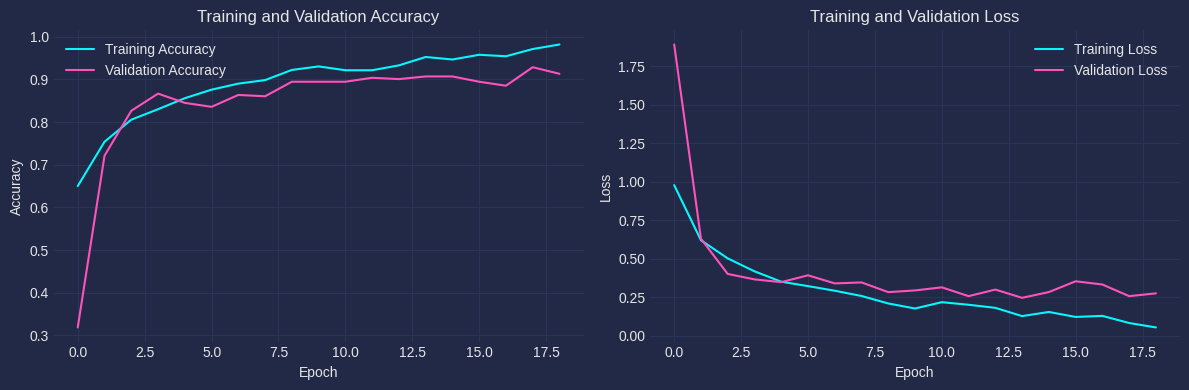

11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 637ms/step
Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.90      0.89      0.89        98
        no_tumor       0.93      0.90      0.91        48
meningioma_tumor       0.83      0.89      0.86        90
 pituitary_tumor       0.99      0.95      0.97        87

        accuracy                           0.91       323
       macro avg       0.91      0.91      0.91       323
    weighted avg       0.91      0.91      0.91       323



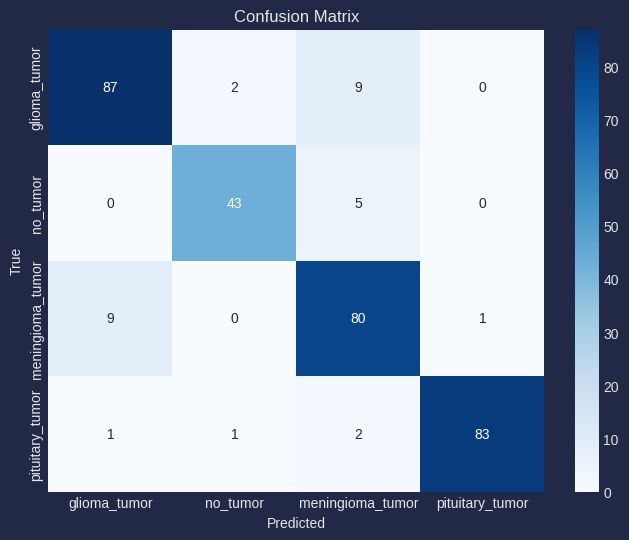

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import tensorflow.keras.applications as applications
import optuna

# ResNet101V2 modelini tanımlama
def create_resnet101v2_model(input_shape=(150, 150, 3), num_classes=4, dense1_units=256, dense2_units=128, dropout1_rate=0.4, dropout2_rate=0.3):
    # ResNet101V2 modelini ImageNet ağırlıkları ile yüklüyoruz
    base_model = applications.ResNet101V2(weights='imagenet', include_top=False, input_shape=input_shape)

    # İlk etapta temel modeli eğitilebilir yapmıyoruz (transfer öğrenme için)
    base_model.trainable = False

    # Modeli oluşturuyoruz
    model = Sequential([
        base_model,  # ResNet101V2 temel model
        GlobalAveragePooling2D(),  # Özellikleri ortalama alarak küçült
        BatchNormalization(),  # Normalizasyon
        Dense(dense1_units, activation='relu'),  # İlk tam bağlantılı katman
        Dropout(dropout1_rate),  # İlk dropout
        Dense(dense2_units, activation='relu'),  # İkinci tam bağlantılı katman
        Dropout(dropout2_rate),  # İkinci dropout
        Dense(num_classes, activation='softmax')  # Çıkış katmanı (4 sınıf)
    ])

    return model

# Optuna objective fonksiyonu
def objective(trial):
    # Hiperparametre aralıklarını tanımlama
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    dense1_units = trial.suggest_int("dense1_units", 128, 512, step=64)
    dense2_units = trial.suggest_int("dense2_units", 64, 256, step=32)
    dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
    dropout2_rate = trial.suggest_uniform("dropout2_rate", 0.2, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # Modeli oluştur
    model = create_resnet101v2_model(
        dense1_units=dense1_units,
        dense2_units=dense2_units,
        dropout1_rate=dropout1_rate,
        dropout2_rate=dropout2_rate
    )

    # Modeli derle
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6
    )

    # Modeli eğit
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=10,  # Daha kısa süre için epoch sayısı azaltıldı
        batch_size=batch_size,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # En iyi doğrulama doğruluğunu döndür
    val_accuracy = max(history.history['val_accuracy'])

    # Belleği temizle
    tf.keras.backend.clear_session()

    return val_accuracy

# Optuna optimizasyonunu çalıştır
study = optuna.create_study(direction="maximize", study_name="resnet101v2_accuracy")
study.optimize(objective, n_trials=20)

# En iyi hiperparametreleri yazdır
print("\n=== Optimizasyon Sonuçları ===")
print("En iyi hiperparametreler: ", study.best_params)
print("En iyi validation accuracy: ", study.best_value)
print("En iyi trial numarası: ", study.best_trial.number)

# En iyi hiperparametrelerle modeli tekrar eğit
best_params = study.best_params
best_model = create_resnet101v2_model(
    dense1_units=best_params['dense1_units'],
    dense2_units=best_params['dense2_units'],
    dropout1_rate=best_params['dropout1_rate'],
    dropout2_rate=best_params['dropout2_rate']
)

# Modeli derle
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint = ModelCheckpoint(
    'best_model_optuna.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# En iyi modelle eğitimi tekrar yap
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Eğitim sonuçlarını görselleştirme
plt.figure(figsize=(12, 4))

# Accuracy grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Test seti üzerinde tahmin yapma
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Sınıflandırma raporu
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=labels))

# Karışıklık matrisi
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# **Optuna Hpo Resnet101(F1)**

[I 2025-04-23 13:49:32,816] A new study created in memory with name: resnet101v2_f1


GPU bulundu: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Optuna optimizasyonu başlıyor...

Trial 0 başladı:
Hiperparametreler: learning_rate=0.002927, dense1_units=512, dense2_units=128, dropout1_rate=0.38, dropout2_rate=0.36, batch_size=16


<ipython-input-16-3c7c3d3b33be>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-16-3c7c3d3b33be>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-16-3c7c3d3b33be>:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout2_rate = trial.suggest_uniform("dropout2_rate", 0.2, 0.5)


Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 36s 104ms/step - accuracy: 0.5322 - loss: 1.9365 - val_accuracy: 0.6563 - val_loss: 0.8148 - learning_rate: 0.0029
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6730 - loss: 0.7958 - val_accuracy: 0.7028 - val_loss: 0.6394 - learning_rate: 0.0029
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7071 - loss: 0.7463 - val_accuracy: 0.7337 - val_loss: 0.6280 - learning_rate: 0.0029
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7227 - loss: 0.6799 - val_accuracy: 0.8173 - val_loss: 0.4799 - learning_rate: 0.0029
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7627 - loss: 0.5773 - val_accuracy: 0.8142 - val_loss: 0.4823 - learning_rate: 0.0029
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7928 - loss: 0.5428 - val_accuracy: 0.8359 - val_loss: 0.4173 - learning_rate: 0.0029
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7979 - loss: 

[I 2025-04-23 13:50:51,780] Trial 0 finished with value: 0.8761265528672381 and parameters: {'learning_rate': 0.0029272318337824244, 'dense1_units': 512, 'dense2_units': 128, 'dropout1_rate': 0.3846161206052266, 'dropout2_rate': 0.3558452323458109, 'batch_size': 16}. Best is trial 0 with value: 0.8761265528672381.
<ipython-input-16-3c7c3d3b33be>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-16-3c7c3d3b33be>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-16-3c7c3d3b33be>:57: FutureWarning: suggest_uniform has been depre


Trial 1 başladı:
Hiperparametreler: learning_rate=0.000011, dense1_units=128, dense2_units=192, dropout1_rate=0.38, dropout2_rate=0.44, batch_size=32
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 36s 201ms/step - accuracy: 0.2786 - loss: 1.6182 - val_accuracy: 0.3467 - val_loss: 1.4152 - learning_rate: 1.0571e-05
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.3491 - loss: 1.4518 - val_accuracy: 0.4861 - val_loss: 1.2346 - learning_rate: 1.0571e-05
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.4040 - loss: 1.3454 - val_accuracy: 0.5511 - val_loss: 1.1350 - learning_rate: 1.0571e-05
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.4250 - loss: 1.2885 - val_accuracy: 0.5913 - val_loss: 1.0741 - learning_rate: 1.0571e-05
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.4699 - loss: 1.2430 - val_accuracy: 0.6099 - val_loss: 1.0315 - learning_rate: 1.0571e-05
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5034 - 

[I 2025-04-23 13:52:02,568] Trial 1 finished with value: 0.6103794678488195 and parameters: {'learning_rate': 1.0571276384445264e-05, 'dense1_units': 128, 'dense2_units': 192, 'dropout1_rate': 0.38424304331892156, 'dropout2_rate': 0.4443533155876308, 'batch_size': 32}. Best is trial 0 with value: 0.8761265528672381.
<ipython-input-16-3c7c3d3b33be>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-16-3c7c3d3b33be>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-16-3c7c3d3b33be>:57: FutureWarning: suggest_uniform has been dep


Trial 2 başladı:
Hiperparametreler: learning_rate=0.000083, dense1_units=320, dense2_units=128, dropout1_rate=0.23, dropout2_rate=0.23, batch_size=32
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 34s 177ms/step - accuracy: 0.4062 - loss: 1.3164 - val_accuracy: 0.4365 - val_loss: 1.4462 - learning_rate: 8.2949e-05
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6534 - loss: 0.8678 - val_accuracy: 0.6966 - val_loss: 0.7733 - learning_rate: 8.2949e-05
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7135 - loss: 0.7320 - val_accuracy: 0.7616 - val_loss: 0.6221 - learning_rate: 8.2949e-05
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7382 - loss: 0.6415 - val_accuracy: 0.7926 - val_loss: 0.5488 - learning_rate: 8.2949e-05
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7865 - loss: 0.5728 - val_accuracy: 0.8173 - val_loss: 0.5005 - learning_rate: 8.2949e-05
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7810 - 

[I 2025-04-23 13:53:11,791] Trial 2 finished with value: 0.8688785855970783 and parameters: {'learning_rate': 8.294943553339428e-05, 'dense1_units': 320, 'dense2_units': 128, 'dropout1_rate': 0.22947668823913764, 'dropout2_rate': 0.22751143574569804, 'batch_size': 32}. Best is trial 0 with value: 0.8761265528672381.
<ipython-input-16-3c7c3d3b33be>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-16-3c7c3d3b33be>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-16-3c7c3d3b33be>:57: FutureWarning: suggest_uniform has been dep


Trial 3 başladı:
Hiperparametreler: learning_rate=0.001017, dense1_units=320, dense2_units=96, dropout1_rate=0.44, dropout2_rate=0.40, batch_size=32
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 34s 177ms/step - accuracy: 0.5374 - loss: 1.2276 - val_accuracy: 0.3994 - val_loss: 1.6902 - learning_rate: 0.0010
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6663 - loss: 0.8259 - val_accuracy: 0.7368 - val_loss: 0.6719 - learning_rate: 0.0010
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7240 - loss: 0.6713 - val_accuracy: 0.7771 - val_loss: 0.5444 - learning_rate: 0.0010
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7584 - loss: 0.5924 - val_accuracy: 0.8297 - val_loss: 0.4482 - learning_rate: 0.0010
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7871 - loss: 0.5299 - val_accuracy: 0.8266 - val_loss: 0.4201 - learning_rate: 0.0010
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8017 - loss: 0.4933 - val_ac

[I 2025-04-23 13:54:20,716] Trial 3 finished with value: 0.8882248470156537 and parameters: {'learning_rate': 0.0010169586569927478, 'dense1_units': 320, 'dense2_units': 96, 'dropout1_rate': 0.43711573000217074, 'dropout2_rate': 0.40390210614611266, 'batch_size': 32}. Best is trial 3 with value: 0.8882248470156537.
<ipython-input-16-3c7c3d3b33be>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-16-3c7c3d3b33be>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-16-3c7c3d3b33be>:57: FutureWarning: suggest_uniform has been depr


Trial 4 başladı:
Hiperparametreler: learning_rate=0.000111, dense1_units=128, dense2_units=64, dropout1_rate=0.22, dropout2_rate=0.29, batch_size=16
Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 36s 100ms/step - accuracy: 0.4190 - loss: 1.3085 - val_accuracy: 0.6316 - val_loss: 0.8800 - learning_rate: 1.1101e-04
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6188 - loss: 0.9275 - val_accuracy: 0.7090 - val_loss: 0.7001 - learning_rate: 1.1101e-04
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6929 - loss: 0.7797 - val_accuracy: 0.7523 - val_loss: 0.6174 - learning_rate: 1.1101e-04
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7062 - loss: 0.7613 - val_accuracy: 0.7709 - val_loss: 0.5634 - learning_rate: 1.1101e-04
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7432 - loss: 0.6589 - val_accuracy: 0.7864 - val_loss: 0.5283 - learning_rate: 1.1101e-04
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy

[I 2025-04-23 13:55:40,937] Trial 4 finished with value: 0.848910912043602 and parameters: {'learning_rate': 0.0001110056327944453, 'dense1_units': 128, 'dense2_units': 64, 'dropout1_rate': 0.219738455709213, 'dropout2_rate': 0.29250760629020967, 'batch_size': 16}. Best is trial 3 with value: 0.8882248470156537.
<ipython-input-16-3c7c3d3b33be>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-16-3c7c3d3b33be>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-16-3c7c3d3b33be>:57: FutureWarning: suggest_uniform has been depreca


Trial 5 başladı:
Hiperparametreler: learning_rate=0.000155, dense1_units=448, dense2_units=192, dropout1_rate=0.42, dropout2_rate=0.36, batch_size=16
Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 37s 103ms/step - accuracy: 0.5052 - loss: 1.2769 - val_accuracy: 0.6904 - val_loss: 0.7627 - learning_rate: 1.5545e-04
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6818 - loss: 0.8143 - val_accuracy: 0.7616 - val_loss: 0.5586 - learning_rate: 1.5545e-04
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7135 - loss: 0.7184 - val_accuracy: 0.8050 - val_loss: 0.4903 - learning_rate: 1.5545e-04
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7513 - loss: 0.6159 - val_accuracy: 0.8297 - val_loss: 0.4346 - learning_rate: 1.5545e-04
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7857 - loss: 0.5333 - val_accuracy: 0.8359 - val_loss: 0.3923 - learning_rate: 1.5545e-04
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accurac

[I 2025-04-23 13:57:03,213] Trial 5 finished with value: 0.8827998281922275 and parameters: {'learning_rate': 0.00015544594338399455, 'dense1_units': 448, 'dense2_units': 192, 'dropout1_rate': 0.41827537032286655, 'dropout2_rate': 0.3617099051691989, 'batch_size': 16}. Best is trial 3 with value: 0.8882248470156537.
<ipython-input-16-3c7c3d3b33be>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-16-3c7c3d3b33be>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-16-3c7c3d3b33be>:57: FutureWarning: suggest_uniform has been dep


Trial 6 başladı:
Hiperparametreler: learning_rate=0.000044, dense1_units=256, dense2_units=64, dropout1_rate=0.50, dropout2_rate=0.43, batch_size=64
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 35s 387ms/step - accuracy: 0.2957 - loss: 1.7409 - val_accuracy: 0.3498 - val_loss: 1.8654 - learning_rate: 4.4494e-05
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4381 - loss: 1.3164 - val_accuracy: 0.4427 - val_loss: 1.2941 - learning_rate: 4.4494e-05
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5143 - loss: 1.1612 - val_accuracy: 0.5789 - val_loss: 1.0189 - learning_rate: 4.4494e-05
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5652 - loss: 1.0642 - val_accuracy: 0.6594 - val_loss: 0.8741 - learning_rate: 4.4494e-05
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5566 - loss: 1.0783 - val_accuracy: 0.7028 - val_loss: 0.8064 - learning_rate: 4.4494e-05
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5928 - l

[I 2025-04-23 13:58:10,287] Trial 6 finished with value: 0.738082313663709 and parameters: {'learning_rate': 4.449407034844014e-05, 'dense1_units': 256, 'dense2_units': 64, 'dropout1_rate': 0.4958605707090749, 'dropout2_rate': 0.43199473966685636, 'batch_size': 64}. Best is trial 3 with value: 0.8882248470156537.
<ipython-input-16-3c7c3d3b33be>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-16-3c7c3d3b33be>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-16-3c7c3d3b33be>:57: FutureWarning: suggest_uniform has been deprec


Trial 7 başladı:
Hiperparametreler: learning_rate=0.000411, dense1_units=320, dense2_units=160, dropout1_rate=0.42, dropout2_rate=0.44, batch_size=64
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 38s 441ms/step - accuracy: 0.4566 - loss: 1.3202 - val_accuracy: 0.1579 - val_loss: 3.5243 - learning_rate: 4.1108e-04
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6772 - loss: 0.8296 - val_accuracy: 0.4458 - val_loss: 1.3092 - learning_rate: 4.1108e-04
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7360 - loss: 0.6768 - val_accuracy: 0.6594 - val_loss: 0.7916 - learning_rate: 4.1108e-04
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7670 - loss: 0.6052 - val_accuracy: 0.7616 - val_loss: 0.5556 - learning_rate: 4.1108e-04
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7974 - loss: 0.5029 - val_accuracy: 0.8019 - val_loss: 0.4681 - learning_rate: 4.1108e-04
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8100 - 

[I 2025-04-23 13:59:21,445] Trial 7 finished with value: 0.8676165774790039 and parameters: {'learning_rate': 0.00041108144953842703, 'dense1_units': 320, 'dense2_units': 160, 'dropout1_rate': 0.4188533155132469, 'dropout2_rate': 0.4416010863543055, 'batch_size': 64}. Best is trial 3 with value: 0.8882248470156537.
<ipython-input-16-3c7c3d3b33be>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-16-3c7c3d3b33be>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-16-3c7c3d3b33be>:57: FutureWarning: suggest_uniform has been depr


Trial 8 başladı:
Hiperparametreler: learning_rate=0.000534, dense1_units=192, dense2_units=64, dropout1_rate=0.46, dropout2_rate=0.50, batch_size=64
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 35s 383ms/step - accuracy: 0.4357 - loss: 1.4639 - val_accuracy: 0.3220 - val_loss: 2.2811 - learning_rate: 5.3414e-04
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6064 - loss: 1.0062 - val_accuracy: 0.4458 - val_loss: 1.3370 - learning_rate: 5.3414e-04
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6892 - loss: 0.7901 - val_accuracy: 0.6006 - val_loss: 0.9111 - learning_rate: 5.3414e-04
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6842 - loss: 0.7539 - val_accuracy: 0.7152 - val_loss: 0.6711 - learning_rate: 5.3414e-04
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7406 - loss: 0.6390 - val_accuracy: 0.7492 - val_loss: 0.5695 - learning_rate: 5.3414e-04
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7569 - l

[I 2025-04-23 14:00:29,156] Trial 8 finished with value: 0.8553289456221195 and parameters: {'learning_rate': 0.0005341433299530964, 'dense1_units': 192, 'dense2_units': 64, 'dropout1_rate': 0.4590075044651217, 'dropout2_rate': 0.4996563903209808, 'batch_size': 64}. Best is trial 3 with value: 0.8882248470156537.
<ipython-input-16-3c7c3d3b33be>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-16-3c7c3d3b33be>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-16-3c7c3d3b33be>:57: FutureWarning: suggest_uniform has been deprec


Trial 9 başladı:
Hiperparametreler: learning_rate=0.002265, dense1_units=448, dense2_units=96, dropout1_rate=0.22, dropout2_rate=0.46, batch_size=16
Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 38s 109ms/step - accuracy: 0.5103 - loss: 1.5904 - val_accuracy: 0.6749 - val_loss: 0.7806 - learning_rate: 0.0023
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6463 - loss: 0.8502 - val_accuracy: 0.7090 - val_loss: 0.6098 - learning_rate: 0.0023
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6907 - loss: 0.7481 - val_accuracy: 0.7616 - val_loss: 0.5836 - learning_rate: 0.0023
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7285 - loss: 0.6854 - val_accuracy: 0.8050 - val_loss: 0.4704 - learning_rate: 0.0023
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7675 - loss: 0.5793 - val_accuracy: 0.8050 - val_loss: 0.4030 - learning_rate: 0.0023
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7854 - loss: 0.5

[I 2025-04-23 14:01:53,076] Trial 9 finished with value: 0.8755960539071248 and parameters: {'learning_rate': 0.0022648987252047725, 'dense1_units': 448, 'dense2_units': 96, 'dropout1_rate': 0.21757550218351468, 'dropout2_rate': 0.4550023774399555, 'batch_size': 16}. Best is trial 3 with value: 0.8882248470156537.
<ipython-input-16-3c7c3d3b33be>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-16-3c7c3d3b33be>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-16-3c7c3d3b33be>:57: FutureWarning: suggest_uniform has been depre


Trial 10 başladı:
Hiperparametreler: learning_rate=0.008461, dense1_units=256, dense2_units=256, dropout1_rate=0.31, dropout2_rate=0.30, batch_size=32
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 36s 202ms/step - accuracy: 0.4962 - loss: 2.1379 - val_accuracy: 0.3282 - val_loss: 1.6470 - learning_rate: 0.0085
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6684 - loss: 0.8148 - val_accuracy: 0.7368 - val_loss: 0.6997 - learning_rate: 0.0085
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7289 - loss: 0.7159 - val_accuracy: 0.7864 - val_loss: 0.5715 - learning_rate: 0.0085
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7494 - loss: 0.6336 - val_accuracy: 0.7802 - val_loss: 0.5473 - learning_rate: 0.0085
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7692 - loss: 0.6241 - val_accuracy: 0.8050 - val_loss: 0.4642 - learning_rate: 0.0085
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8201 - loss: 0.4806 - val_

[I 2025-04-23 14:03:04,173] Trial 10 finished with value: 0.8828292709437244 and parameters: {'learning_rate': 0.008461267168650203, 'dense1_units': 256, 'dense2_units': 256, 'dropout1_rate': 0.3057867047231778, 'dropout2_rate': 0.30311241024182534, 'batch_size': 32}. Best is trial 3 with value: 0.8882248470156537.
<ipython-input-16-3c7c3d3b33be>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-16-3c7c3d3b33be>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-16-3c7c3d3b33be>:57: FutureWarning: suggest_uniform has been depr


Trial 11 başladı:
Hiperparametreler: learning_rate=0.009293, dense1_units=256, dense2_units=256, dropout1_rate=0.30, dropout2_rate=0.29, batch_size=32
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 34s 176ms/step - accuracy: 0.5111 - loss: 2.4971 - val_accuracy: 0.4087 - val_loss: 1.3033 - learning_rate: 0.0093
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6967 - loss: 0.7477 - val_accuracy: 0.6811 - val_loss: 0.7597 - learning_rate: 0.0093
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7495 - loss: 0.6454 - val_accuracy: 0.7399 - val_loss: 0.6223 - learning_rate: 0.0093
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7534 - loss: 0.6964 - val_accuracy: 0.7430 - val_loss: 0.5564 - learning_rate: 0.0093
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7711 - loss: 0.6038 - val_accuracy: 0.7802 - val_loss: 0.5412 - learning_rate: 0.0093
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7862 - loss: 0.5738 - val_

[I 2025-04-23 14:04:12,542] Trial 11 finished with value: 0.8700256593865616 and parameters: {'learning_rate': 0.00929277225736775, 'dense1_units': 256, 'dense2_units': 256, 'dropout1_rate': 0.29528313059573086, 'dropout2_rate': 0.2938414709239038, 'batch_size': 32}. Best is trial 3 with value: 0.8882248470156537.
<ipython-input-16-3c7c3d3b33be>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-16-3c7c3d3b33be>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-16-3c7c3d3b33be>:57: FutureWarning: suggest_uniform has been depre


Trial 12 başladı:
Hiperparametreler: learning_rate=0.009593, dense1_units=320, dense2_units=256, dropout1_rate=0.30, dropout2_rate=0.30, batch_size=32
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 37s 211ms/step - accuracy: 0.4970 - loss: 2.7840 - val_accuracy: 0.3406 - val_loss: 1.7299 - learning_rate: 0.0096
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6795 - loss: 0.8545 - val_accuracy: 0.6563 - val_loss: 0.7908 - learning_rate: 0.0096
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7036 - loss: 0.6947 - val_accuracy: 0.7399 - val_loss: 0.6028 - learning_rate: 0.0096
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7392 - loss: 0.6728 - val_accuracy: 0.7616 - val_loss: 0.5386 - learning_rate: 0.0096
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7545 - loss: 0.6558 - val_accuracy: 0.7895 - val_loss: 0.5302 - learning_rate: 0.0096
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7743 - loss: 0.6365 - val_

[I 2025-04-23 14:05:24,909] Trial 12 finished with value: 0.8262717948847456 and parameters: {'learning_rate': 0.009592872487222397, 'dense1_units': 320, 'dense2_units': 256, 'dropout1_rate': 0.3040948576077925, 'dropout2_rate': 0.3009423922630106, 'batch_size': 32}. Best is trial 3 with value: 0.8882248470156537.
<ipython-input-16-3c7c3d3b33be>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-16-3c7c3d3b33be>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-16-3c7c3d3b33be>:57: FutureWarning: suggest_uniform has been depre


Trial 13 başladı:
Hiperparametreler: learning_rate=0.001571, dense1_units=384, dense2_units=224, dropout1_rate=0.32, dropout2_rate=0.39, batch_size=32
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 37s 215ms/step - accuracy: 0.5549 - loss: 1.3273 - val_accuracy: 0.4737 - val_loss: 1.4479 - learning_rate: 0.0016
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7207 - loss: 0.6859 - val_accuracy: 0.7337 - val_loss: 0.5717 - learning_rate: 0.0016
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7772 - loss: 0.5462 - val_accuracy: 0.7647 - val_loss: 0.5872 - learning_rate: 0.0016
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7927 - loss: 0.5246 - val_accuracy: 0.8297 - val_loss: 0.4089 - learning_rate: 0.0016
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8453 - loss: 0.3841 - val_accuracy: 0.8483 - val_loss: 0.3986 - learning_rate: 0.0016
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8619 - loss: 0.3550 - val_

[I 2025-04-23 14:06:38,309] Trial 13 finished with value: 0.8905008909496797 and parameters: {'learning_rate': 0.001571139423114738, 'dense1_units': 384, 'dense2_units': 224, 'dropout1_rate': 0.3235681218400211, 'dropout2_rate': 0.39158169165390155, 'batch_size': 32}. Best is trial 13 with value: 0.8905008909496797.
<ipython-input-16-3c7c3d3b33be>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-16-3c7c3d3b33be>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-16-3c7c3d3b33be>:57: FutureWarning: suggest_uniform has been dep


Trial 14 başladı:
Hiperparametreler: learning_rate=0.001224, dense1_units=384, dense2_units=192, dropout1_rate=0.35, dropout2_rate=0.39, batch_size=32
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 36s 195ms/step - accuracy: 0.5733 - loss: 1.1738 - val_accuracy: 0.4613 - val_loss: 1.4304 - learning_rate: 0.0012
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7235 - loss: 0.7100 - val_accuracy: 0.7461 - val_loss: 0.5893 - learning_rate: 0.0012
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7639 - loss: 0.5924 - val_accuracy: 0.8019 - val_loss: 0.4777 - learning_rate: 0.0012
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8018 - loss: 0.5050 - val_accuracy: 0.8328 - val_loss: 0.3802 - learning_rate: 0.0012
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8510 - loss: 0.3850 - val_accuracy: 0.8545 - val_loss: 0.3481 - learning_rate: 0.0012
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8573 - loss: 0.3669 - val_

[I 2025-04-23 14:07:50,184] Trial 14 finished with value: 0.9068748844971788 and parameters: {'learning_rate': 0.0012242853712765612, 'dense1_units': 384, 'dense2_units': 192, 'dropout1_rate': 0.34991549299128805, 'dropout2_rate': 0.3902594828536471, 'batch_size': 32}. Best is trial 14 with value: 0.9068748844971788.
<ipython-input-16-3c7c3d3b33be>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-16-3c7c3d3b33be>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-16-3c7c3d3b33be>:57: FutureWarning: suggest_uniform has been de


Trial 15 başladı:
Hiperparametreler: learning_rate=0.001518, dense1_units=448, dense2_units=224, dropout1_rate=0.34, dropout2_rate=0.39, batch_size=32
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 37s 213ms/step - accuracy: 0.5694 - loss: 1.3009 - val_accuracy: 0.4087 - val_loss: 1.4684 - learning_rate: 0.0015
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7363 - loss: 0.6935 - val_accuracy: 0.7121 - val_loss: 0.6505 - learning_rate: 0.0015
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7752 - loss: 0.5728 - val_accuracy: 0.7740 - val_loss: 0.5164 - learning_rate: 0.0015
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8162 - loss: 0.4705 - val_accuracy: 0.8173 - val_loss: 0.4414 - learning_rate: 0.0015
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8520 - loss: 0.4002 - val_accuracy: 0.8111 - val_loss: 0.4325 - learning_rate: 0.0015
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8524 - loss: 0.3660 - val_

[I 2025-04-23 14:09:04,133] Trial 15 finished with value: 0.8958815097945534 and parameters: {'learning_rate': 0.0015183557918501491, 'dense1_units': 448, 'dense2_units': 224, 'dropout1_rate': 0.341384118211506, 'dropout2_rate': 0.3882990920835081, 'batch_size': 32}. Best is trial 14 with value: 0.9068748844971788.
<ipython-input-16-3c7c3d3b33be>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-16-3c7c3d3b33be>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-16-3c7c3d3b33be>:57: FutureWarning: suggest_uniform has been depr


Trial 16 başladı:
Hiperparametreler: learning_rate=0.000768, dense1_units=512, dense2_units=192, dropout1_rate=0.35, dropout2_rate=0.39, batch_size=32
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 36s 209ms/step - accuracy: 0.5822 - loss: 1.1458 - val_accuracy: 0.3313 - val_loss: 1.6551 - learning_rate: 7.6791e-04
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7340 - loss: 0.6984 - val_accuracy: 0.7028 - val_loss: 0.6692 - learning_rate: 7.6791e-04
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7687 - loss: 0.5526 - val_accuracy: 0.7802 - val_loss: 0.5648 - learning_rate: 7.6791e-04
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8123 - loss: 0.4785 - val_accuracy: 0.8390 - val_loss: 0.4263 - learning_rate: 7.6791e-04
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8214 - loss: 0.4374 - val_accuracy: 0.8421 - val_loss: 0.3720 - learning_rate: 7.6791e-04
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8548 -

[I 2025-04-23 14:10:17,141] Trial 16 finished with value: 0.9083689217349935 and parameters: {'learning_rate': 0.0007679092125368899, 'dense1_units': 512, 'dense2_units': 192, 'dropout1_rate': 0.3533652630419005, 'dropout2_rate': 0.3933896739803389, 'batch_size': 32}. Best is trial 16 with value: 0.9083689217349935.
<ipython-input-16-3c7c3d3b33be>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-16-3c7c3d3b33be>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-16-3c7c3d3b33be>:57: FutureWarning: suggest_uniform has been dep


Trial 17 başladı:
Hiperparametreler: learning_rate=0.000658, dense1_units=512, dense2_units=192, dropout1_rate=0.26, dropout2_rate=0.33, batch_size=32
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 34s 182ms/step - accuracy: 0.5892 - loss: 1.0703 - val_accuracy: 0.5820 - val_loss: 0.9963 - learning_rate: 6.5820e-04
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7742 - loss: 0.5800 - val_accuracy: 0.7492 - val_loss: 0.5941 - learning_rate: 6.5820e-04
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8259 - loss: 0.4614 - val_accuracy: 0.7647 - val_loss: 0.5426 - learning_rate: 6.5820e-04
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8661 - loss: 0.3630 - val_accuracy: 0.8235 - val_loss: 0.4195 - learning_rate: 6.5820e-04
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8735 - loss: 0.3385 - val_accuracy: 0.8235 - val_loss: 0.3980 - learning_rate: 6.5820e-04
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8953 -

[I 2025-04-23 14:11:27,489] Trial 17 finished with value: 0.9175289512124541 and parameters: {'learning_rate': 0.000658201808365171, 'dense1_units': 512, 'dense2_units': 192, 'dropout1_rate': 0.2594714018317468, 'dropout2_rate': 0.3339976939592532, 'batch_size': 32}. Best is trial 17 with value: 0.9175289512124541.
<ipython-input-16-3c7c3d3b33be>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-16-3c7c3d3b33be>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-16-3c7c3d3b33be>:57: FutureWarning: suggest_uniform has been depr


Trial 18 başladı:
Hiperparametreler: learning_rate=0.000262, dense1_units=512, dense2_units=160, dropout1_rate=0.26, dropout2_rate=0.25, batch_size=32
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 37s 212ms/step - accuracy: 0.5574 - loss: 1.0978 - val_accuracy: 0.3251 - val_loss: 1.5625 - learning_rate: 2.6205e-04
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7516 - loss: 0.6485 - val_accuracy: 0.7430 - val_loss: 0.6005 - learning_rate: 2.6205e-04
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8117 - loss: 0.4839 - val_accuracy: 0.8019 - val_loss: 0.4442 - learning_rate: 2.6205e-04
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8390 - loss: 0.4242 - val_accuracy: 0.8359 - val_loss: 0.3796 - learning_rate: 2.6205e-04
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8768 - loss: 0.3340 - val_accuracy: 0.8731 - val_loss: 0.3281 - learning_rate: 2.6205e-04
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8905 -

[I 2025-04-23 14:12:41,093] Trial 18 finished with value: 0.9116146081420472 and parameters: {'learning_rate': 0.0002620502392043626, 'dense1_units': 512, 'dense2_units': 160, 'dropout1_rate': 0.2553375499461382, 'dropout2_rate': 0.2510341297351294, 'batch_size': 32}. Best is trial 17 with value: 0.9175289512124541.
<ipython-input-16-3c7c3d3b33be>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-16-3c7c3d3b33be>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-16-3c7c3d3b33be>:57: FutureWarning: suggest_uniform has been dep


Trial 19 başladı:
Hiperparametreler: learning_rate=0.000279, dense1_units=512, dense2_units=160, dropout1_rate=0.26, dropout2_rate=0.21, batch_size=64
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 35s 380ms/step - accuracy: 0.5431 - loss: 1.1114 - val_accuracy: 0.1703 - val_loss: 3.1989 - learning_rate: 2.7851e-04
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7677 - loss: 0.6001 - val_accuracy: 0.4954 - val_loss: 1.2309 - learning_rate: 2.7851e-04
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8187 - loss: 0.4801 - val_accuracy: 0.6904 - val_loss: 0.6996 - learning_rate: 2.7851e-04
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8526 - loss: 0.3973 - val_accuracy: 0.7771 - val_loss: 0.5191 - learning_rate: 2.7851e-04
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8646 - loss: 0.3461 - val_accuracy: 0.8390 - val_loss: 0.4606 - learning_rate: 2.7851e-04
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8940 -

[I 2025-04-23 14:13:47,324] Trial 19 finished with value: 0.9070860852673481 and parameters: {'learning_rate': 0.00027851138492033866, 'dense1_units': 512, 'dense2_units': 160, 'dropout1_rate': 0.25778557298520377, 'dropout2_rate': 0.20887024023690912, 'batch_size': 64}. Best is trial 17 with value: 0.9175289512124541.



=== Optimizasyon Sonuçları ===
En iyi hiperparametreler:  {'learning_rate': 0.000658201808365171, 'dense1_units': 512, 'dense2_units': 192, 'dropout1_rate': 0.2594714018317468, 'dropout2_rate': 0.3339976939592532, 'batch_size': 32}
En iyi F1 skoru:  0.9175289512124541
En iyi trial numarası:  17
Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5760 - loss: 1.0901

91/91 ━━━━━━━━━━━━━━━━━━━━ 34s 183ms/step - accuracy: 0.5768 - loss: 1.0882 - val_accuracy: 0.4551 - val_loss: 1.3479 - learning_rate: 6.5820e-04
Epoch 2/20
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7581 - loss: 0.6144

91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7582 - loss: 0.6143 - val_accuracy: 0.6873 - val_loss: 0.7429 - learning_rate: 6.5820e-04
Epoch 3/20
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8122 - loss: 0.4767

91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8121 - loss: 0.4770 - val_accuracy: 0.8173 - val_loss: 0.4441 - learning_rate: 6.5820e-04
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8422 - loss: 0.3982

91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8423 - loss: 0.3981 - val_accuracy: 0.8390 - val_loss: 0.4163 - learning_rate: 6.5820e-04
Epoch 5/20
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8523 - loss: 0.3638

91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8528 - loss: 0.3632 - val_accuracy: 0.8452 - val_loss: 0.3867 - learning_rate: 6.5820e-04
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8918 - loss: 0.2791

91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8918 - loss: 0.2794 - val_accuracy: 0.8824 - val_loss: 0.2883 - learning_rate: 6.5820e-04
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9104 - loss: 0.2376 - val_accuracy: 0.8607 - val_loss: 0.3223 - learning_rate: 6.5820e-04
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9136 - loss: 0.2204 - val_accuracy: 0.8824 - val_loss: 0.2779 - learning_rate: 6.5820e-04
Epoch 9/20
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9208 - loss: 0.2124

91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9205 - loss: 0.2132 - val_accuracy: 0.8978 - val_loss: 0.2606 - learning_rate: 6.5820e-04
Epoch 10/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9278 - loss: 0.1890

91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9279 - loss: 0.1888 - val_accuracy: 0.9102 - val_loss: 0.2490 - learning_rate: 6.5820e-04
Epoch 11/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9390 - loss: 0.1427 - val_accuracy: 0.9009 - val_loss: 0.2605 - learning_rate: 6.5820e-04
Epoch 12/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9477 - loss: 0.1438 - val_accuracy: 0.9009 - val_loss: 0.2653 - learning_rate: 6.5820e-04
Epoch 13/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9520 - loss: 0.1338 - val_accuracy: 0.8638 - val_loss: 0.3545 - learning_rate: 6.5820e-04
Epoch 14/20
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9513 - loss: 0.1337

91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9516 - loss: 0.1328 - val_accuracy: 0.9133 - val_loss: 0.2417 - learning_rate: 1.3164e-04
Epoch 15/20
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9714 - loss: 0.0789

91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9713 - loss: 0.0791 - val_accuracy: 0.9288 - val_loss: 0.2142 - learning_rate: 1.3164e-04
Epoch 16/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9800 - loss: 0.0674 - val_accuracy: 0.9195 - val_loss: 0.2131 - learning_rate: 1.3164e-04
Epoch 17/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9789 - loss: 0.0595 - val_accuracy: 0.9288 - val_loss: 0.2158 - learning_rate: 1.3164e-04
Epoch 18/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9835 - loss: 0.0507 - val_accuracy: 0.9226 - val_loss: 0.2260 - learning_rate: 1.3164e-04
Epoch 19/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9773 - loss: 0.0577 - val_accuracy: 0.9226 - val_loss: 0.2186 - learning_rate: 1.3164e-04
Epoch 20/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9870 - loss: 0.0431 - val_accuracy: 0.9257 - val_loss: 0.2200 - learning_rate: 2.6328e-05


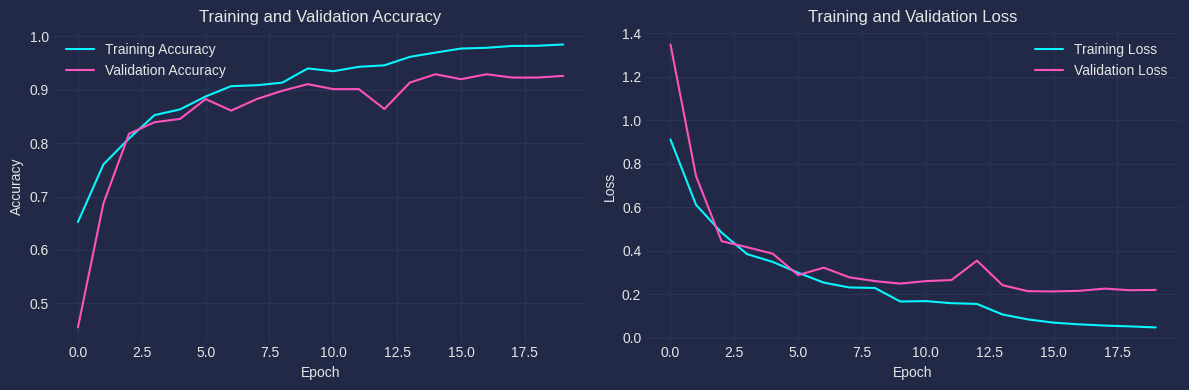

11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 623ms/step
Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.86      0.92      0.89        98
        no_tumor       0.98      0.92      0.95        48
meningioma_tumor       0.89      0.84      0.87        90
 pituitary_tumor       0.99      1.00      0.99        87

        accuracy                           0.92       323
       macro avg       0.93      0.92      0.92       323
    weighted avg       0.92      0.92      0.92       323



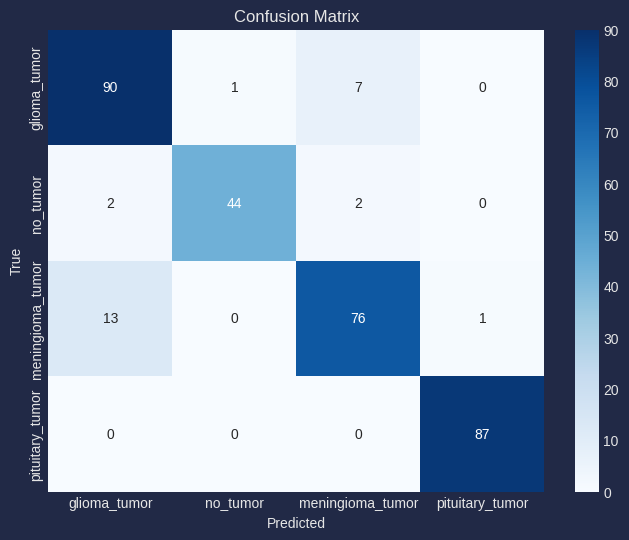

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tqdm import tqdm
import tensorflow.keras.applications as applications
import optuna

# GPU yapılandırmasını kontrol et
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print(f"GPU bulundu: {physical_devices}")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)  # Bellek büyümesini etkinleştir
else:
    print("GPU bulunamadı, CPU kullanılacak.")

# ResNet101V2 modelini tanımlama
def create_resnet101v2_model(input_shape=(150, 150, 3), num_classes=4, dense1_units=256, dense2_units=128, dropout1_rate=0.4, dropout2_rate=0.3):
    # ResNet101V2 modelini ImageNet ağırlıkları ile yüklüyoruz
    base_model = applications.ResNet101V2(weights='imagenet', include_top=False, input_shape=input_shape)

    # İlk etapta temel modeli eğitilebilir yapmıyoruz (transfer öğrenme için)
    base_model.trainable = False

    # Modeli oluşturuyoruz
    model = Sequential([
        base_model,  # ResNet101V2 temel model
        GlobalAveragePooling2D(),  # Özellikleri ortalama alarak küçült
        BatchNormalization(),  # Normalizasyon
        Dense(dense1_units, activation='relu'),  # İlk tam bağlantılı katman
        Dropout(dropout1_rate),  # İlk dropout
        Dense(dense2_units, activation='relu'),  # İkinci tam bağlantılı katman
        Dropout(dropout2_rate),  # İkinci dropout
        Dense(num_classes, activation='softmax')  # Çıkış katmanı (4 sınıf)
    ])

    return model

# Optuna objective fonksiyonu
def objective(trial):
    # Hiperparametre aralıklarını tanımlama
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    dense1_units = trial.suggest_int("dense1_units", 128, 512, step=64)
    dense2_units = trial.suggest_int("dense2_units", 64, 256, step=32)
    dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
    dropout2_rate = trial.suggest_uniform("dropout2_rate", 0.2, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    print(f"\nTrial {trial.number} başladı:")
    print(f"Hiperparametreler: learning_rate={learning_rate:.6f}, dense1_units={dense1_units}, "
          f"dense2_units={dense2_units}, dropout1_rate={dropout1_rate:.2f}, dropout2_rate={dropout2_rate:.2f}, "
          f"batch_size={batch_size}")

    try:
        # Modeli oluştur
        model = create_resnet101v2_model(
            dense1_units=dense1_units,
            dense2_units=dense2_units,
            dropout1_rate=dropout1_rate,
            dropout2_rate=dropout2_rate
        )

        # Modeli derle
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2,
            min_lr=1e-6
        )

        # Modeli eğit
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=10,  # Daha kısa süre için epoch sayısı
            batch_size=batch_size,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        # Test seti üzerinde tahmin yapma
        y_pred = model.predict(X_test, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test, axis=1)

        # F1 skorunu hesapla (macro)
        f1 = f1_score(y_true_classes, y_pred_classes, average='macro')
        print(f"F1 Skoru (macro): {f1:.4f}")

        # Belleği temizle
        tf.keras.backend.clear_session()

        return f1

    except Exception as e:
        print(f"Trial {trial.number} hata ile sonuçlandı: {e}")
        raise

# Optuna optimizasyonunu çalıştır
print("Optuna optimizasyonu başlıyor...")
study = optuna.create_study(direction="maximize", study_name="resnet101v2_f1")
try:
    study.optimize(objective, n_trials=20)  # 20 deneme
except KeyboardInterrupt:
    print("Optimizasyon kullanıcı tarafından durduruldu.")

# En iyi hiperparametreleri yazdır
print("\n=== Optimizasyon Sonuçları ===")
print("En iyi hiperparametreler: ", study.best_params)
print("En iyi F1 skoru: ", study.best_value)
print("En iyi trial numarası: ", study.best_trial.number)

# En iyi hiperparametrelerle modeli tekrar eğit
best_params = study.best_params
best_model = create_resnet101v2_model(
    dense1_units=best_params['dense1_units'],
    dense2_units=best_params['dense2_units'],
    dropout1_rate=best_params['dropout1_rate'],
    dropout2_rate=best_params['dropout2_rate']
)

# Modeli derle
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint = ModelCheckpoint(
    'best_model_optuna_f1.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# En iyi modelle eğitimi tekrar yap
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Eğitim sonuçlarını görselleştirme
plt.figure(figsize=(12, 4))

# Accuracy grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Test seti üzerinde tahmin yapma
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Sınıflandırma raporu
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=labels))

# Karışıklık matrisi
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# **Optuna Hpo Xception(Accuracy)**

[I 2025-04-23 14:15:28,166] A new study created in memory with name: xception_accuracy
<ipython-input-17-a6608e45c4a1>:45: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-17-a6608e45c4a1>:48: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-17-a6608e45c4a1>:49: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout2_rate = trial.suggest_uniform("dropout2_rate", 0.2, 0.5)


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.4648 - loss: 2.2244 - val_accuracy: 0.6347 - val_loss: 0.8850 - learning_rate: 0.0029
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6535 - loss: 0.8084 - val_accuracy: 0.7245 - val_loss: 0.7312 - learning_rate: 0.0029
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7113 - loss: 0.7047 - val_accuracy: 0.7121 - val_loss: 0.6937 - learning_rate: 0.0029
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7513 - loss: 0.6530 - val_accuracy: 0.6780 - val_loss: 1.0253 - learning_rate: 0.0029
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7899 - loss: 0.5478 - val_accuracy: 0.7492 - val_loss: 0.7629 - learning_rate: 0.0029
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8505 - loss: 0.3781 - val_accuracy: 0.7864 - val_loss: 0.6779 - learning_rate: 5.7656e-04
Epoch 7/10
182/182 ━━━━━━━

[I 2025-04-23 14:16:21,716] Trial 0 finished with value: 0.7987616062164307 and parameters: {'learning_rate': 0.0028827770127168094, 'dense1_units': 512, 'dense2_units': 256, 'dropout1_rate': 0.21458284951948609, 'dropout2_rate': 0.3176927086203354, 'batch_size': 16}. Best is trial 0 with value: 0.7987616062164307.


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 33s 318ms/step - accuracy: 0.3067 - loss: 1.7529 - val_accuracy: 0.4149 - val_loss: 1.2539 - learning_rate: 6.1496e-05
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4029 - loss: 1.4741 - val_accuracy: 0.5232 - val_loss: 1.0769 - learning_rate: 6.1496e-05
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4987 - loss: 1.2404 - val_accuracy: 0.6161 - val_loss: 0.9615 - learning_rate: 6.1496e-05
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5247 - loss: 1.1463 - val_accuracy: 0.6780 - val_loss: 0.8895 - learning_rate: 6.1496e-05
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5774 - loss: 1.0236 - val_accuracy: 0.6656 - val_loss: 0.8499 - learning_rate: 6.1496e-05
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6261 - loss: 0.9511 - val_accuracy: 0.6842 - val_loss: 0.8141 - learning_rate: 6.1496e-05
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.617

[I 2025-04-23 14:17:08,902] Trial 1 finished with value: 0.7306501269340515 and parameters: {'learning_rate': 6.149582884134287e-05, 'dense1_units': 512, 'dense2_units': 160, 'dropout1_rate': 0.4669504007647389, 'dropout2_rate': 0.39657403546011893, 'batch_size': 64}. Best is trial 0 with value: 0.7987616062164307.


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 28s 122ms/step - accuracy: 0.3942 - loss: 1.4110 - val_accuracy: 0.5232 - val_loss: 1.0711 - learning_rate: 1.4664e-04
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6500 - loss: 0.8688 - val_accuracy: 0.6718 - val_loss: 0.8380 - learning_rate: 1.4664e-04
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7239 - loss: 0.6952 - val_accuracy: 0.7245 - val_loss: 0.7180 - learning_rate: 1.4664e-04
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7691 - loss: 0.6019 - val_accuracy: 0.7121 - val_loss: 0.6677 - learning_rate: 1.4664e-04
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7935 - loss: 0.5407 - val_accuracy: 0.7523 - val_loss: 0.6194 - learning_rate: 1.4664e-04
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8214 - loss: 0.4647 - val_accuracy: 0.7554 - val_loss: 0.5639 - learning_rate: 1.4664e-04
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.826

[I 2025-04-23 14:17:53,722] Trial 2 finished with value: 0.7832817435264587 and parameters: {'learning_rate': 0.0001466394798377643, 'dense1_units': 256, 'dense2_units': 96, 'dropout1_rate': 0.20447869593427082, 'dropout2_rate': 0.20813471747942472, 'batch_size': 32}. Best is trial 0 with value: 0.7987616062164307.


Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 19s 58ms/step - accuracy: 0.3684 - loss: 1.4179 - val_accuracy: 0.6625 - val_loss: 0.9482 - learning_rate: 1.5058e-04
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5709 - loss: 1.0335 - val_accuracy: 0.7121 - val_loss: 0.8137 - learning_rate: 1.5058e-04
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6301 - loss: 0.9045 - val_accuracy: 0.7276 - val_loss: 0.7259 - learning_rate: 1.5058e-04
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6915 - loss: 0.7631 - val_accuracy: 0.7492 - val_loss: 0.7098 - learning_rate: 1.5058e-04
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7027 - loss: 0.7047 - val_accuracy: 0.7337 - val_loss: 0.6722 - learning_rate: 1.5058e-04
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7421 - loss: 0.6459 - val_accuracy: 0.7461 - val_loss: 0.6293 - learning_rate: 1.5058e-04
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - ac

[I 2025-04-23 14:18:34,987] Trial 3 finished with value: 0.7832817435264587 and parameters: {'learning_rate': 0.00015057714930588823, 'dense1_units': 128, 'dense2_units': 192, 'dropout1_rate': 0.3826505444958813, 'dropout2_rate': 0.21537547854563371, 'batch_size': 16}. Best is trial 0 with value: 0.7987616062164307.


Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 18s 55ms/step - accuracy: 0.4051 - loss: 2.4063 - val_accuracy: 0.5449 - val_loss: 0.9774 - learning_rate: 0.0039
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5224 - loss: 1.1162 - val_accuracy: 0.6192 - val_loss: 0.8391 - learning_rate: 0.0039
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5452 - loss: 0.9920 - val_accuracy: 0.6223 - val_loss: 0.8518 - learning_rate: 0.0039
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6221 - loss: 0.8723 - val_accuracy: 0.6130 - val_loss: 0.8510 - learning_rate: 0.0039
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6499 - loss: 0.8137 - val_accuracy: 0.7028 - val_loss: 0.7070 - learning_rate: 7.8951e-04
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6968 - loss: 0.6970 - val_accuracy: 0.6904 - val_loss: 0.7134 - learning_rate: 7.8951e-04
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7219 -

[I 2025-04-23 14:19:15,432] Trial 4 finished with value: 0.7523219585418701 and parameters: {'learning_rate': 0.00394755682244949, 'dense1_units': 384, 'dense2_units': 128, 'dropout1_rate': 0.2652263003082247, 'dropout2_rate': 0.4898278297042761, 'batch_size': 16}. Best is trial 0 with value: 0.7987616062164307.


Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.4746 - loss: 1.4474 - val_accuracy: 0.6192 - val_loss: 0.8943 - learning_rate: 7.8469e-04
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6590 - loss: 0.8748 - val_accuracy: 0.6997 - val_loss: 0.7346 - learning_rate: 7.8469e-04
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7096 - loss: 0.7398 - val_accuracy: 0.7523 - val_loss: 0.6642 - learning_rate: 7.8469e-04
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7393 - loss: 0.6322 - val_accuracy: 0.7337 - val_loss: 0.6555 - learning_rate: 7.8469e-04
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7468 - loss: 0.6128 - val_accuracy: 0.7399 - val_loss: 0.6387 - learning_rate: 7.8469e-04
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8014 - loss: 0.4824 - val_accuracy: 0.7740 - val_loss: 0.6060 - learning_rate: 7.8469e-04
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - ac

[I 2025-04-23 14:19:57,510] Trial 5 finished with value: 0.8173374533653259 and parameters: {'learning_rate': 0.0007846853968691584, 'dense1_units': 384, 'dense2_units': 64, 'dropout1_rate': 0.3921339688800394, 'dropout2_rate': 0.23807718733720462, 'batch_size': 16}. Best is trial 5 with value: 0.8173374533653259.


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 253ms/step - accuracy: 0.4350 - loss: 1.4161 - val_accuracy: 0.4396 - val_loss: 1.3396 - learning_rate: 8.0709e-04
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6964 - loss: 0.7546 - val_accuracy: 0.6254 - val_loss: 0.8704 - learning_rate: 8.0709e-04
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7622 - loss: 0.5854 - val_accuracy: 0.6780 - val_loss: 0.7360 - learning_rate: 8.0709e-04
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8004 - loss: 0.4975 - val_accuracy: 0.7337 - val_loss: 0.6293 - learning_rate: 8.0709e-04
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8380 - loss: 0.4161 - val_accuracy: 0.7678 - val_loss: 0.5795 - learning_rate: 8.0709e-04
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8793 - loss: 0.3283 - val_accuracy: 0.7740 - val_loss: 0.5693 - learning_rate: 8.0709e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.900

[I 2025-04-23 14:20:31,240] Trial 6 finished with value: 0.826625406742096 and parameters: {'learning_rate': 0.0008070882237823818, 'dense1_units': 192, 'dense2_units': 96, 'dropout1_rate': 0.2441200862329929, 'dropout2_rate': 0.2966261245684373, 'batch_size': 64}. Best is trial 6 with value: 0.826625406742096.


Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - accuracy: 0.3732 - loss: 1.6190 - val_accuracy: 0.6037 - val_loss: 0.9575 - learning_rate: 1.2062e-04
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5994 - loss: 1.0038 - val_accuracy: 0.6749 - val_loss: 0.7774 - learning_rate: 1.2062e-04
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6380 - loss: 0.8844 - val_accuracy: 0.7028 - val_loss: 0.7219 - learning_rate: 1.2062e-04
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6869 - loss: 0.7667 - val_accuracy: 0.7276 - val_loss: 0.6547 - learning_rate: 1.2062e-04
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7259 - loss: 0.6924 - val_accuracy: 0.7152 - val_loss: 0.6699 - learning_rate: 1.2062e-04
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7517 - loss: 0.6040 - val_accuracy: 0.7523 - val_loss: 0.6487 - learning_rate: 1.2062e-04
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - ac

[I 2025-04-23 14:21:11,877] Trial 7 finished with value: 0.7678018808364868 and parameters: {'learning_rate': 0.00012062207949374416, 'dense1_units': 384, 'dense2_units': 128, 'dropout1_rate': 0.39596821175127833, 'dropout2_rate': 0.30474373885570627, 'batch_size': 16}. Best is trial 6 with value: 0.826625406742096.


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.4635 - loss: 2.1520 - val_accuracy: 0.4954 - val_loss: 1.1020 - learning_rate: 0.0030
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6400 - loss: 0.8946 - val_accuracy: 0.6223 - val_loss: 0.8422 - learning_rate: 0.0030
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6916 - loss: 0.7315 - val_accuracy: 0.6904 - val_loss: 0.7117 - learning_rate: 0.0030
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7258 - loss: 0.6707 - val_accuracy: 0.7337 - val_loss: 0.6101 - learning_rate: 0.0030
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7594 - loss: 0.6193 - val_accuracy: 0.7616 - val_loss: 0.6596 - learning_rate: 0.0030
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8017 - loss: 0.5075 - val_accuracy: 0.7802 - val_loss: 0.5958 - learning_rate: 0.0030
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7983 - loss: 0.4991 - val_a

[I 2025-04-23 14:21:48,067] Trial 8 finished with value: 0.792569637298584 and parameters: {'learning_rate': 0.0029655600506339735, 'dense1_units': 512, 'dense2_units': 256, 'dropout1_rate': 0.4889941587439991, 'dropout2_rate': 0.2637760901351865, 'batch_size': 32}. Best is trial 6 with value: 0.826625406742096.


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 233ms/step - accuracy: 0.3096 - loss: 1.8743 - val_accuracy: 0.3932 - val_loss: 1.3015 - learning_rate: 7.1835e-05
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4398 - loss: 1.3335 - val_accuracy: 0.5201 - val_loss: 1.0604 - learning_rate: 7.1835e-05
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5133 - loss: 1.1348 - val_accuracy: 0.6378 - val_loss: 0.9349 - learning_rate: 7.1835e-05
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5619 - loss: 1.0720 - val_accuracy: 0.6594 - val_loss: 0.8732 - learning_rate: 7.1835e-05
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6325 - loss: 0.9211 - val_accuracy: 0.6935 - val_loss: 0.8189 - learning_rate: 7.1835e-05
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6353 - loss: 0.8851 - val_accuracy: 0.6842 - val_loss: 0.7819 - learning_rate: 7.1835e-05
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.672

[I 2025-04-23 14:22:21,956] Trial 9 finished with value: 0.7213622331619263 and parameters: {'learning_rate': 7.183496658747022e-05, 'dense1_units': 512, 'dense2_units': 128, 'dropout1_rate': 0.3306128414550095, 'dropout2_rate': 0.47062781162434203, 'batch_size': 64}. Best is trial 6 with value: 0.826625406742096.


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 208ms/step - accuracy: 0.2508 - loss: 1.7185 - val_accuracy: 0.1765 - val_loss: 1.5816 - learning_rate: 1.1403e-05
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2918 - loss: 1.6015 - val_accuracy: 0.2601 - val_loss: 1.4213 - learning_rate: 1.1403e-05
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2912 - loss: 1.5768 - val_accuracy: 0.3467 - val_loss: 1.3521 - learning_rate: 1.1403e-05
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3223 - loss: 1.5155 - val_accuracy: 0.3932 - val_loss: 1.3097 - learning_rate: 1.1403e-05
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3367 - loss: 1.4891 - val_accuracy: 0.4303 - val_loss: 1.2798 - learning_rate: 1.1403e-05
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3608 - loss: 1.4609 - val_accuracy: 0.4396 - val_loss: 1.2528 - learning_rate: 1.1403e-05
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.371

[I 2025-04-23 14:22:54,150] Trial 10 finished with value: 0.47058823704719543 and parameters: {'learning_rate': 1.1402527176084897e-05, 'dense1_units': 128, 'dense2_units': 64, 'dropout1_rate': 0.28470960972628107, 'dropout2_rate': 0.39741327202755905, 'batch_size': 64}. Best is trial 6 with value: 0.826625406742096.


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 202ms/step - accuracy: 0.4007 - loss: 1.5296 - val_accuracy: 0.4706 - val_loss: 1.1971 - learning_rate: 6.5352e-04
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6403 - loss: 0.8903 - val_accuracy: 0.5697 - val_loss: 0.9227 - learning_rate: 6.5352e-04
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7022 - loss: 0.7277 - val_accuracy: 0.6873 - val_loss: 0.7461 - learning_rate: 6.5352e-04
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7257 - loss: 0.6361 - val_accuracy: 0.7399 - val_loss: 0.6497 - learning_rate: 6.5352e-04
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7638 - loss: 0.5816 - val_accuracy: 0.7523 - val_loss: 0.5842 - learning_rate: 6.5352e-04
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8103 - loss: 0.4965 - val_accuracy: 0.7616 - val_loss: 0.5825 - learning_rate: 6.5352e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.826

[I 2025-04-23 14:23:25,914] Trial 11 finished with value: 0.7987616062164307 and parameters: {'learning_rate': 0.0006535191137607533, 'dense1_units': 256, 'dense2_units': 64, 'dropout1_rate': 0.4300426353103674, 'dropout2_rate': 0.2645622554161337, 'batch_size': 64}. Best is trial 6 with value: 0.826625406742096.


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 200ms/step - accuracy: 0.4265 - loss: 1.4685 - val_accuracy: 0.4613 - val_loss: 1.2907 - learning_rate: 7.1739e-04
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6624 - loss: 0.8166 - val_accuracy: 0.5635 - val_loss: 1.0273 - learning_rate: 7.1739e-04
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7588 - loss: 0.6202 - val_accuracy: 0.6904 - val_loss: 0.7239 - learning_rate: 7.1739e-04
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7805 - loss: 0.5346 - val_accuracy: 0.7337 - val_loss: 0.6329 - learning_rate: 7.1739e-04
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8085 - loss: 0.4712 - val_accuracy: 0.7957 - val_loss: 0.5482 - learning_rate: 7.1739e-04
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8460 - loss: 0.3960 - val_accuracy: 0.8050 - val_loss: 0.5272 - learning_rate: 7.1739e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.861

[I 2025-04-23 14:23:57,574] Trial 12 finished with value: 0.8173374533653259 and parameters: {'learning_rate': 0.0007173858161169554, 'dense1_units': 256, 'dense2_units': 64, 'dropout1_rate': 0.33495523993116283, 'dropout2_rate': 0.26552701444228366, 'batch_size': 64}. Best is trial 6 with value: 0.826625406742096.


Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.4899 - loss: 1.4752 - val_accuracy: 0.6099 - val_loss: 0.8891 - learning_rate: 0.0012
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6341 - loss: 0.8927 - val_accuracy: 0.7090 - val_loss: 0.6803 - learning_rate: 0.0012
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7100 - loss: 0.7461 - val_accuracy: 0.7368 - val_loss: 0.6328 - learning_rate: 0.0012
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7587 - loss: 0.6328 - val_accuracy: 0.7461 - val_loss: 0.6326 - learning_rate: 0.0012
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7702 - loss: 0.5604 - val_accuracy: 0.7337 - val_loss: 0.6285 - learning_rate: 0.0012
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8170 - loss: 0.4746 - val_accuracy: 0.7740 - val_loss: 0.6230 - learning_rate: 0.0012
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8288 - loss: 0

[I 2025-04-23 14:24:40,407] Trial 13 finished with value: 0.801857590675354 and parameters: {'learning_rate': 0.00115164785467198, 'dense1_units': 384, 'dense2_units': 96, 'dropout1_rate': 0.2791787387328345, 'dropout2_rate': 0.3550234211457459, 'batch_size': 16}. Best is trial 6 with value: 0.826625406742096.


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.4400 - loss: 2.6249 - val_accuracy: 0.5449 - val_loss: 1.0936 - learning_rate: 0.0086
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5544 - loss: 0.9769 - val_accuracy: 0.6502 - val_loss: 0.8689 - learning_rate: 0.0086
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6580 - loss: 0.8627 - val_accuracy: 0.6780 - val_loss: 0.7615 - learning_rate: 0.0086
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6694 - loss: 0.7715 - val_accuracy: 0.7059 - val_loss: 0.7234 - learning_rate: 0.0086
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7196 - loss: 0.7148 - val_accuracy: 0.6935 - val_loss: 0.7187 - learning_rate: 0.0086
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7074 - loss: 0.6980 - val_accuracy: 0.7028 - val_loss: 0.6845 - learning_rate: 0.0086
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7200 - loss: 0.6785 - val_a

[I 2025-04-23 14:25:16,563] Trial 14 finished with value: 0.7337461113929749 and parameters: {'learning_rate': 0.008555288541191518, 'dense1_units': 192, 'dense2_units': 96, 'dropout1_rate': 0.3802006194849743, 'dropout2_rate': 0.24437804114828773, 'batch_size': 32}. Best is trial 6 with value: 0.826625406742096.


Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.4486 - loss: 1.4226 - val_accuracy: 0.6502 - val_loss: 0.8544 - learning_rate: 2.9151e-04
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6115 - loss: 0.9356 - val_accuracy: 0.7399 - val_loss: 0.7043 - learning_rate: 2.9151e-04
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6807 - loss: 0.7807 - val_accuracy: 0.7368 - val_loss: 0.6909 - learning_rate: 2.9151e-04
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7439 - loss: 0.6562 - val_accuracy: 0.7492 - val_loss: 0.6377 - learning_rate: 2.9151e-04
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7825 - loss: 0.5471 - val_accuracy: 0.7709 - val_loss: 0.6379 - learning_rate: 2.9151e-04
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7850 - loss: 0.5264 - val_accuracy: 0.7554 - val_loss: 0.6288 - learning_rate: 2.9151e-04
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - ac

[I 2025-04-23 14:25:59,658] Trial 15 finished with value: 0.8080495595932007 and parameters: {'learning_rate': 0.0002915103416925052, 'dense1_units': 320, 'dense2_units': 192, 'dropout1_rate': 0.42846214037828695, 'dropout2_rate': 0.31310100847597394, 'batch_size': 16}. Best is trial 6 with value: 0.826625406742096.


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 208ms/step - accuracy: 0.4694 - loss: 1.5412 - val_accuracy: 0.4025 - val_loss: 1.5802 - learning_rate: 0.0013
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6734 - loss: 0.8129 - val_accuracy: 0.5511 - val_loss: 0.9819 - learning_rate: 0.0013
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7610 - loss: 0.5783 - val_accuracy: 0.7276 - val_loss: 0.7449 - learning_rate: 0.0013
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7726 - loss: 0.5725 - val_accuracy: 0.7121 - val_loss: 0.6804 - learning_rate: 0.0013
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8215 - loss: 0.4804 - val_accuracy: 0.7492 - val_loss: 0.6286 - learning_rate: 0.0013
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8402 - loss: 0.4099 - val_accuracy: 0.7802 - val_loss: 0.5341 - learning_rate: 0.0013
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8669 - loss: 0.3424 - val_a

[I 2025-04-23 14:26:31,716] Trial 16 finished with value: 0.8142414689064026 and parameters: {'learning_rate': 0.0012566715246339415, 'dense1_units': 320, 'dense2_units': 96, 'dropout1_rate': 0.30810734084932373, 'dropout2_rate': 0.35866404164831883, 'batch_size': 64}. Best is trial 6 with value: 0.826625406742096.


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 242ms/step - accuracy: 0.4070 - loss: 1.4374 - val_accuracy: 0.4954 - val_loss: 1.1235 - learning_rate: 3.3136e-04
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6394 - loss: 0.8961 - val_accuracy: 0.5944 - val_loss: 0.9444 - learning_rate: 3.3136e-04
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7101 - loss: 0.7231 - val_accuracy: 0.6904 - val_loss: 0.7661 - learning_rate: 3.3136e-04
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7506 - loss: 0.6095 - val_accuracy: 0.7368 - val_loss: 0.6549 - learning_rate: 3.3136e-04
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7973 - loss: 0.5194 - val_accuracy: 0.7771 - val_loss: 0.5781 - learning_rate: 3.3136e-04
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8064 - loss: 0.4699 - val_accuracy: 0.7771 - val_loss: 0.5305 - learning_rate: 3.3136e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.836

[I 2025-04-23 14:27:05,433] Trial 17 finished with value: 0.8328173160552979 and parameters: {'learning_rate': 0.00033135894772662013, 'dense1_units': 448, 'dense2_units': 64, 'dropout1_rate': 0.3527639002026676, 'dropout2_rate': 0.2906767470024435, 'batch_size': 64}. Best is trial 17 with value: 0.8328173160552979.


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 251ms/step - accuracy: 0.3222 - loss: 1.6211 - val_accuracy: 0.3870 - val_loss: 1.3408 - learning_rate: 2.4614e-05
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4009 - loss: 1.4006 - val_accuracy: 0.4644 - val_loss: 1.1882 - learning_rate: 2.4614e-05
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4502 - loss: 1.2513 - val_accuracy: 0.5449 - val_loss: 1.0847 - learning_rate: 2.4614e-05
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4684 - loss: 1.1865 - val_accuracy: 0.5913 - val_loss: 1.0130 - learning_rate: 2.4614e-05
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5263 - loss: 1.1143 - val_accuracy: 0.6409 - val_loss: 0.9601 - learning_rate: 2.4614e-05
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5827 - loss: 1.0047 - val_accuracy: 0.6563 - val_loss: 0.9153 - learning_rate: 2.4614e-05
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.605

[I 2025-04-23 14:27:39,825] Trial 18 finished with value: 0.7213622331619263 and parameters: {'learning_rate': 2.4614026015147012e-05, 'dense1_units': 448, 'dense2_units': 160, 'dropout1_rate': 0.2441544940454611, 'dropout2_rate': 0.29589348223676104, 'batch_size': 64}. Best is trial 17 with value: 0.8328173160552979.


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 255ms/step - accuracy: 0.3483 - loss: 1.5702 - val_accuracy: 0.3344 - val_loss: 1.4674 - learning_rate: 2.9577e-04
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5657 - loss: 1.0576 - val_accuracy: 0.6161 - val_loss: 0.9484 - learning_rate: 2.9577e-04
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6274 - loss: 0.8707 - val_accuracy: 0.6966 - val_loss: 0.7943 - learning_rate: 2.9577e-04
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6911 - loss: 0.7592 - val_accuracy: 0.7121 - val_loss: 0.7045 - learning_rate: 2.9577e-04
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7443 - loss: 0.6241 - val_accuracy: 0.7337 - val_loss: 0.6387 - learning_rate: 2.9577e-04
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7653 - loss: 0.6065 - val_accuracy: 0.7585 - val_loss: 0.6012 - learning_rate: 2.9577e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.796

[I 2025-04-23 14:28:14,370] Trial 19 finished with value: 0.801857590675354 and parameters: {'learning_rate': 0.0002957653205001717, 'dense1_units': 192, 'dense2_units': 160, 'dropout1_rate': 0.3568655094187118, 'dropout2_rate': 0.39221775500997275, 'batch_size': 64}. Best is trial 17 with value: 0.8328173160552979.



=== Optimizasyon Sonuçları ===
En iyi hiperparametreler:  {'learning_rate': 0.00033135894772662013, 'dense1_units': 448, 'dense2_units': 64, 'dropout1_rate': 0.3527639002026676, 'dropout2_rate': 0.2906767470024435, 'batch_size': 64}
En iyi validation accuracy:  0.8328173160552979
En iyi trial numarası:  17
Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4224 - loss: 1.5317

46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 214ms/step - accuracy: 0.4240 - loss: 1.5264 - val_accuracy: 0.3746 - val_loss: 1.4420 - learning_rate: 3.3136e-04
Epoch 2/20
43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6395 - loss: 0.8860

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6412 - loss: 0.8817 - val_accuracy: 0.5604 - val_loss: 1.0017 - learning_rate: 3.3136e-04
Epoch 3/20
44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7415 - loss: 0.6785

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7412 - loss: 0.6780 - val_accuracy: 0.6625 - val_loss: 0.7747 - learning_rate: 3.3136e-04
Epoch 4/20
44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7733 - loss: 0.5653

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7731 - loss: 0.5660 - val_accuracy: 0.7152 - val_loss: 0.6919 - learning_rate: 3.3136e-04
Epoch 5/20
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8045 - loss: 0.5029

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8043 - loss: 0.5032 - val_accuracy: 0.7616 - val_loss: 0.6227 - learning_rate: 3.3136e-04
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8241 - loss: 0.4702 - val_accuracy: 0.7554 - val_loss: 0.5689 - learning_rate: 3.3136e-04
Epoch 7/20
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8483 - loss: 0.4133

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8484 - loss: 0.4127 - val_accuracy: 0.7802 - val_loss: 0.5546 - learning_rate: 3.3136e-04
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8654 - loss: 0.3350 - val_accuracy: 0.7678 - val_loss: 0.5528 - learning_rate: 3.3136e-04
Epoch 9/20
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8850 - loss: 0.3103

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8847 - loss: 0.3105 - val_accuracy: 0.8019 - val_loss: 0.5265 - learning_rate: 3.3136e-04
Epoch 10/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8946 - loss: 0.2842 - val_accuracy: 0.7926 - val_loss: 0.5390 - learning_rate: 3.3136e-04
Epoch 11/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9164 - loss: 0.2303 - val_accuracy: 0.7988 - val_loss: 0.5408 - learning_rate: 3.3136e-04
Epoch 12/20
43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9193 - loss: 0.2306

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9188 - loss: 0.2312 - val_accuracy: 0.8080 - val_loss: 0.5048 - learning_rate: 3.3136e-04
Epoch 13/20
44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9316 - loss: 0.1984

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9316 - loss: 0.1983 - val_accuracy: 0.8359 - val_loss: 0.4920 - learning_rate: 3.3136e-04
Epoch 14/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9369 - loss: 0.1742 - val_accuracy: 0.8050 - val_loss: 0.5511 - learning_rate: 3.3136e-04
Epoch 15/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9327 - loss: 0.1713 - val_accuracy: 0.8235 - val_loss: 0.5287 - learning_rate: 3.3136e-04
Epoch 16/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9424 - loss: 0.1549 - val_accuracy: 0.8173 - val_loss: 0.5235 - learning_rate: 3.3136e-04
Epoch 17/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9485 - loss: 0.1347 - val_accuracy: 0.8173 - val_loss: 0.5200 - learning_rate: 6.6272e-05
Epoch 18/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9493 - loss: 0.1285 - val_accuracy: 0.8142 - val_loss: 0.5200 - learning_rate: 6.6272e-05


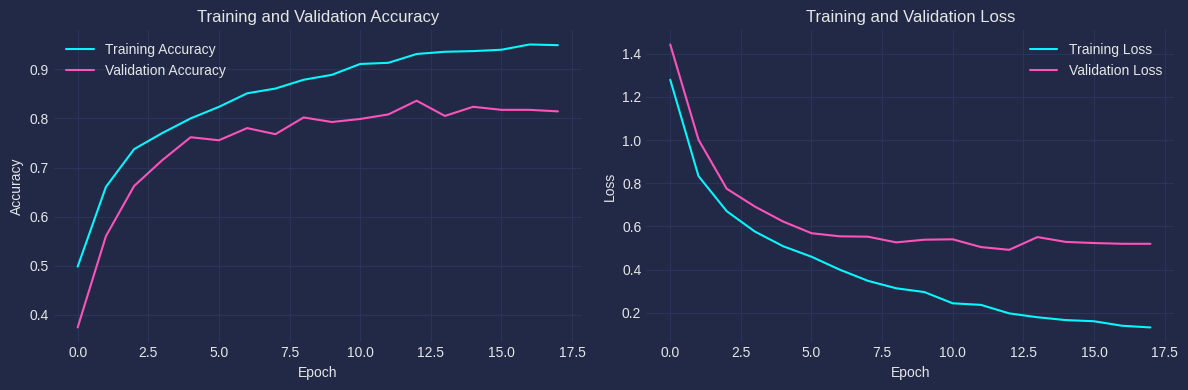

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 300ms/step
Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.81      0.73      0.77        98
        no_tumor       0.96      0.90      0.92        48
meningioma_tumor       0.73      0.77      0.75        90
 pituitary_tumor       0.91      0.99      0.95        87

        accuracy                           0.84       323
       macro avg       0.85      0.85      0.85       323
    weighted avg       0.84      0.84      0.83       323



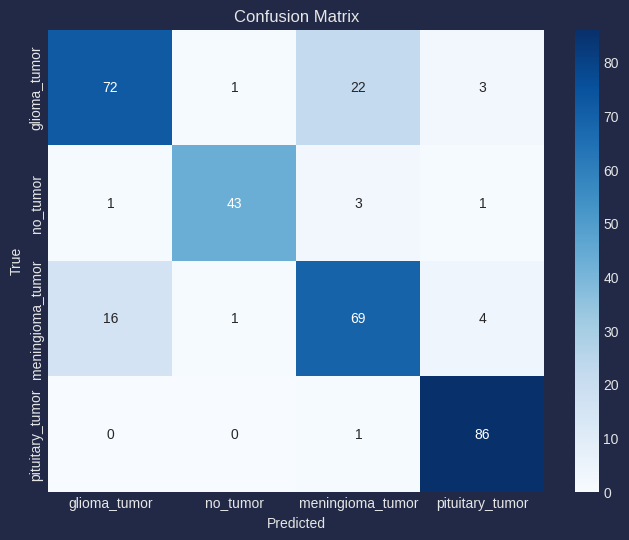

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import tensorflow.keras.applications as applications
import optuna

# Xception modelini tanımlama
def create_xception_model(input_shape=(150, 150, 3), num_classes=4, dense1_units=256, dense2_units=128, dropout1_rate=0.4, dropout2_rate=0.3):
    # Xception modelini ImageNet ağırlıkları ile yüklüyoruz
    base_model = applications.Xception(weights='imagenet', include_top=False, input_shape=input_shape)

    # İlk etapta temel modeli eğitilebilir yapmıyoruz (transfer öğrenme için)
    base_model.trainable = False

    # Modeli oluşturuyoruz
    model = Sequential([
        base_model,  # Xception temel model
        GlobalAveragePooling2D(),  # Özellikleri ortalama alarak küçült
        BatchNormalization(),  # Normalizasyon
        Dense(dense1_units, activation='relu'),  # İlk tam bağlantılı katman
        Dropout(dropout1_rate),  # İlk dropout
        Dense(dense2_units, activation='relu'),  # İkinci tam bağlantılı katman
        Dropout(dropout2_rate),  # İkinci dropout
        Dense(num_classes, activation='softmax')  # Çıkış katmanı (4 sınıf)
    ])

    return model

# Optuna objective fonksiyonu
def objective(trial):
    # Hiperparametre aralıklarını tanımlama
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    dense1_units = trial.suggest_int("dense1_units", 128, 512, step=64)
    dense2_units = trial.suggest_int("dense2_units", 64, 256, step=32)
    dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
    dropout2_rate = trial.suggest_uniform("dropout2_rate", 0.2, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # Modeli oluştur
    model = create_xception_model(
        dense1_units=dense1_units,
        dense2_units=dense2_units,
        dropout1_rate=dropout1_rate,
        dropout2_rate=dropout2_rate
    )

    # Modeli derle
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6
    )

    # Modeli eğit
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=10,  # Daha kısa süre için epoch sayısı azaltıldı
        batch_size=batch_size,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # En iyi doğrulama doğruluğunu döndür
    val_accuracy = max(history.history['val_accuracy'])

    # Belleği temizle
    tf.keras.backend.clear_session()

    return val_accuracy

# Optuna optimizasyonunu çalıştır
study = optuna.create_study(direction="maximize", study_name="xception_accuracy")
study.optimize(objective, n_trials=20)

# En iyi hiperparametreleri yazdır
print("\n=== Optimizasyon Sonuçları ===")
print("En iyi hiperparametreler: ", study.best_params)
print("En iyi validation accuracy: ", study.best_value)
print("En iyi trial numarası: ", study.best_trial.number)

# En iyi hiperparametrelerle modeli tekrar eğit
best_params = study.best_params
best_model = create_xception_model(
    dense1_units=best_params['dense1_units'],
    dense2_units=best_params['dense2_units'],
    dropout1_rate=best_params['dropout1_rate'],
    dropout2_rate=best_params['dropout2_rate']
)

# Modeli derle
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint = ModelCheckpoint(
    'best_model_optuna.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# En iyi modelle eğitimi tekrar yap
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Eğitim sonuçlarını görselleştirme
plt.figure(figsize=(12, 4))

# Accuracy grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Test seti üzerinde tahmin yapma
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Sınıflandırma raporu
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=labels))

# Karışıklık matrisi
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# **Optuna Hpo Xception(F1)**

[I 2025-04-23 14:29:01,085] A new study created in memory with name: xception_f1


GPU bulundu: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Optuna optimizasyonu başlıyor...

Trial 0 başladı:
Hiperparametreler: learning_rate=0.009716, dense1_units=384, dense2_units=192, dropout1_rate=0.43, dropout2_rate=0.34, batch_size=16


<ipython-input-18-40a13bf38980>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-18-40a13bf38980>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-18-40a13bf38980>:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout2_rate = trial.suggest_uniform("dropout2_rate", 0.2, 0.5)


Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.4017 - loss: 4.7977 - val_accuracy: 0.5077 - val_loss: 1.1089 - learning_rate: 0.0097
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4775 - loss: 1.2276 - val_accuracy: 0.5418 - val_loss: 1.0275 - learning_rate: 0.0097
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4675 - loss: 1.1972 - val_accuracy: 0.5542 - val_loss: 1.0470 - learning_rate: 0.0097
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5097 - loss: 1.1731 - val_accuracy: 0.4582 - val_loss: 1.2927 - learning_rate: 0.0097
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5031 - loss: 1.1174 - val_accuracy: 0.5820 - val_loss: 0.9173 - learning_rate: 0.0019
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5928 - loss: 0.9262 - val_accuracy: 0.6409 - val_loss: 0.8184 - learning_rate: 0.0019
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6128 - loss: 0

[I 2025-04-23 14:29:48,352] Trial 0 finished with value: 0.7009174203748293 and parameters: {'learning_rate': 0.009715518780584551, 'dense1_units': 384, 'dense2_units': 192, 'dropout1_rate': 0.4334863378097512, 'dropout2_rate': 0.34037103781011113, 'batch_size': 16}. Best is trial 0 with value: 0.7009174203748293.
<ipython-input-18-40a13bf38980>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-18-40a13bf38980>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-18-40a13bf38980>:57: FutureWarning: suggest_uniform has been depre


Trial 1 başladı:
Hiperparametreler: learning_rate=0.000019, dense1_units=128, dense2_units=256, dropout1_rate=0.32, dropout2_rate=0.21, batch_size=64
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 247ms/step - accuracy: 0.2507 - loss: 1.8209 - val_accuracy: 0.2817 - val_loss: 1.6430 - learning_rate: 1.9393e-05
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3071 - loss: 1.5903 - val_accuracy: 0.3467 - val_loss: 1.4074 - learning_rate: 1.9393e-05
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3646 - loss: 1.4482 - val_accuracy: 0.3870 - val_loss: 1.3154 - learning_rate: 1.9393e-05
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3999 - loss: 1.3504 - val_accuracy: 0.4520 - val_loss: 1.2544 - learning_rate: 1.9393e-05
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4368 - loss: 1.2799 - val_accuracy: 0.5108 - val_loss: 1.2054 - learning_rate: 1.9393e-05
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4559 - 

[I 2025-04-23 14:30:29,636] Trial 1 finished with value: 0.578778943042125 and parameters: {'learning_rate': 1.9392907011709666e-05, 'dense1_units': 128, 'dense2_units': 256, 'dropout1_rate': 0.3191322679416716, 'dropout2_rate': 0.2072223630888927, 'batch_size': 64}. Best is trial 0 with value: 0.7009174203748293.
<ipython-input-18-40a13bf38980>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-18-40a13bf38980>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-18-40a13bf38980>:57: FutureWarning: suggest_uniform has been depre


Trial 2 başladı:
Hiperparametreler: learning_rate=0.000018, dense1_units=320, dense2_units=160, dropout1_rate=0.49, dropout2_rate=0.41, batch_size=32
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - accuracy: 0.2928 - loss: 1.9106 - val_accuracy: 0.4056 - val_loss: 1.3170 - learning_rate: 1.7802e-05
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3368 - loss: 1.6639 - val_accuracy: 0.4954 - val_loss: 1.1996 - learning_rate: 1.7802e-05
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3979 - loss: 1.4965 - val_accuracy: 0.5387 - val_loss: 1.1348 - learning_rate: 1.7802e-05
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3870 - loss: 1.5207 - val_accuracy: 0.5573 - val_loss: 1.0894 - learning_rate: 1.7802e-05
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4225 - loss: 1.4361 - val_accuracy: 0.5635 - val_loss: 1.0504 - learning_rate: 1.7802e-05
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4752 - 

[I 2025-04-23 14:31:11,362] Trial 2 finished with value: 0.6248912888508696 and parameters: {'learning_rate': 1.7801955296780572e-05, 'dense1_units': 320, 'dense2_units': 160, 'dropout1_rate': 0.49201456188440174, 'dropout2_rate': 0.41447136824103137, 'batch_size': 32}. Best is trial 0 with value: 0.7009174203748293.
<ipython-input-18-40a13bf38980>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-18-40a13bf38980>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-18-40a13bf38980>:57: FutureWarning: suggest_uniform has been de


Trial 3 başladı:
Hiperparametreler: learning_rate=0.000262, dense1_units=320, dense2_units=64, dropout1_rate=0.48, dropout2_rate=0.49, batch_size=16
Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.3452 - loss: 1.6654 - val_accuracy: 0.5975 - val_loss: 0.9871 - learning_rate: 2.6200e-04
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5177 - loss: 1.1426 - val_accuracy: 0.6811 - val_loss: 0.8458 - learning_rate: 2.6200e-04
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5734 - loss: 1.0070 - val_accuracy: 0.6966 - val_loss: 0.7510 - learning_rate: 2.6200e-04
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6252 - loss: 0.9039 - val_accuracy: 0.7307 - val_loss: 0.7149 - learning_rate: 2.6200e-04
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6549 - loss: 0.8222 - val_accuracy: 0.7461 - val_loss: 0.6906 - learning_rate: 2.6200e-04
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy:

[I 2025-04-23 14:32:00,025] Trial 3 finished with value: 0.7841571687887052 and parameters: {'learning_rate': 0.0002619964528341408, 'dense1_units': 320, 'dense2_units': 64, 'dropout1_rate': 0.48196751365574214, 'dropout2_rate': 0.48917533965117804, 'batch_size': 16}. Best is trial 3 with value: 0.7841571687887052.
<ipython-input-18-40a13bf38980>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-18-40a13bf38980>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-18-40a13bf38980>:57: FutureWarning: suggest_uniform has been depr


Trial 4 başladı:
Hiperparametreler: learning_rate=0.000601, dense1_units=384, dense2_units=96, dropout1_rate=0.35, dropout2_rate=0.33, batch_size=64
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 231ms/step - accuracy: 0.4258 - loss: 1.5369 - val_accuracy: 0.4025 - val_loss: 1.3350 - learning_rate: 6.0099e-04
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6643 - loss: 0.8390 - val_accuracy: 0.6068 - val_loss: 0.9571 - learning_rate: 6.0099e-04
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7247 - loss: 0.6706 - val_accuracy: 0.6966 - val_loss: 0.8334 - learning_rate: 6.0099e-04
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7805 - loss: 0.5520 - val_accuracy: 0.7368 - val_loss: 0.6779 - learning_rate: 6.0099e-04
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8247 - loss: 0.4574 - val_accuracy: 0.7678 - val_loss: 0.6011 - learning_rate: 6.0099e-04
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8444 - l

[I 2025-04-23 14:32:40,318] Trial 4 finished with value: 0.8004008969931257 and parameters: {'learning_rate': 0.0006009894249857234, 'dense1_units': 384, 'dense2_units': 96, 'dropout1_rate': 0.3495335695847701, 'dropout2_rate': 0.32707940250406375, 'batch_size': 64}. Best is trial 4 with value: 0.8004008969931257.
<ipython-input-18-40a13bf38980>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-18-40a13bf38980>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-18-40a13bf38980>:57: FutureWarning: suggest_uniform has been depre


Trial 5 başladı:
Hiperparametreler: learning_rate=0.000085, dense1_units=512, dense2_units=128, dropout1_rate=0.26, dropout2_rate=0.42, batch_size=32
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.3535 - loss: 1.5929 - val_accuracy: 0.4923 - val_loss: 1.1350 - learning_rate: 8.5058e-05
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5442 - loss: 1.1145 - val_accuracy: 0.6440 - val_loss: 0.9136 - learning_rate: 8.5058e-05
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5880 - loss: 0.9441 - val_accuracy: 0.6966 - val_loss: 0.8345 - learning_rate: 8.5058e-05
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6657 - loss: 0.7957 - val_accuracy: 0.6749 - val_loss: 0.7514 - learning_rate: 8.5058e-05
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7061 - loss: 0.7175 - val_accuracy: 0.7214 - val_loss: 0.6927 - learning_rate: 8.5058e-05
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7510 - 

[I 2025-04-23 14:33:22,005] Trial 5 finished with value: 0.75927904757692 and parameters: {'learning_rate': 8.505836449968773e-05, 'dense1_units': 512, 'dense2_units': 128, 'dropout1_rate': 0.2635588907966543, 'dropout2_rate': 0.42424623586846866, 'batch_size': 32}. Best is trial 4 with value: 0.8004008969931257.
<ipython-input-18-40a13bf38980>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-18-40a13bf38980>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-18-40a13bf38980>:57: FutureWarning: suggest_uniform has been deprec


Trial 6 başladı:
Hiperparametreler: learning_rate=0.008140, dense1_units=448, dense2_units=224, dropout1_rate=0.43, dropout2_rate=0.42, batch_size=32
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - accuracy: 0.4153 - loss: 3.6958 - val_accuracy: 0.3808 - val_loss: 1.2815 - learning_rate: 0.0081
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4917 - loss: 1.1540 - val_accuracy: 0.5759 - val_loss: 0.9972 - learning_rate: 0.0081
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5401 - loss: 1.0684 - val_accuracy: 0.5975 - val_loss: 1.0059 - learning_rate: 0.0081
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5423 - loss: 1.0584 - val_accuracy: 0.5542 - val_loss: 0.9223 - learning_rate: 0.0081
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5548 - loss: 1.0038 - val_accuracy: 0.5913 - val_loss: 0.8945 - learning_rate: 0.0081
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5278 - loss: 1.0710 - val_a

[I 2025-04-23 14:34:03,590] Trial 6 finished with value: 0.7045682083224223 and parameters: {'learning_rate': 0.008139698254957545, 'dense1_units': 448, 'dense2_units': 224, 'dropout1_rate': 0.4295551780111576, 'dropout2_rate': 0.41881193043270465, 'batch_size': 32}. Best is trial 4 with value: 0.8004008969931257.
<ipython-input-18-40a13bf38980>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-18-40a13bf38980>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-18-40a13bf38980>:57: FutureWarning: suggest_uniform has been depre


Trial 7 başladı:
Hiperparametreler: learning_rate=0.000012, dense1_units=384, dense2_units=160, dropout1_rate=0.33, dropout2_rate=0.46, batch_size=32
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.2560 - loss: 1.9698 - val_accuracy: 0.3467 - val_loss: 1.4419 - learning_rate: 1.2040e-05
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3183 - loss: 1.6868 - val_accuracy: 0.4087 - val_loss: 1.2973 - learning_rate: 1.2040e-05
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3251 - loss: 1.6079 - val_accuracy: 0.4768 - val_loss: 1.2229 - learning_rate: 1.2040e-05
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3687 - loss: 1.5060 - val_accuracy: 0.4954 - val_loss: 1.1660 - learning_rate: 1.2040e-05
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3698 - loss: 1.4366 - val_accuracy: 0.5170 - val_loss: 1.1235 - learning_rate: 1.2040e-05
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4364 - 

[I 2025-04-23 14:34:47,542] Trial 7 finished with value: 0.5537050620161211 and parameters: {'learning_rate': 1.2039946029461909e-05, 'dense1_units': 384, 'dense2_units': 160, 'dropout1_rate': 0.32897204953930026, 'dropout2_rate': 0.46196360987092655, 'batch_size': 32}. Best is trial 4 with value: 0.8004008969931257.
<ipython-input-18-40a13bf38980>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-18-40a13bf38980>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-18-40a13bf38980>:57: FutureWarning: suggest_uniform has been de


Trial 8 başladı:
Hiperparametreler: learning_rate=0.004234, dense1_units=128, dense2_units=192, dropout1_rate=0.24, dropout2_rate=0.24, batch_size=64
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 225ms/step - accuracy: 0.4629 - loss: 1.5993 - val_accuracy: 0.4520 - val_loss: 1.3768 - learning_rate: 0.0042
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6877 - loss: 0.7955 - val_accuracy: 0.5418 - val_loss: 1.0767 - learning_rate: 0.0042
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7691 - loss: 0.5812 - val_accuracy: 0.6656 - val_loss: 0.7572 - learning_rate: 0.0042
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8132 - loss: 0.4638 - val_accuracy: 0.7214 - val_loss: 0.6635 - learning_rate: 0.0042
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8380 - loss: 0.4164 - val_accuracy: 0.7307 - val_loss: 0.6404 - learning_rate: 0.0042
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8618 - loss: 0.3533 - val_a

[I 2025-04-23 14:35:26,233] Trial 8 finished with value: 0.8520173380165463 and parameters: {'learning_rate': 0.0042339443602326015, 'dense1_units': 128, 'dense2_units': 192, 'dropout1_rate': 0.24490399132699298, 'dropout2_rate': 0.2413597034485243, 'batch_size': 64}. Best is trial 8 with value: 0.8520173380165463.
<ipython-input-18-40a13bf38980>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-18-40a13bf38980>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-18-40a13bf38980>:57: FutureWarning: suggest_uniform has been depr


Trial 9 başladı:
Hiperparametreler: learning_rate=0.000459, dense1_units=256, dense2_units=192, dropout1_rate=0.26, dropout2_rate=0.29, batch_size=32
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.4487 - loss: 1.3104 - val_accuracy: 0.6563 - val_loss: 0.9247 - learning_rate: 4.5918e-04
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6854 - loss: 0.7616 - val_accuracy: 0.7059 - val_loss: 0.6973 - learning_rate: 4.5918e-04
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7556 - loss: 0.6129 - val_accuracy: 0.7461 - val_loss: 0.6400 - learning_rate: 4.5918e-04
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8102 - loss: 0.4971 - val_accuracy: 0.7926 - val_loss: 0.6015 - learning_rate: 4.5918e-04
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8319 - loss: 0.4160 - val_accuracy: 0.7678 - val_loss: 0.6514 - learning_rate: 4.5918e-04
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8588 - 

[I 2025-04-23 14:36:08,919] Trial 9 finished with value: 0.8113572238389924 and parameters: {'learning_rate': 0.0004591765897012735, 'dense1_units': 256, 'dense2_units': 192, 'dropout1_rate': 0.2580723131582095, 'dropout2_rate': 0.2896774062180825, 'batch_size': 32}. Best is trial 8 with value: 0.8520173380165463.
<ipython-input-18-40a13bf38980>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-18-40a13bf38980>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-18-40a13bf38980>:57: FutureWarning: suggest_uniform has been depre


Trial 10 başladı:
Hiperparametreler: learning_rate=0.002426, dense1_units=128, dense2_units=256, dropout1_rate=0.22, dropout2_rate=0.20, batch_size=64
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 196ms/step - accuracy: 0.4613 - loss: 1.3037 - val_accuracy: 0.3746 - val_loss: 1.9389 - learning_rate: 0.0024
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7475 - loss: 0.6798 - val_accuracy: 0.5170 - val_loss: 1.1789 - learning_rate: 0.0024
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7852 - loss: 0.5370 - val_accuracy: 0.6842 - val_loss: 0.7895 - learning_rate: 0.0024
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8442 - loss: 0.4020 - val_accuracy: 0.7461 - val_loss: 0.6419 - learning_rate: 0.0024
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8625 - loss: 0.3404 - val_accuracy: 0.7337 - val_loss: 0.7301 - learning_rate: 0.0024
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8853 - loss: 0.3056 - val_

[I 2025-04-23 14:36:45,121] Trial 10 finished with value: 0.8228947314173228 and parameters: {'learning_rate': 0.0024255120519841686, 'dense1_units': 128, 'dense2_units': 256, 'dropout1_rate': 0.21989963099688614, 'dropout2_rate': 0.20060139016828718, 'batch_size': 64}. Best is trial 8 with value: 0.8520173380165463.
<ipython-input-18-40a13bf38980>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-18-40a13bf38980>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-18-40a13bf38980>:57: FutureWarning: suggest_uniform has been de


Trial 11 başladı:
Hiperparametreler: learning_rate=0.002617, dense1_units=128, dense2_units=256, dropout1_rate=0.20, dropout2_rate=0.21, batch_size=64
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 191ms/step - accuracy: 0.5224 - loss: 1.2747 - val_accuracy: 0.2848 - val_loss: 2.0484 - learning_rate: 0.0026
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7188 - loss: 0.7240 - val_accuracy: 0.5077 - val_loss: 1.1926 - learning_rate: 0.0026
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7995 - loss: 0.5196 - val_accuracy: 0.6718 - val_loss: 0.7438 - learning_rate: 0.0026
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8402 - loss: 0.4006 - val_accuracy: 0.7183 - val_loss: 0.6907 - learning_rate: 0.0026
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8834 - loss: 0.3011 - val_accuracy: 0.7740 - val_loss: 0.6319 - learning_rate: 0.0026
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8947 - loss: 0.2944 - val_

[I 2025-04-23 14:37:21,835] Trial 11 finished with value: 0.8529568250507095 and parameters: {'learning_rate': 0.0026172622739077662, 'dense1_units': 128, 'dense2_units': 256, 'dropout1_rate': 0.20086713510597126, 'dropout2_rate': 0.20630713915235976, 'batch_size': 64}. Best is trial 11 with value: 0.8529568250507095.
<ipython-input-18-40a13bf38980>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-18-40a13bf38980>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-18-40a13bf38980>:57: FutureWarning: suggest_uniform has been d


Trial 12 başladı:
Hiperparametreler: learning_rate=0.002025, dense1_units=192, dense2_units=224, dropout1_rate=0.20, dropout2_rate=0.26, batch_size=64
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 273ms/step - accuracy: 0.4922 - loss: 1.3128 - val_accuracy: 0.2229 - val_loss: 2.4389 - learning_rate: 0.0020
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7137 - loss: 0.7160 - val_accuracy: 0.5418 - val_loss: 1.1532 - learning_rate: 0.0020
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8100 - loss: 0.5249 - val_accuracy: 0.6687 - val_loss: 0.7325 - learning_rate: 0.0020
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8503 - loss: 0.3959 - val_accuracy: 0.6873 - val_loss: 0.7538 - learning_rate: 0.0020
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8719 - loss: 0.3330 - val_accuracy: 0.7430 - val_loss: 0.6466 - learning_rate: 0.0020
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8987 - loss: 0.2693 - val_

[I 2025-04-23 14:38:04,785] Trial 12 finished with value: 0.8440968342981037 and parameters: {'learning_rate': 0.0020249696775890592, 'dense1_units': 192, 'dense2_units': 224, 'dropout1_rate': 0.20417926728074315, 'dropout2_rate': 0.2594095015385808, 'batch_size': 64}. Best is trial 11 with value: 0.8529568250507095.
<ipython-input-18-40a13bf38980>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-18-40a13bf38980>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-18-40a13bf38980>:57: FutureWarning: suggest_uniform has been de


Trial 13 başladı:
Hiperparametreler: learning_rate=0.002175, dense1_units=192, dense2_units=224, dropout1_rate=0.27, dropout2_rate=0.25, batch_size=64
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 203ms/step - accuracy: 0.4799 - loss: 1.3741 - val_accuracy: 0.4056 - val_loss: 1.6522 - learning_rate: 0.0022
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7029 - loss: 0.7411 - val_accuracy: 0.5232 - val_loss: 1.0288 - learning_rate: 0.0022
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7877 - loss: 0.5344 - val_accuracy: 0.7121 - val_loss: 0.6724 - learning_rate: 0.0022
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8196 - loss: 0.4430 - val_accuracy: 0.7678 - val_loss: 0.6044 - learning_rate: 0.0022
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8617 - loss: 0.3534 - val_accuracy: 0.7492 - val_loss: 0.6182 - learning_rate: 0.0022
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8840 - loss: 0.3067 - val_

[I 2025-04-23 14:38:42,665] Trial 13 finished with value: 0.8356789934056086 and parameters: {'learning_rate': 0.002175107686176447, 'dense1_units': 192, 'dense2_units': 224, 'dropout1_rate': 0.2698184679774836, 'dropout2_rate': 0.25288725439864984, 'batch_size': 64}. Best is trial 11 with value: 0.8529568250507095.
<ipython-input-18-40a13bf38980>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-18-40a13bf38980>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-18-40a13bf38980>:57: FutureWarning: suggest_uniform has been dep


Trial 14 başladı:
Hiperparametreler: learning_rate=0.001243, dense1_units=192, dense2_units=192, dropout1_rate=0.20, dropout2_rate=0.26, batch_size=64
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 234ms/step - accuracy: 0.4809 - loss: 1.2850 - val_accuracy: 0.4551 - val_loss: 1.3140 - learning_rate: 0.0012
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7299 - loss: 0.6748 - val_accuracy: 0.5728 - val_loss: 1.0495 - learning_rate: 0.0012
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8024 - loss: 0.5170 - val_accuracy: 0.6718 - val_loss: 0.8687 - learning_rate: 0.0012
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8581 - loss: 0.3735 - val_accuracy: 0.7492 - val_loss: 0.6796 - learning_rate: 0.0012
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8888 - loss: 0.2821 - val_accuracy: 0.7926 - val_loss: 0.6163 - learning_rate: 0.0012
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9079 - loss: 0.2490 - val_

[I 2025-04-23 14:39:22,097] Trial 14 finished with value: 0.8415458940536851 and parameters: {'learning_rate': 0.001243390470490747, 'dense1_units': 192, 'dense2_units': 192, 'dropout1_rate': 0.20010768779483676, 'dropout2_rate': 0.25535877387775635, 'batch_size': 64}. Best is trial 11 with value: 0.8529568250507095.
<ipython-input-18-40a13bf38980>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-18-40a13bf38980>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-18-40a13bf38980>:57: FutureWarning: suggest_uniform has been de


Trial 15 başladı:
Hiperparametreler: learning_rate=0.004444, dense1_units=128, dense2_units=256, dropout1_rate=0.29, dropout2_rate=0.30, batch_size=64
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 195ms/step - accuracy: 0.4620 - loss: 1.6151 - val_accuracy: 0.3777 - val_loss: 1.6525 - learning_rate: 0.0044
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6801 - loss: 0.8042 - val_accuracy: 0.6037 - val_loss: 0.8727 - learning_rate: 0.0044
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7556 - loss: 0.6226 - val_accuracy: 0.6687 - val_loss: 0.7471 - learning_rate: 0.0044
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8109 - loss: 0.4894 - val_accuracy: 0.7585 - val_loss: 0.5741 - learning_rate: 0.0044
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8344 - loss: 0.4292 - val_accuracy: 0.7554 - val_loss: 0.5772 - learning_rate: 0.0044
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8519 - loss: 0.3884 - val_

[I 2025-04-23 14:39:59,543] Trial 15 finished with value: 0.8467201954867989 and parameters: {'learning_rate': 0.004443990361620618, 'dense1_units': 128, 'dense2_units': 256, 'dropout1_rate': 0.29340248536852537, 'dropout2_rate': 0.29932462114065483, 'batch_size': 64}. Best is trial 11 with value: 0.8529568250507095.
<ipython-input-18-40a13bf38980>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-18-40a13bf38980>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-18-40a13bf38980>:57: FutureWarning: suggest_uniform has been de


Trial 16 başladı:
Hiperparametreler: learning_rate=0.000848, dense1_units=256, dense2_units=128, dropout1_rate=0.24, dropout2_rate=0.23, batch_size=16
Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.4738 - loss: 1.3316 - val_accuracy: 0.6347 - val_loss: 0.9323 - learning_rate: 8.4806e-04
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6877 - loss: 0.7821 - val_accuracy: 0.7307 - val_loss: 0.6887 - learning_rate: 8.4806e-04
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7555 - loss: 0.6158 - val_accuracy: 0.7399 - val_loss: 0.6571 - learning_rate: 8.4806e-04
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7838 - loss: 0.5083 - val_accuracy: 0.7709 - val_loss: 0.6199 - learning_rate: 8.4806e-04
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8287 - loss: 0.4300 - val_accuracy: 0.7709 - val_loss: 0.6207 - learning_rate: 8.4806e-04
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accurac

[I 2025-04-23 14:40:48,313] Trial 16 finished with value: 0.8200979764040358 and parameters: {'learning_rate': 0.0008480611888843167, 'dense1_units': 256, 'dense2_units': 128, 'dropout1_rate': 0.23731412110125782, 'dropout2_rate': 0.22962766624359612, 'batch_size': 16}. Best is trial 11 with value: 0.8529568250507095.
<ipython-input-18-40a13bf38980>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-18-40a13bf38980>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-18-40a13bf38980>:57: FutureWarning: suggest_uniform has been d


Trial 17 başladı:
Hiperparametreler: learning_rate=0.004697, dense1_units=256, dense2_units=224, dropout1_rate=0.41, dropout2_rate=0.36, batch_size=64
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 248ms/step - accuracy: 0.4492 - loss: 2.0282 - val_accuracy: 0.4180 - val_loss: 1.2294 - learning_rate: 0.0047
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6326 - loss: 0.9438 - val_accuracy: 0.5356 - val_loss: 0.9555 - learning_rate: 0.0047
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6995 - loss: 0.7360 - val_accuracy: 0.6099 - val_loss: 0.8942 - learning_rate: 0.0047
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7472 - loss: 0.6343 - val_accuracy: 0.6842 - val_loss: 0.6964 - learning_rate: 0.0047
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7642 - loss: 0.5857 - val_accuracy: 0.7554 - val_loss: 0.6256 - learning_rate: 0.0047
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8097 - loss: 0.4970 - val_

[I 2025-04-23 14:41:29,599] Trial 17 finished with value: 0.8353541976279978 and parameters: {'learning_rate': 0.004697412499349542, 'dense1_units': 256, 'dense2_units': 224, 'dropout1_rate': 0.4060468712045251, 'dropout2_rate': 0.36470487153099107, 'batch_size': 64}. Best is trial 11 with value: 0.8529568250507095.
<ipython-input-18-40a13bf38980>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-18-40a13bf38980>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-18-40a13bf38980>:57: FutureWarning: suggest_uniform has been dep


Trial 18 başladı:
Hiperparametreler: learning_rate=0.000193, dense1_units=128, dense2_units=192, dropout1_rate=0.38, dropout2_rate=0.29, batch_size=64
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 196ms/step - accuracy: 0.3598 - loss: 1.4684 - val_accuracy: 0.3622 - val_loss: 1.2688 - learning_rate: 1.9312e-04
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5305 - loss: 1.1071 - val_accuracy: 0.5480 - val_loss: 1.0353 - learning_rate: 1.9312e-04
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5915 - loss: 0.9553 - val_accuracy: 0.6563 - val_loss: 0.8878 - learning_rate: 1.9312e-04
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6658 - loss: 0.8357 - val_accuracy: 0.7183 - val_loss: 0.7891 - learning_rate: 1.9312e-04
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6945 - loss: 0.7673 - val_accuracy: 0.7307 - val_loss: 0.7313 - learning_rate: 1.9312e-04
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7359 -

[I 2025-04-23 14:42:07,284] Trial 18 finished with value: 0.7907722732143255 and parameters: {'learning_rate': 0.00019311858255032955, 'dense1_units': 128, 'dense2_units': 192, 'dropout1_rate': 0.3791202981184892, 'dropout2_rate': 0.2905829875443863, 'batch_size': 64}. Best is trial 11 with value: 0.8529568250507095.
<ipython-input-18-40a13bf38980>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-18-40a13bf38980>:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
<ipython-input-18-40a13bf38980>:57: FutureWarning: suggest_uniform has been de


Trial 19 başladı:
Hiperparametreler: learning_rate=0.000087, dense1_units=192, dense2_units=128, dropout1_rate=0.29, dropout2_rate=0.22, batch_size=64
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - accuracy: 0.2981 - loss: 1.6244 - val_accuracy: 0.4489 - val_loss: 1.2220 - learning_rate: 8.7453e-05
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4693 - loss: 1.2344 - val_accuracy: 0.5387 - val_loss: 1.0709 - learning_rate: 8.7453e-05
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5724 - loss: 1.0609 - val_accuracy: 0.6099 - val_loss: 0.9589 - learning_rate: 8.7453e-05
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5946 - loss: 0.9692 - val_accuracy: 0.6625 - val_loss: 0.8749 - learning_rate: 8.7453e-05
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6302 - loss: 0.8987 - val_accuracy: 0.6873 - val_loss: 0.8160 - learning_rate: 8.7453e-05
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6798 -

[I 2025-04-23 14:42:48,744] Trial 19 finished with value: 0.7237205077268279 and parameters: {'learning_rate': 8.745298010396846e-05, 'dense1_units': 192, 'dense2_units': 128, 'dropout1_rate': 0.2923616228532732, 'dropout2_rate': 0.22264944743128676, 'batch_size': 64}. Best is trial 11 with value: 0.8529568250507095.



=== Optimizasyon Sonuçları ===
En iyi hiperparametreler:  {'learning_rate': 0.0026172622739077662, 'dense1_units': 128, 'dense2_units': 256, 'dropout1_rate': 0.20086713510597126, 'dropout2_rate': 0.20630713915235976, 'batch_size': 64}
En iyi F1 skoru:  0.8529568250507095
En iyi trial numarası:  11
Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.4862 - loss: 1.2875

46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 187ms/step - accuracy: 0.4877 - loss: 1.2843 - val_accuracy: 0.5170 - val_loss: 1.2966 - learning_rate: 0.0026
Epoch 2/20
44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7252 - loss: 0.7176

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7264 - loss: 0.7144 - val_accuracy: 0.5232 - val_loss: 1.1109 - learning_rate: 0.0026
Epoch 3/20
43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8070 - loss: 0.4963

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8066 - loss: 0.4964 - val_accuracy: 0.7121 - val_loss: 0.6732 - learning_rate: 0.0026
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8648 - loss: 0.3652 - val_accuracy: 0.6873 - val_loss: 0.7802 - learning_rate: 0.0026
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8668 - loss: 0.3381

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8668 - loss: 0.3383 - val_accuracy: 0.7771 - val_loss: 0.6345 - learning_rate: 0.0026
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8876 - loss: 0.2842 - val_accuracy: 0.7771 - val_loss: 0.6723 - learning_rate: 0.0026
Epoch 7/20
44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8986 - loss: 0.2673

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8984 - loss: 0.2672 - val_accuracy: 0.7864 - val_loss: 0.6104 - learning_rate: 0.0026
Epoch 8/20
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9093 - loss: 0.2256

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9093 - loss: 0.2256 - val_accuracy: 0.8173 - val_loss: 0.5960 - learning_rate: 0.0026
Epoch 9/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9247 - loss: 0.2199 - val_accuracy: 0.7988 - val_loss: 0.6209 - learning_rate: 0.0026
Epoch 10/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9360 - loss: 0.1773 - val_accuracy: 0.7833 - val_loss: 0.6177 - learning_rate: 0.0026
Epoch 11/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9500 - loss: 0.1370 - val_accuracy: 0.7988 - val_loss: 0.6945 - learning_rate: 0.0026
Epoch 12/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9529 - loss: 0.1243 - val_accuracy: 0.8142 - val_loss: 0.6618 - learning_rate: 5.2345e-04
Epoch 13/20
44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9819 - loss: 0.0615

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9816 - loss: 0.0619 - val_accuracy: 0.8266 - val_loss: 0.6904 - learning_rate: 5.2345e-04


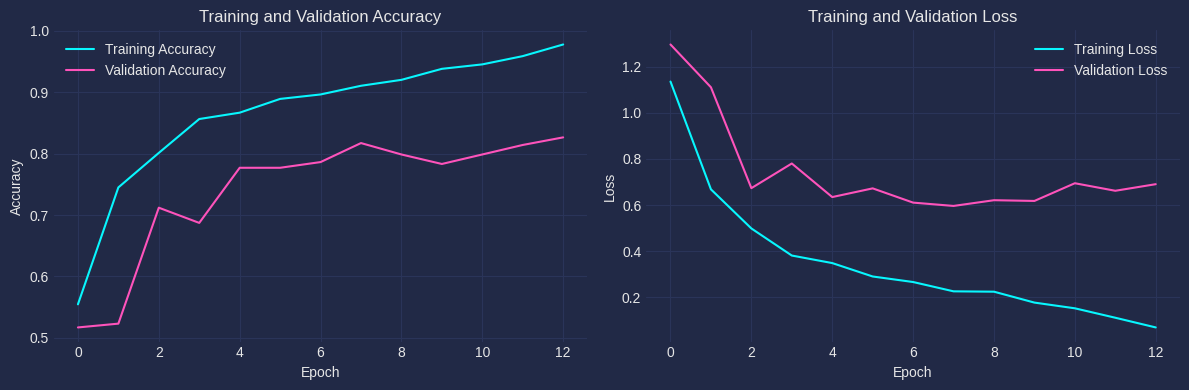

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 263ms/step
Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.79      0.69      0.74        98
        no_tumor       0.93      0.88      0.90        48
meningioma_tumor       0.75      0.74      0.75        90
 pituitary_tumor       0.84      1.00      0.92        87

        accuracy                           0.82       323
       macro avg       0.83      0.83      0.83       323
    weighted avg       0.82      0.82      0.81       323



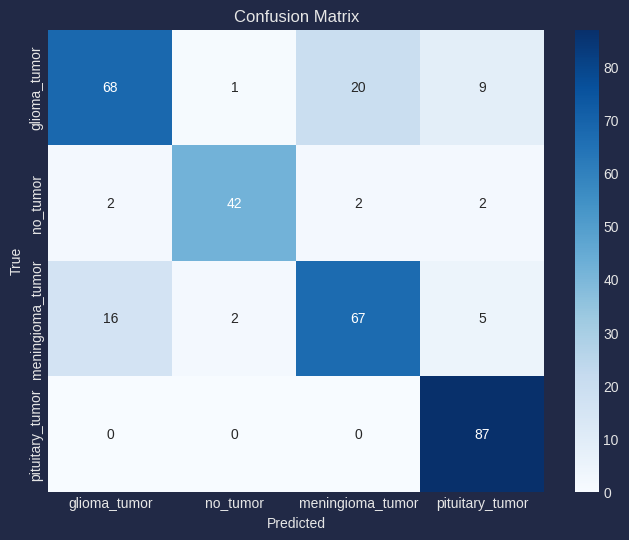

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tqdm import tqdm
import tensorflow.keras.applications as applications
import optuna

# GPU yapılandırmasını kontrol et
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print(f"GPU bulundu: {physical_devices}")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)  # Bellek büyümesini etkinleştir
else:
    print("GPU bulunamadı, CPU kullanılacak.")

# Xception modelini tanımlama
def create_xception_model(input_shape=(150, 150, 3), num_classes=4, dense1_units=256, dense2_units=128, dropout1_rate=0.4, dropout2_rate=0.3):
    # Xception modelini ImageNet ağırlıkları ile yüklüyoruz
    base_model = applications.Xception(weights='imagenet', include_top=False, input_shape=input_shape)

    # İlk etapta temel modeli eğitilebilir yapmıyoruz (transfer öğrenme için)
    base_model.trainable = False

    # Modeli oluşturuyoruz
    model = Sequential([
        base_model,  # Xception temel model
        GlobalAveragePooling2D(),  # Özellikleri ortalama alarak küçült
        BatchNormalization(),  # Normalizasyon
        Dense(dense1_units, activation='relu'),  # İlk tam bağlantılı katman
        Dropout(dropout1_rate),  # İlk dropout
        Dense(dense2_units, activation='relu'),  # İkinci tam bağlantılı katman
        Dropout(dropout2_rate),  # İkinci dropout
        Dense(num_classes, activation='softmax')  # Çıkış katmanı (4 sınıf)
    ])

    return model

# Optuna objective fonksiyonu
def objective(trial):
    # Hiperparametre aralıklarını tanımlama
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    dense1_units = trial.suggest_int("dense1_units", 128, 512, step=64)
    dense2_units = trial.suggest_int("dense2_units", 64, 256, step=32)
    dropout1_rate = trial.suggest_uniform("dropout1_rate", 0.2, 0.5)
    dropout2_rate = trial.suggest_uniform("dropout2_rate", 0.2, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    print(f"\nTrial {trial.number} başladı:")
    print(f"Hiperparametreler: learning_rate={learning_rate:.6f}, dense1_units={dense1_units}, "
          f"dense2_units={dense2_units}, dropout1_rate={dropout1_rate:.2f}, dropout2_rate={dropout2_rate:.2f}, "
          f"batch_size={batch_size}")

    try:
        # Modeli oluştur
        model = create_xception_model(
            dense1_units=dense1_units,
            dense2_units=dense2_units,
            dropout1_rate=dropout1_rate,
            dropout2_rate=dropout2_rate
        )

        # Modeli derle
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2,
            min_lr=1e-6
        )

        # Modeli eğit
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=10,  # Daha kısa süre için epoch sayısı
            batch_size=batch_size,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        # Test seti üzerinde tahmin yapma
        y_pred = model.predict(X_test, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test, axis=1)

        # F1 skorunu hesapla (macro)
        f1 = f1_score(y_true_classes, y_pred_classes, average='macro')
        print(f"F1 Skoru (macro): {f1:.4f}")

        # Belleği temizle
        tf.keras.backend.clear_session()

        return f1

    except Exception as e:
        print(f"Trial {trial.number} hata ile sonuçlandı: {e}")
        raise

# Optuna optimizasyonunu çalıştır
print("Optuna optimizasyonu başlıyor...")
study = optuna.create_study(direction="maximize", study_name="xception_f1")
try:
    study.optimize(objective, n_trials=20)  # 20 deneme
except KeyboardInterrupt:
    print("Optimizasyon kullanıcı tarafından durduruldu.")

# En iyi hiperparametreleri yazdır
print("\n=== Optimizasyon Sonuçları ===")
print("En iyi hiperparametreler: ", study.best_params)
print("En iyi F1 skoru: ", study.best_value)
print("En iyi trial numarası: ", study.best_trial.number)

# En iyi hiperparametrelerle modeli tekrar eğit
best_params = study.best_params
best_model = create_xception_model(
    dense1_units=best_params['dense1_units'],
    dense2_units=best_params['dense2_units'],
    dropout1_rate=best_params['dropout1_rate'],
    dropout2_rate=best_params['dropout2_rate']
)

# Modeli derle
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint = ModelCheckpoint(
    'best_model_xception_f1.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# En iyi modelle eğitimi tekrar yap
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Eğitim sonuçlarını görselleştirme
plt.figure(figsize=(12, 4))

# Accuracy grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Test seti üzerinde tahmin yapma
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Sınıflandırma raporu
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=labels))

# Karışıklık matrisi
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# **Fixed VGG16**


Mounted at /content/drive
Klasör mevcut!


100%|██████████| 74/74 [01:09<00:00,  1.06it/s]
[I 2025-05-08 17:59:02,507] A new study created in memory with name: no-name-ebfda738-797a-40a6-889a-66ea218b0206


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


[I 2025-05-08 18:09:02,047] Trial 0 finished with value: 0.918749988079071 and parameters: {'learning_rate': 0.0003985970591954192, 'dropout_rate': 0.5323855470003616, 'batch_size': 32, 'alpha': 0.2368363668805032, 'gamma': 2.012529449461622}. Best is trial 0 with value: 0.918749988079071.
[I 2025-05-08 18:28:41,236] Trial 1 finished with value: 0.6783625483512878 and parameters: {'learning_rate': 6.6331348194475e-06, 'dropout_rate': 0.46080576301503196, 'batch_size': 16, 'alpha': 0.1014070106040752, 'gamma': 2.7524585649546283}. Best is trial 0 with value: 0.918749988079071.
[I 2025-05-08 18:38:25,155] Trial 2 finished with value: 0.9156249761581421 and parameters: {'learning_rate': 0.00024071061388034366, 'dropout_rate': 0.4985251232217428, 'batch_size': 32, 'alpha': 0.25115533629306896, 'gamma': 2.7750288836999877}. Best is trial 0 with value: 0.918749988079071.
[I 2025-05-08 18:48:13,449] Trial 3 finished with value: 0.512499988079071 and parameters: {'learning_rate': 1.95082230529

En iyi hiperparametreler: {'learning_rate': 0.0003985970591954192, 'dropout_rate': 0.5323855470003616, 'batch_size': 32, 'alpha': 0.2368363668805032, 'gamma': 2.012529449461622}
Epoch 1/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.6465 - loss: 3.9575

130/130 ━━━━━━━━━━━━━━━━━━━━ 38s 255ms/step - accuracy: 0.6470 - loss: 3.9498 - val_accuracy: 0.4500 - val_loss: 1.3490 - learning_rate: 3.9860e-04
Epoch 2/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8467 - loss: 0.9579

130/130 ━━━━━━━━━━━━━━━━━━━━ 29s 225ms/step - accuracy: 0.8468 - loss: 0.9558 - val_accuracy: 0.5625 - val_loss: 0.2926 - learning_rate: 3.9860e-04
Epoch 3/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.8872 - loss: 0.1991

130/130 ━━━━━━━━━━━━━━━━━━━━ 29s 227ms/step - accuracy: 0.8873 - loss: 0.1987 - val_accuracy: 0.6031 - val_loss: 0.0851 - learning_rate: 3.9860e-04
Epoch 4/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9255 - loss: 0.0481

130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 229ms/step - accuracy: 0.9255 - loss: 0.0480 - val_accuracy: 0.7312 - val_loss: 0.0346 - learning_rate: 3.9860e-04
Epoch 5/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9430 - loss: 0.0206

130/130 ━━━━━━━━━━━━━━━━━━━━ 29s 228ms/step - accuracy: 0.9430 - loss: 0.0205 - val_accuracy: 0.7594 - val_loss: 0.0263 - learning_rate: 3.9860e-04
Epoch 6/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 29s 225ms/step - accuracy: 0.9370 - loss: 0.0154 - val_accuracy: 0.7000 - val_loss: 0.0297 - learning_rate: 3.9860e-04
Epoch 7/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9589 - loss: 0.0125

130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 232ms/step - accuracy: 0.9588 - loss: 0.0125 - val_accuracy: 0.7688 - val_loss: 0.0241 - learning_rate: 3.9860e-04
Epoch 8/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9552 - loss: 0.0122

130/130 ━━━━━━━━━━━━━━━━━━━━ 29s 228ms/step - accuracy: 0.9552 - loss: 0.0122 - val_accuracy: 0.8344 - val_loss: 0.0213 - learning_rate: 3.9860e-04
Epoch 9/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 29s 224ms/step - accuracy: 0.9650 - loss: 0.0104 - val_accuracy: 0.7250 - val_loss: 0.0311 - learning_rate: 3.9860e-04
Epoch 10/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 29s 227ms/step - accuracy: 0.9583 - loss: 0.0103 - val_accuracy: 0.7750 - val_loss: 0.0229 - learning_rate: 3.9860e-04
Epoch 11/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 29s 228ms/step - accuracy: 0.9610 - loss: 0.0096 - val_accuracy: 0.8125 - val_loss: 0.0248 - learning_rate: 3.9860e-04
Epoch 12/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 229ms/step - accuracy: 0.9704 - loss: 0.0092 - val_accuracy: 0.8344 - val_loss: 0.0185 - learning_rate: 7.9719e-05
Epoch 13/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 29s 227ms/step - accuracy: 0.9808 - loss: 0.0073 - val_accuracy: 0.8125 - val_loss: 0.0215 - learning_rate: 7.9719e-05
Epoch 14/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/ste

130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 230ms/step - accuracy: 0.9877 - loss: 0.0068 - val_accuracy: 0.8531 - val_loss: 0.0182 - learning_rate: 7.9719e-05
Epoch 15/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 29s 228ms/step - accuracy: 0.9815 - loss: 0.0069 - val_accuracy: 0.8531 - val_loss: 0.0182 - learning_rate: 7.9719e-05
Epoch 16/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9870 - loss: 0.0067

130/130 ━━━━━━━━━━━━━━━━━━━━ 29s 226ms/step - accuracy: 0.9870 - loss: 0.0067 - val_accuracy: 0.8594 - val_loss: 0.0159 - learning_rate: 7.9719e-05
Epoch 17/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 29s 226ms/step - accuracy: 0.9905 - loss: 0.0064 - val_accuracy: 0.8406 - val_loss: 0.0170 - learning_rate: 7.9719e-05
Epoch 18/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9888 - loss: 0.0063

130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 231ms/step - accuracy: 0.9888 - loss: 0.0063 - val_accuracy: 0.8813 - val_loss: 0.0145 - learning_rate: 7.9719e-05
Epoch 19/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 29s 224ms/step - accuracy: 0.9900 - loss: 0.0063 - val_accuracy: 0.8719 - val_loss: 0.0154 - learning_rate: 7.9719e-05
Epoch 20/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 29s 227ms/step - accuracy: 0.9889 - loss: 0.0060 - val_accuracy: 0.8594 - val_loss: 0.0156 - learning_rate: 7.9719e-05
Epoch 21/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 29s 228ms/step - accuracy: 0.9885 - loss: 0.0059 - val_accuracy: 0.8781 - val_loss: 0.0144 - learning_rate: 7.9719e-05
Epoch 22/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 29s 227ms/step - accuracy: 0.9900 - loss: 0.0057 - val_accuracy: 0.8719 - val_loss: 0.0158 - learning_rate: 7.9719e-05
Epoch 23/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 29s 227ms/step - accuracy: 0.9910 - loss: 0.0058 - val_accuracy: 0.8813 - val_loss: 0.0147 - learning_rate: 7.9719e-05
Epoch 24/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 29s 226ms/s

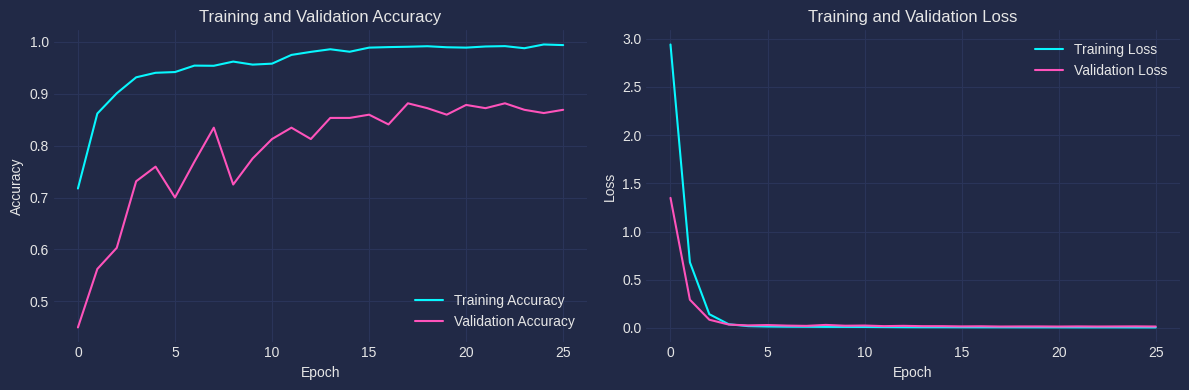

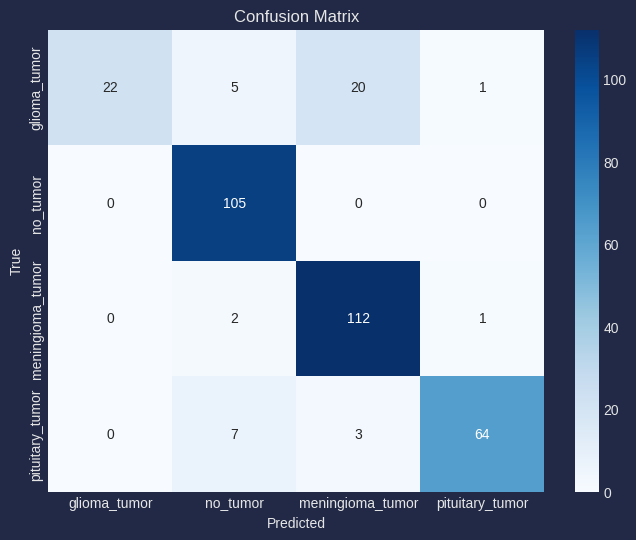

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import optuna
from sklearn.utils.class_weight import compute_class_weight
from warnings import filterwarnings
filterwarnings('ignore')

# Custom Focal Loss Implementation
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * y_true * tf.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_mean(loss, axis=-1)
    return focal_loss_fixed

# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')

# Check Dataset Directory
directory_path = '/content/drive/My Drive/DataSets'
if os.path.exists(directory_path):
    print("Klasör mevcut!")
else:
    print("Klasör mevcut değil.")
    exit()

# Data Loading
X_train = []
y_train = []
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']
image_size = 150

for i in labels:
    folderPath = os.path.join('/content/drive/My Drive/DataSets/Training', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        y_train.append(i)

X_test = []
y_test = []
for i in labels:
    folderPath = os.path.join('/content/drive/My Drive/DataSets/Testing', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (image_size, image_size))
        X_test.append(img)
        y_test.append(i)

# Convert to NumPy Arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Shuffle Training Data
X_train, y_train = shuffle(X_train, y_train, random_state=101)

# Oversampling for all classes based on imbalance
y_train_new = [labels.index(i) for i in y_train]
y_test_new = [labels.index(i) for i in y_test]

for label in labels:
    indices = [i for i, lbl in enumerate(y_train_new) if lbl == labels.index(label)]
    oversampled_X = X_train[indices]
    oversampled_y = y_train[indices]
    if label == 'no_tumor':
        X_train = np.concatenate([X_train, oversampled_X[:int(len(indices) * 0.8)]])
        y_train = np.concatenate([y_train, oversampled_y[:int(len(indices) * 0.8)]])
    elif label == 'glioma_tumor':
        X_train = np.concatenate([X_train, oversampled_X[:int(len(indices) * 0.6)]])
        y_train = np.concatenate([y_train, oversampled_y[:int(len(indices) * 0.6)]])
    else:
        X_train = np.concatenate([X_train, oversampled_X[:int(len(indices) * 0.3)]])
        y_train = np.concatenate([y_train, oversampled_y[:int(len(indices) * 0.3)]])

# Convert Labels to Categorical
y_train_new = [labels.index(i) for i in y_train]
y_train = tf.keras.utils.to_categorical(y_train_new)
y_test = tf.keras.utils.to_categorical(y_test_new)

# Class Weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_new), y=y_train_new)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict[labels.index('glioma_tumor')] *= 2.0
class_weight_dict[labels.index('no_tumor')] *= 1.5
class_weight_dict[labels.index('meningioma_tumor')] *= 1.2
class_weight_dict[labels.index('pituitary_tumor')] *= 1.2

# Assign sample weights
sample_weights = np.array([class_weight_dict[label] for label in y_train_new])

# Data Augmentation
glioma_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)

# Create generators with sample weights
train_generator = datagen.flow(X_train, y_train, batch_size=32, sample_weight=sample_weights)
glioma_indices = [i for i, label in enumerate(y_train_new) if label == labels.index('glioma_tumor')]
glioma_X = X_train[glioma_indices]
glioma_y = y_train[glioma_indices]
glioma_sample_weights = sample_weights[glioma_indices]
glioma_generator = glioma_datagen.flow(glioma_X, glioma_y, batch_size=16, sample_weight=glioma_sample_weights)

# Combine generators with sample weights
def combined_generator(generator1, generator2):
    while True:
        batch1 = next(generator1)  # (X, y, sample_weight)
        batch2 = next(generator2)  # (X, y, sample_weight)
        min_batch_size = min(batch1[0].shape[0], batch2[0].shape[0])
        combined_X = np.concatenate([batch1[0][:min_batch_size], batch2[0][:min_batch_size]], axis=0)
        combined_y = np.concatenate([batch1[1][:min_batch_size], batch2[1][:min_batch_size]], axis=0)
        combined_weights = np.concatenate([batch1[2][:min_batch_size], batch2[2][:min_batch_size]], axis=0)
        yield combined_X, combined_y, combined_weights

train_generator = combined_generator(train_generator, glioma_generator)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

# Optuna Hyperparameter Optimization
def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-3, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.3, 0.6)
    batch_size = trial.suggest_categorical("batch_size", [16, 32])
    alpha = trial.suggest_float("alpha", 0.1, 0.5)
    gamma = trial.suggest_float("gamma", 1.0, 3.0)

    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    base_model.trainable = True
    for layer in base_model.layers[:-4]:  # VGG16 has fewer layers to fine-tune compared to EfficientNet
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dropout(dropout_rate),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dropout(dropout_rate),
        Dense(len(labels), activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=focal_loss(gamma=gamma, alpha=alpha),
        metrics=['accuracy']
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    checkpoint = ModelCheckpoint('best_model_vgg16.h5', monitor='val_accuracy', save_best_only=True, mode='max')

    history = model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=20,
        steps_per_epoch=len(X_train) // batch_size,
        validation_steps=len(X_test) // batch_size,
        callbacks=[early_stopping, reduce_lr, checkpoint],
        verbose=0
    )

    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

best_params = study.best_params
print("En iyi hiperparametreler:", best_params)

# Final Model Training
learning_rate = best_params['learning_rate']
dropout_rate = best_params['dropout_rate']
batch_size = best_params['batch_size']
alpha = best_params['alpha']
gamma = best_params['gamma']

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(dropout_rate),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(dropout_rate),
    Dense(len(labels), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=focal_loss(gamma=gamma, alpha=alpha),
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_model_vgg16_final.h5', monitor='val_accuracy', save_best_only=True, mode='max')

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    steps_per_epoch=len(X_train) // batch_size,
    validation_steps=len(X_test) // batch_size,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('training_plots_vgg16.png')

# Evaluation
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("Sınıflandırma Raporu:")
print(classification_report(y_true_classes, y_pred_classes, target_names=labels))

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix_vgg16.png')

model.save('FİXED_vgg16_model.h5')

# **Fixed Xceptionnet**

Mounted at /content/drive
Klasör mevcut!


100%|██████████| 74/74 [01:06<00:00,  1.12it/s]
[I 2025-05-09 12:46:11,216] A new study created in memory with name: no-name-1631a49b-c849-499c-91c5-0a0ef4688d13


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


[I 2025-05-09 13:05:32,346] Trial 0 finished with value: 0.6111111044883728 and parameters: {'learning_rate': 3.680702460873576e-06, 'dropout_rate': 0.30658427026408336, 'batch_size': 16, 'alpha': 0.24599968236551975, 'gamma': 2.6579386707664603, 'fine_tune_layers': 11}. Best is trial 0 with value: 0.6111111044883728.
[I 2025-05-09 13:24:36,974] Trial 1 finished with value: 0.4532163739204407 and parameters: {'learning_rate': 1.914624878387349e-06, 'dropout_rate': 0.4598572914424355, 'batch_size': 16, 'alpha': 0.2601473485737678, 'gamma': 3.410520295347456, 'fine_tune_layers': 13}. Best is trial 0 with value: 0.6111111044883728.
[I 2025-05-09 13:43:40,948] Trial 2 finished with value: 0.8830409646034241 and parameters: {'learning_rate': 8.269441999661983e-05, 'dropout_rate': 0.26478044133491013, 'batch_size': 16, 'alpha': 0.2930142690594203, 'gamma': 2.430674965083644, 'fine_tune_layers': 15}. Best is trial 2 with value: 0.8830409646034241.
[I 2025-05-09 13:53:23,586] Trial 3 finished 

En iyi hiperparametreler: {'learning_rate': 8.269441999661983e-05, 'dropout_rate': 0.26478044133491013, 'batch_size': 16, 'alpha': 0.2930142690594203, 'gamma': 2.430674965083644, 'fine_tune_layers': 15}
Epoch 1/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.6493 - loss: 9.8814

261/261 ━━━━━━━━━━━━━━━━━━━━ 79s 253ms/step - accuracy: 0.6497 - loss: 9.8747 - val_accuracy: 0.6433 - val_loss: 5.0406 - learning_rate: 8.2694e-05
Epoch 2/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.8784 - loss: 4.0128

261/261 ━━━━━━━━━━━━━━━━━━━━ 56s 216ms/step - accuracy: 0.8784 - loss: 4.0097 - val_accuracy: 0.6930 - val_loss: 1.8338 - learning_rate: 8.2694e-05
Epoch 3/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.9138 - loss: 1.4236

261/261 ━━━━━━━━━━━━━━━━━━━━ 56s 214ms/step - accuracy: 0.9138 - loss: 1.4224 - val_accuracy: 0.7778 - val_loss: 0.6395 - learning_rate: 8.2694e-05
Epoch 4/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 55s 213ms/step - accuracy: 0.9319 - loss: 0.4886 - val_accuracy: 0.7749 - val_loss: 0.2366 - learning_rate: 8.2694e-05
Epoch 5/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 56s 216ms/step - accuracy: 0.9420 - loss: 0.1726 - val_accuracy: 0.7251 - val_loss: 0.0996 - learning_rate: 8.2694e-05
Epoch 6/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.9485 - loss: 0.0647

261/261 ━━━━━━━━━━━━━━━━━━━━ 56s 214ms/step - accuracy: 0.9485 - loss: 0.0646 - val_accuracy: 0.7953 - val_loss: 0.0482 - learning_rate: 8.2694e-05
Epoch 7/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 56s 213ms/step - accuracy: 0.9528 - loss: 0.0271 - val_accuracy: 0.7602 - val_loss: 0.0354 - learning_rate: 8.2694e-05
Epoch 8/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 56s 214ms/step - accuracy: 0.9584 - loss: 0.0145 - val_accuracy: 0.7807 - val_loss: 0.0278 - learning_rate: 8.2694e-05
Epoch 9/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 55s 213ms/step - accuracy: 0.9653 - loss: 0.0101 - val_accuracy: 0.7573 - val_loss: 0.0282 - learning_rate: 8.2694e-05
Epoch 10/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.9612 - loss: 0.0091

261/261 ━━━━━━━━━━━━━━━━━━━━ 56s 215ms/step - accuracy: 0.9612 - loss: 0.0091 - val_accuracy: 0.8070 - val_loss: 0.0220 - learning_rate: 8.2694e-05
Epoch 11/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.9737 - loss: 0.0076

261/261 ━━━━━━━━━━━━━━━━━━━━ 56s 214ms/step - accuracy: 0.9737 - loss: 0.0076 - val_accuracy: 0.8129 - val_loss: 0.0253 - learning_rate: 8.2694e-05
Epoch 12/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.9761 - loss: 0.0070

261/261 ━━━━━━━━━━━━━━━━━━━━ 56s 215ms/step - accuracy: 0.9760 - loss: 0.0070 - val_accuracy: 0.8538 - val_loss: 0.0185 - learning_rate: 8.2694e-05
Epoch 13/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 55s 212ms/step - accuracy: 0.9691 - loss: 0.0071 - val_accuracy: 0.7310 - val_loss: 0.0328 - learning_rate: 8.2694e-05
Epoch 14/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9755 - loss: 0.0068

261/261 ━━━━━━━━━━━━━━━━━━━━ 56s 217ms/step - accuracy: 0.9755 - loss: 0.0068 - val_accuracy: 0.8626 - val_loss: 0.0181 - learning_rate: 8.2694e-05
Epoch 15/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 56s 214ms/step - accuracy: 0.9735 - loss: 0.0061 - val_accuracy: 0.8480 - val_loss: 0.0205 - learning_rate: 8.2694e-05
Epoch 16/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 56s 216ms/step - accuracy: 0.9816 - loss: 0.0054 - val_accuracy: 0.8392 - val_loss: 0.0186 - learning_rate: 8.2694e-05
Epoch 17/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 56s 217ms/step - accuracy: 0.9845 - loss: 0.0051 - val_accuracy: 0.8509 - val_loss: 0.0172 - learning_rate: 8.2694e-05
Epoch 18/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 56s 214ms/step - accuracy: 0.9841 - loss: 0.0047 - val_accuracy: 0.8304 - val_loss: 0.0203 - learning_rate: 8.2694e-05
Epoch 19/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9804 - loss: 0.0049

261/261 ━━━━━━━━━━━━━━━━━━━━ 57s 219ms/step - accuracy: 0.9804 - loss: 0.0049 - val_accuracy: 0.8801 - val_loss: 0.0157 - learning_rate: 8.2694e-05
Epoch 20/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 55s 212ms/step - accuracy: 0.9844 - loss: 0.0046 - val_accuracy: 0.8275 - val_loss: 0.0268 - learning_rate: 8.2694e-05
Epoch 21/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 56s 214ms/step - accuracy: 0.9851 - loss: 0.0045 - val_accuracy: 0.8392 - val_loss: 0.0206 - learning_rate: 8.2694e-05
Epoch 22/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 56s 216ms/step - accuracy: 0.9889 - loss: 0.0040 - val_accuracy: 0.8743 - val_loss: 0.0148 - learning_rate: 8.2694e-05
Epoch 23/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 56s 214ms/step - accuracy: 0.9878 - loss: 0.0039 - val_accuracy: 0.8363 - val_loss: 0.0218 - learning_rate: 8.2694e-05
Epoch 24/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9881 - loss: 0.0039

261/261 ━━━━━━━━━━━━━━━━━━━━ 56s 217ms/step - accuracy: 0.9881 - loss: 0.0039 - val_accuracy: 0.8830 - val_loss: 0.0139 - learning_rate: 8.2694e-05
Epoch 25/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 55s 212ms/step - accuracy: 0.9902 - loss: 0.0035 - val_accuracy: 0.8363 - val_loss: 0.0223 - learning_rate: 8.2694e-05
Epoch 26/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 56s 214ms/step - accuracy: 0.9895 - loss: 0.0035 - val_accuracy: 0.8743 - val_loss: 0.0147 - learning_rate: 8.2694e-05
Epoch 27/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 56s 216ms/step - accuracy: 0.9882 - loss: 0.0037 - val_accuracy: 0.8596 - val_loss: 0.0174 - learning_rate: 8.2694e-05
Epoch 28/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 56s 215ms/step - accuracy: 0.9932 - loss: 0.0029 - val_accuracy: 0.8801 - val_loss: 0.0137 - learning_rate: 1.6539e-05
Epoch 29/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9950 - loss: 0.0027

261/261 ━━━━━━━━━━━━━━━━━━━━ 57s 218ms/step - accuracy: 0.9950 - loss: 0.0027 - val_accuracy: 0.8889 - val_loss: 0.0139 - learning_rate: 1.6539e-05
Epoch 30/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 56s 216ms/step - accuracy: 0.9966 - loss: 0.0025 - val_accuracy: 0.8860 - val_loss: 0.0134 - learning_rate: 1.6539e-05
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 303ms/step
Sınıflandırma Raporu:
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.44      0.61        48
        no_tumor       0.90      1.00      0.95       105
meningioma_tumor       0.82      1.00      0.90       115
 pituitary_tumor       0.98      0.84      0.91        74

        accuracy                           0.89       342
       macro avg       0.92      0.82      0.84       342
    weighted avg       0.90      0.89      0.87       342



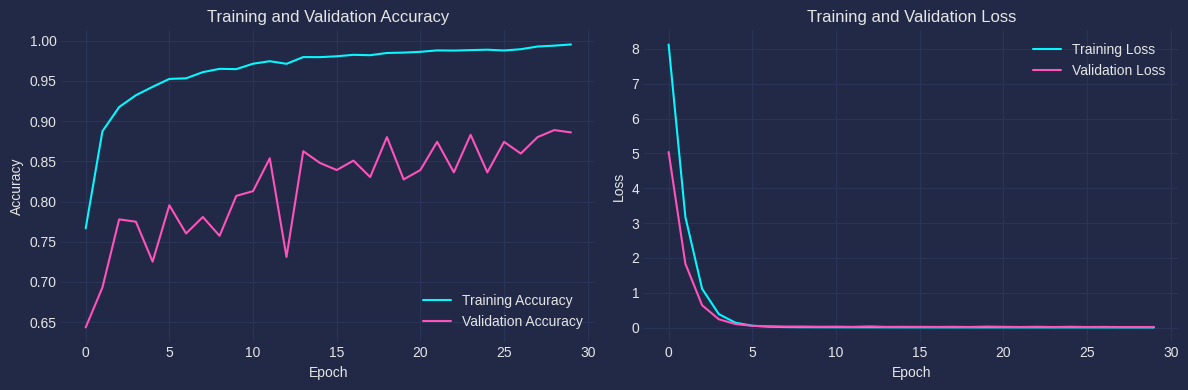

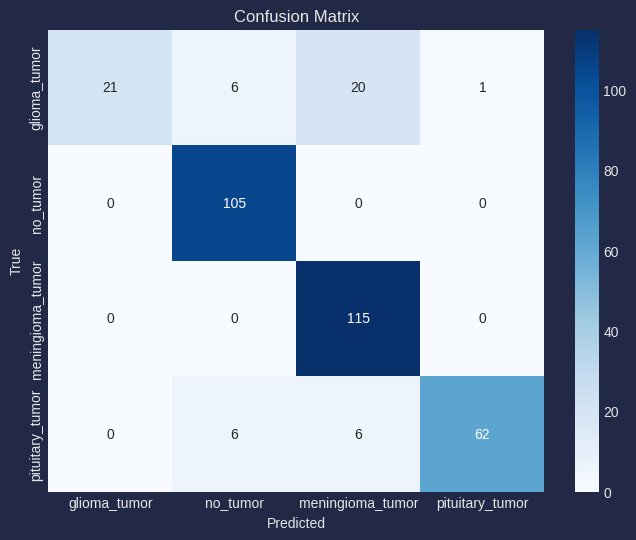

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import optuna
from sklearn.utils.class_weight import compute_class_weight
from warnings import filterwarnings
filterwarnings('ignore')

# Custom Focal Loss Implementation
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * y_true * tf.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_mean(loss, axis=-1)
    return focal_loss_fixed

# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')

# Check Dataset Directory
directory_path = '/content/drive/My Drive/DataSets'
if os.path.exists(directory_path):
    print("Klasör mevcut!")
else:
    print("Klasör mevcut değil.")
    exit()

# Data Loading
X_train = []
y_train = []
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']
image_size = 150

for i in labels:
    folderPath = os.path.join('/content/drive/My Drive/DataSets/Training', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        y_train.append(i)

X_test = []
y_test = []
for i in labels:
    folderPath = os.path.join('/content/drive/My Drive/DataSets/Testing', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (image_size, image_size))
        X_test.append(img)
        y_test.append(i)

# Convert to NumPy Arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Shuffle Training Data
X_train, y_train = shuffle(X_train, y_train, random_state=101)

# Oversampling for all classes based on imbalance
y_train_new = [labels.index(i) for i in y_train]
y_test_new = [labels.index(i) for i in y_test]

for label in labels:
    indices = [i for i, lbl in enumerate(y_train_new) if lbl == labels.index(label)]
    oversampled_X = X_train[indices]
    oversampled_y = y_train[indices]
    if label == 'no_tumor':
        X_train = np.concatenate([X_train, oversampled_X[:int(len(indices) * 0.8)]])
        y_train = np.concatenate([y_train, oversampled_y[:int(len(indices) * 0.8)]])
    elif label == 'glioma_tumor':
        X_train = np.concatenate([X_train, oversampled_X[:int(len(indices) * 0.6)]])
        y_train = np.concatenate([y_train, oversampled_y[:int(len(indices) * 0.6)]])
    else:
        X_train = np.concatenate([X_train, oversampled_X[:int(len(indices) * 0.3)]])
        y_train = np.concatenate([y_train, oversampled_y[:int(len(indices) * 0.3)]])

# Convert Labels to Categorical
y_train_new = [labels.index(i) for i in y_train]
y_train = tf.keras.utils.to_categorical(y_train_new)
y_test = tf.keras.utils.to_categorical(y_test_new)

# Class Weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_new), y=y_train_new)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict[labels.index('glioma_tumor')] *= 2.0
class_weight_dict[labels.index('no_tumor')] *= 1.5
class_weight_dict[labels.index('meningioma_tumor')] *= 1.2
class_weight_dict[labels.index('pituitary_tumor')] *= 1.2

# Assign sample weights
sample_weights = np.array([class_weight_dict[label] for label in y_train_new])

# Data Augmentation
glioma_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)

# Create generators with sample weights
train_generator = datagen.flow(X_train, y_train, batch_size=32, sample_weight=sample_weights)
glioma_indices = [i for i, label in enumerate(y_train_new) if label == labels.index('glioma_tumor')]
glioma_X = X_train[glioma_indices]
glioma_y = y_train[glioma_indices]
glioma_sample_weights = sample_weights[glioma_indices]
glioma_generator = glioma_datagen.flow(glioma_X, glioma_y, batch_size=16, sample_weight=glioma_sample_weights)

# Combine generators with sample weights
def combined_generator(generator1, generator2):
    while True:
        batch1 = next(generator1)  # (X, y, sample_weight)
        batch2 = next(generator2)  # (X, y, sample_weight)
        min_batch_size = min(batch1[0].shape[0], batch2[0].shape[0])
        combined_X = np.concatenate([batch1[0][:min_batch_size], batch2[0][:min_batch_size]], axis=0)
        combined_y = np.concatenate([batch1[1][:min_batch_size], batch2[1][:min_batch_size]], axis=0)
        combined_weights = np.concatenate([batch1[2][:min_batch_size], batch2[2][:min_batch_size]], axis=0)
        yield combined_X, combined_y, combined_weights

train_generator = combined_generator(train_generator, glioma_generator)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

# Optuna Hyperparameter Optimization
def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    alpha = trial.suggest_float("alpha", 0.1, 0.4)
    gamma = trial.suggest_float("gamma", 1.5, 3.5)
    fine_tune_layers = trial.suggest_int("fine_tune_layers", 10, 30)

    base_model = Xception(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    base_model.trainable = True
    for layer in base_model.layers[:-fine_tune_layers]:
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dropout(dropout_rate),
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dropout(dropout_rate),
        Dense(len(labels), activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=focal_loss(gamma=gamma, alpha=alpha),
        metrics=['accuracy']
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
    checkpoint = ModelCheckpoint('best_model_xception.h5', monitor='val_accuracy', save_best_only=True, mode='max')

    history = model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=20,
        steps_per_epoch=len(X_train) // batch_size,
        validation_steps=len(X_test) // batch_size,
        callbacks=[early_stopping, reduce_lr, checkpoint],
        verbose=0
    )

    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

best_params = study.best_params
print("En iyi hiperparametreler:", best_params)

# Final Model Training
learning_rate = best_params['learning_rate']
dropout_rate = best_params['dropout_rate']
batch_size = best_params['batch_size']
alpha = best_params['alpha']
gamma = best_params['gamma']
fine_tune_layers = best_params['fine_tune_layers']

base_model = Xception(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
base_model.trainable = True
for layer in base_model.layers[:-fine_tune_layers]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(dropout_rate),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(dropout_rate),
    Dense(len(labels), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=focal_loss(gamma=gamma, alpha=alpha),
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
checkpoint = ModelCheckpoint('best_model_xception_final.h5', monitor='val_accuracy', save_best_only=True, mode='max')

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    steps_per_epoch=len(X_train) // batch_size,
    validation_steps=len(X_test) // batch_size,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('training_plots_xception.png')

# Evaluation
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("Sınıflandırma Raporu:")
print(classification_report(y_true_classes, y_pred_classes, target_names=labels))

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix_xception.png')

model.save('fixedFinal_xception_model.h5')